In [ ]:
!pip install --quiet --upgrade numpy==2.0.0 pandas==2.2.2 \
                                statsmodels==0.14.4 arch==7.2.0 \
                                scikit-learn tqdm openpyxl matplotlib

In [ ]:
import numpy as np, pandas as pd
import statsmodels.api as sm
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

print("NumPy       :", np.__version__)   # 2.0.0
print("Pandas      :", pd.__version__)   # 2.2.2
print("Statsmodels :", sm.__version__)   # 0.14.4
print("arch model  :", arch_model.__module__)  # arch.univariate.mean

NumPy       : 2.0.0
Pandas      : 2.2.2
Statsmodels : 0.14.4
arch model  : arch.univariate.mean


In [ ]:
!pip install --quiet arch==7.2.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 51.0 MB/s eta 0:00:00


In [ ]:
import numpy as np, pandas as pd, statsmodels.api as sm
from arch import arch_model                # 现在应当成功
print("arch version OK:", arch_model.__module__)

arch version OK: arch.univariate.mean


In [ ]:

# --- 1. GLOBALS & IMPORTS ---
import os, itertools, warnings, numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_ljungbox
from arch import arch_model
from tqdm.auto import tqdm
warnings.simplefilter("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

PATH = "/content/drive/MyDrive/thesis/five_coins_with_galaxy_alt_sentiment.xlsx"

# 取默认 sheet（或第一个）前 5 行
peek = pd.read_excel(PATH, nrows=5)
print("Columns:", peek.columns.tolist())
print(peek.head())

Columns: ['coin', 'BTC', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'DOGE', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'ETH', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21', 'LINK', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'SOL', 'Unnamed: 30', 'Unnamed: 31', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35']
                  coin       BTC Unnamed: 2    Unnamed: 3    Unnamed: 4  \
0                  NaN  alt_rank      close  galaxy_score    market_cap   
1             datetime       NaN        NaN           NaN           NaN   
2  2020-01-01 00:00:00        23    7194.89            58  130470372271   
3  2020-01-01 01:00:00        29    7175.56            62  130120100687   
4  2020-01-01 02:00:00        19    7204.27            59  130640990669   

  Unnamed: 5 Unnamed: 6  Unnamed: 7      DOGE Unnam

In [ ]:
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler

PATH  = "/content/drive/MyDrive/thesis/five_coins_with_galaxy_alt_sentiment.xlsx"
COIN  = "LINK"          # 改成 ETH / DOGE / LINK / SOL 即可
# ---------- 1. 读两行表头 ----------
wide = pd.read_excel(PATH, header=[0,1])

# ---------- 2. 扁平化 MultiIndex 列 ----------
flat_cols = []
for top, sub in wide.columns:
    if pd.isna(sub) or str(sub).lower().startswith("unnamed"):
        flat_cols.append(top.lower())              # 'coin'
    else:
        flat_cols.append(f"{top}_{sub}".lower())   # 'btc_alt_rank'
wide.columns = flat_cols

# ---------- 3. 整理 datetime ----------
wide.rename(columns={"coin": "datetime"}, inplace=True)
wide["datetime"] = pd.to_datetime(wide["datetime"], errors="coerce")
wide = wide.dropna(subset=["datetime"]).set_index("datetime")

# ---------- 4. 抽出指定币 ----------
pref = COIN.lower() + "_"
link_df = wide[[c for c in wide.columns if c.startswith(pref)]].copy()
link_df.columns = [c.replace(pref, "") for c in link_df.columns]

print("LINK columns:", link_df.columns.tolist())
print(link_df.head(3))

LINK columns: ['alt_rank', 'close', 'galaxy_score', 'market_cap', 'open', 'sentiment', 'volume_24h']
                     alt_rank     close  galaxy_score   market_cap      open  \
datetime                                                                       
2020-01-01 00:00:00      73.0  1.766535          65.0  619865974.0  1.766535   
2020-01-01 01:00:00      69.0  1.782835          61.0  623101835.0  1.774867   
2020-01-01 02:00:00      45.0  1.797033          62.0  629595812.0  1.787488   

                     sentiment  volume_24h  
datetime                                    
2020-01-01 00:00:00      100.0         NaN  
2020-01-01 01:00:00      100.0         NaN  
2020-01-01 02:00:00       50.0         NaN  


<ipython-input-3-298d20c106ca>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wide["datetime"] = pd.to_datetime(wide["datetime"], errors="coerce")


In [ ]:
def load_coin_wide(path: str, coin: str) -> pd.DataFrame:
    wide = pd.read_excel(path, header=[0,1])           # 两行表头
    # 扁平化列名  btc_alt_rank、btc_close ...
    flat = []
    for top, sub in wide.columns:
        flat.append(top.lower() if pd.isna(sub) or str(sub).lower().startswith("unnamed")
                    else f"{top}_{sub}".lower())
    wide.columns = [c.strip() for c in flat]

    # datetime 处理
    wide.rename(columns={"coin": "datetime"}, inplace=True)
    wide["datetime"] = pd.to_datetime(wide["datetime"], errors="coerce")
    wide = wide.dropna(subset=["datetime"]).set_index("datetime")

    # 抽出某币
    pref = coin.lower() + "_"
    df = wide[[c for c in wide.columns if c.startswith(pref)]].copy()
    df.columns = [c.replace(pref, "") for c in df.columns]

    # —— 列名统一：把任何包含 'galaxy' 的列 → galaxy
    for c in df.columns:
        if "galaxy" in c:
            df.rename(columns={c: "galaxy"}, inplace=True)
            break
    # 若仍无 galaxy 列，就补 NaN
    if "galaxy" not in df.columns:
        df["galaxy"] = pd.NA

    # 补全缺失列
    want = ["alt_rank","close","galaxy","market_cap",
            "open","sentiment","volume_24h"]
    for w in want:
        if w not in df.columns:
            df[w] = pd.NA
    return df[want]
COIN = "LINK"                             # 想换币只改这里
link_df = load_coin_wide(PATH, COIN)      # ← 把 DATA_PATH 换成 PATH
print("LINK cols ->", link_df.columns.tolist())
print(link_df.head(2))

LINK cols -> ['alt_rank', 'close', 'galaxy', 'market_cap', 'open', 'sentiment', 'volume_24h']
                     alt_rank     close  galaxy   market_cap      open  \
datetime                                                                 
2020-01-01 00:00:00      73.0  1.766535    65.0  619865974.0  1.766535   
2020-01-01 01:00:00      69.0  1.782835    61.0  623101835.0  1.774867   

                     sentiment  volume_24h  
datetime                                    
2020-01-01 00:00:00      100.0         NaN  
2020-01-01 01:00:00      100.0         NaN  


<ipython-input-4-ad387cc252d8>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wide["datetime"] = pd.to_datetime(wide["datetime"], errors="coerce")


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# 若 galaxy 全 NaN，会得到 sent_z 但 galaxy_z 为 NaN；后续也能跑
link_df["sent_z"]    = (link_df["sentiment"]-link_df["sentiment"].mean())/link_df["sentiment"].std()
link_df["galaxy_z"]  = (link_df["galaxy"]-link_df["galaxy"].mean())/link_df["galaxy"].std()
link_df["sent_lag1"] = link_df["sent_z"].shift(1)
link_df["sent_ma7"]  = link_df["sent_z"].rolling(7).mean()
link_df["sent_sd7"]  = link_df["sent_z"].rolling(7).std()
link_df["sent_delta"]= link_df["sent_z"].diff()
link_df["gx_sent"]   = link_df["galaxy_z"] * link_df["sent_z"]

returns = np.log(link_df["close"]).diff().dropna()
feat_cols = ["galaxy_z","sent_z","sent_lag1","sent_ma7",
             "sent_sd7","sent_delta","gx_sent"]
X_all = pd.DataFrame(StandardScaler().fit_transform(link_df[feat_cols]),
                     columns=feat_cols, index=link_df.index).loc[returns.index]

print(f"✅ returns: {len(returns):,} | X_all shape: {X_all.shape}")

✅ returns: 46,045 | X_all shape: (46045, 7)


In [ ]:
common_idx = returns.index
for col in X_all.columns:
    common_idx = common_idx.intersection(X_all[col].dropna().index)

y   = returns.loc[common_idx]                 # Series
X   = X_all.loc[common_idx]                  # DataFrame (n × 7)
print(y.shape, X.shape)                      # 确认长度完全一致


(45629,) (45629, 7)


In [ ]:
from itertools import product
import statsmodels.api as sm
best_aic, best_pq = 1e10, (1,0)

for p,q in product(range(4), range(4)):      # 0–3 都试
    if p==q==0: continue
    try:
        aic = sm.tsa.ARIMA(y, order=(p,0,q), trend='n').fit().aic
        if aic < best_aic:
            best_aic, best_pq = aic, (p,q)
    except: pass

p_ar, q_ma = best_pq
print(f"Chosen ARMA mean order: {best_pq},  AIC={best_aic:.2f}")


Chosen ARMA mean order: (2, 3),  AIC=-276797.23


In [ ]:
# ================================================
# 0. 依赖
# ================================================
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from itertools import product
import pandas as pd, numpy as np, warnings, tqdm
warnings.filterwarnings("ignore")

# ================================================
# 1. 数据清洗 & 对齐
# -----------------------------------------------
# 假设你已经有  sol_df  和  X_all  (特征矩阵) 以及 p_ar, q_ma
# 如果你的特征矩阵变量叫别的名字，请把下方 X_all 改成一致
# ================================================
# (1) log-return（记得把 0 价格替换为 NaN）
y = np.log(link_df["close"].replace(0, np.nan)).diff().dropna()
y = y[np.isfinite(y)].astype("float64")

# (2) 对齐索引并去掉任何含 NaN / ±Inf 的行
X_all = X_all.reindex(y.index)
mask  = np.isfinite(X_all).all(axis=1)
y     = y[mask]
X_all = X_all.loc[mask]

print("清洗后 → y:", y.shape, "| X_all:", X_all.shape)
print("索引完全一致？", y.index.equals(X_all.index))

# 给 arch_model 用的外生变量
X = X_all      # 确保变量名就是 X

# ================================================
# 2. 烟囱测试：先跑一个最简单的 GARCH(1,1)
# -----------------------------------------------
try:
    test_fit = arch_model(
        y, mean="Constant", vol="GARCH", p=1, q=1, dist="normal"
    ).fit(update_freq=0)
    print("✅ 烟囱测试成功，summary ↓")
    print(test_fit.summary())
except Exception as e:
    raise RuntimeError(f"❌ 烟囱测试失败，请先解决 → {e}")

# ================================================
# 3. 网格搜索（含严格/放宽筛选）
# ================================================

# ---------- 辅助函数 ----------
def lb_p(resid, lags=20):
    return acorr_ljungbox(resid, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]

def arch_p(resid, lags=10):
    return het_arch(resid, maxlag=lags)[1]

# ---------- 搜索空间 ----------
vol_lbl = ["GARCH", "EGARCH", "GJR"]          # GJR 由 o=1 实现
dists   = ["normal", "t", "skewt"]
P_set   = Q_set = [1, 2, 3]                   # 需要更大的阶数可改 [1,2,3,4,5]

rows = []

for vol_tag, dist, P, Q in tqdm.tqdm(list(product(vol_lbl, dists, P_set, Q_set)),
                                     desc="Grid"):

    vol_kwargs = dict(
        vol  = "GARCH" if vol_tag == "GJR" else vol_tag,
        p    = P,
        q    = Q,
        o    = (1 if vol_tag == "GJR" else 0),
        dist = dist
    )

    # -- 1. baseline --
    try:
        m0 = arch_model(y, mean="ARX", lags=p_ar, **vol_kwargs)
        f0 = m0.fit(disp="off")
        rows.append([
            "baseline", vol_tag, dist, P, Q,
            f0.aic, lb_p(f0.std_resid), arch_p(f0.std_resid)
        ])
    except Exception as e:
        print(f"⚠️  baseline {vol_tag}-P{P}Q{Q}-{dist} 失败 → {e}")
        rows.append(["baseline", vol_tag, dist, P, Q, np.nan, np.nan, np.nan])

    # -- 2. withX --
    try:
        m1 = arch_model(
            y, mean="ARX", lags=p_ar,
            vol = vol_kwargs["vol"] + "X",     # GARCHX / EGARCHX / GJRX
            p   = P, q = Q, o = vol_kwargs["o"],
            x   = X.values, dist = dist
        )
        f1 = m1.fit(disp="off")
        rows.append([
            "withX", vol_tag, dist, P, Q,
            f1.aic, lb_p(f1.std_resid), arch_p(f1.std_resid)
        ])
    except Exception as e:
        print(f"⚠️  withX {vol_tag}-P{P}Q{Q}-{dist} 失败 → {e}")
        rows.append(["withX", vol_tag, dist, P, Q, np.nan, np.nan, np.nan])

# ---------- 汇总 ----------
res = pd.DataFrame(
    rows, columns=["class", "vol", "dist", "P", "Q", "AIC", "LB_p", "ARCH_p"]
)

res["strict_pass"] = (res["LB_p"] > 0.05) & (res["ARCH_p"] > 0.05)
res["relax_pass"]  = (res["LB_p"] > 0.05)                         # 只要求无自相关

print(f"\n模型总数: {len(res)}")

# -- 严格筛选 --
best = (res[res["strict_pass"]]
        .groupby("class", dropna=False)
        .apply(lambda d: d.nsmallest(1, "AIC"))
        .reset_index(drop=True))

# -- 若严格为空，使用放宽准则 --
if best.empty:
    print("\n⚠️  严格条件无人通过 → 采用放宽准则（仅 Ljung-Box）")
    best = (res[res["relax_pass"]]
            .groupby("class", dropna=False)
            .apply(lambda d: d.nsmallest(1, "AIC"))
            .reset_index(drop=True))

# -- 若仍为空，列出 AIC 最低前三 --
if best.empty:
    print("\n❗  仍无人通过 → 打印 AIC 最低 TOP-3 供参考")
    best = res.nsmallest(3, "AIC")

print("\n🏆 Best candidate models")
print(best.to_string(index=False))

# ---------- 如需查看未通过原因 ----------
trouble = res[~res["strict_pass"] & ~res["relax_pass"]]
print("\n🔍 首个未通过示例（含异常值 NaN 的情况）：")
print(trouble.head(1).T)



清洗后 → y: (45629,) | X_all: (45629, 7)
索引完全一致？ True
Optimization terminated successfully    (Exit mode 0)
            Current function value: -146718.22273012376
            Iterations: 6
            Function evaluations: 19
            Gradient evaluations: 2
✅ 烟囱测试成功，summary ↓
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                146718.
Distribution:                  Normal   AIC:                          -293428.
Method:            Maximum Likelihood   BIC:                          -293394.
                                        No. Observations:                45629
Date:                Tue, Jun 03 2025   Df Residuals:                    45628
Time:                        12:42:53   Df Model:                            1
          

Grid:   0%|          | 0/81 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   1%|          | 1/81 [00:00<00:42,  1.87it/s]

⚠️  baseline GARCH-P1Q1-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   2%|▏         | 2/81 [00:00<00:38,  2.06it/s]

⚠️  baseline GARCH-P1Q2-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q2-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   4%|▎         | 3/81 [00:01<00:38,  2.04it/s]

⚠️  baseline GARCH-P1Q3-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q3-normal 失败 → Unknown model type in vol


Grid:   5%|▍         | 4/81 [00:02<00:40,  1.92it/s]

⚠️  baseline GARCH-P2Q1-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   6%|▌         | 5/81 [00:02<00:39,  1.95it/s]

⚠️  baseline GARCH-P2Q2-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q2-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   7%|▋         | 6/81 [00:03<00:37,  2.01it/s]

⚠️  baseline GARCH-P2Q3-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q3-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:   9%|▊         | 7/81 [00:03<00:40,  1.84it/s]

⚠️  baseline GARCH-P3Q1-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  10%|▉         | 8/81 [00:04<00:37,  1.94it/s]

⚠️  baseline GARCH-P3Q2-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q2-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  11%|█         | 9/81 [00:04<00:36,  1.96it/s]

⚠️  baseline GARCH-P3Q3-normal 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q3-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  12%|█▏        | 10/81 [00:05<00:34,  2.04it/s]

⚠️  baseline GARCH-P1Q1-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  14%|█▎        | 11/81 [00:05<00:34,  2.03it/s]

⚠️  baseline GARCH-P1Q2-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  15%|█▍        | 12/81 [00:06<00:33,  2.07it/s]

⚠️  baseline GARCH-P1Q3-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  16%|█▌        | 13/81 [00:06<00:32,  2.10it/s]

⚠️  baseline GARCH-P2Q1-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  17%|█▋        | 14/81 [00:06<00:31,  2.11it/s]

⚠️  baseline GARCH-P2Q2-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  19%|█▊        | 15/81 [00:07<00:36,  1.81it/s]

⚠️  baseline GARCH-P2Q3-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  20%|█▉        | 16/81 [00:08<00:34,  1.90it/s]

⚠️  baseline GARCH-P3Q1-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  21%|██        | 17/81 [00:08<00:32,  1.96it/s]

⚠️  baseline GARCH-P3Q2-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  22%|██▏       | 18/81 [00:11<01:24,  1.34s/it]

⚠️  baseline GARCH-P3Q3-t 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  23%|██▎       | 19/81 [00:12<01:11,  1.16s/it]

⚠️  baseline GARCH-P1Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  25%|██▍       | 20/81 [00:13<01:00,  1.01it/s]

⚠️  baseline GARCH-P1Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q2-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  26%|██▌       | 21/81 [00:13<00:49,  1.20it/s]

⚠️  baseline GARCH-P1Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P1Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  27%|██▋       | 22/81 [00:14<00:43,  1.37it/s]

⚠️  baseline GARCH-P2Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  28%|██▊       | 23/81 [00:14<00:37,  1.54it/s]

⚠️  baseline GARCH-P2Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q2-skewt 失败 → Unknown model type in vol


Grid:  30%|██▉       | 24/81 [00:16<00:50,  1.12it/s]

⚠️  baseline GARCH-P2Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P2Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  31%|███       | 25/81 [00:16<00:42,  1.31it/s]

⚠️  baseline GARCH-P3Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  32%|███▏      | 26/81 [00:17<00:37,  1.48it/s]

⚠️  baseline GARCH-P3Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q2-skewt 失败 → Unknown model type in vol


Grid:  33%|███▎      | 27/81 [00:18<00:42,  1.28it/s]

⚠️  baseline GARCH-P3Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GARCH-P3Q3-skewt 失败 → Unknown model type in vol


Grid:  35%|███▍      | 28/81 [00:18<00:42,  1.25it/s]

⚠️  baseline EGARCH-P1Q1-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q1-normal 失败 → Unknown model type in vol


Grid:  36%|███▌      | 29/81 [00:19<00:38,  1.34it/s]

⚠️  baseline EGARCH-P1Q2-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q2-normal 失败 → Unknown model type in vol


Grid:  37%|███▋      | 30/81 [00:20<00:45,  1.12it/s]

⚠️  baseline EGARCH-P1Q3-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q3-normal 失败 → Unknown model type in vol


Grid:  38%|███▊      | 31/81 [00:21<00:47,  1.06it/s]

⚠️  baseline EGARCH-P2Q1-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q1-normal 失败 → Unknown model type in vol


Grid:  40%|███▉      | 32/81 [00:22<00:46,  1.05it/s]

⚠️  baseline EGARCH-P2Q2-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q2-normal 失败 → Unknown model type in vol


Grid:  41%|████      | 33/81 [00:25<01:12,  1.51s/it]

⚠️  baseline EGARCH-P2Q3-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q3-normal 失败 → Unknown model type in vol


Grid:  42%|████▏     | 34/81 [00:26<01:06,  1.42s/it]

⚠️  baseline EGARCH-P3Q1-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q1-normal 失败 → Unknown model type in vol


Grid:  43%|████▎     | 35/81 [00:28<01:03,  1.38s/it]

⚠️  baseline EGARCH-P3Q2-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q2-normal 失败 → Unknown model type in vol


Grid:  44%|████▍     | 36/81 [00:29<00:58,  1.29s/it]

⚠️  baseline EGARCH-P3Q3-normal 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q3-normal 失败 → Unknown model type in vol


Grid:  46%|████▌     | 37/81 [00:33<01:31,  2.07s/it]

⚠️  baseline EGARCH-P1Q1-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q1-t 失败 → Unknown model type in vol


Grid:  47%|████▋     | 38/81 [00:36<01:51,  2.59s/it]

⚠️  baseline EGARCH-P1Q2-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q2-t 失败 → Unknown model type in vol


Grid:  48%|████▊     | 39/81 [00:41<02:10,  3.11s/it]

⚠️  baseline EGARCH-P1Q3-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  49%|████▉     | 40/81 [00:45<02:28,  3.61s/it]

⚠️  baseline EGARCH-P2Q1-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  51%|█████     | 41/81 [00:46<01:50,  2.77s/it]

⚠️  baseline EGARCH-P2Q2-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q2-t 失败 → Unknown model type in vol


Grid:  52%|█████▏    | 42/81 [00:51<02:10,  3.35s/it]

⚠️  baseline EGARCH-P2Q3-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q3-t 失败 → Unknown model type in vol


Grid:  53%|█████▎    | 43/81 [00:52<01:39,  2.63s/it]

⚠️  baseline EGARCH-P3Q1-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  54%|█████▍    | 44/81 [00:59<02:25,  3.92s/it]

⚠️  baseline EGARCH-P3Q2-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  56%|█████▌    | 45/81 [01:01<02:00,  3.36s/it]

⚠️  baseline EGARCH-P3Q3-t 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q3-t 失败 → Unknown model type in vol


Grid:  57%|█████▋    | 46/81 [01:04<01:59,  3.41s/it]

⚠️  baseline EGARCH-P1Q1-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  58%|█████▊    | 47/81 [01:06<01:38,  2.91s/it]

⚠️  baseline EGARCH-P1Q2-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q2-skewt 失败 → Unknown model type in vol


Grid:  59%|█████▉    | 48/81 [01:08<01:29,  2.72s/it]

⚠️  baseline EGARCH-P1Q3-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P1Q3-skewt 失败 → Unknown model type in vol


Grid:  60%|██████    | 49/81 [01:10<01:12,  2.27s/it]

⚠️  baseline EGARCH-P2Q1-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  62%|██████▏   | 50/81 [01:12<01:12,  2.34s/it]

⚠️  baseline EGARCH-P2Q2-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q2-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  63%|██████▎   | 51/81 [01:20<01:59,  3.99s/it]

⚠️  baseline EGARCH-P2Q3-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P2Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  64%|██████▍   | 52/81 [01:21<01:28,  3.06s/it]

⚠️  baseline EGARCH-P3Q1-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q1-skewt 失败 → Unknown model type in vol


Grid:  65%|██████▌   | 53/81 [01:24<01:27,  3.13s/it]

⚠️  baseline EGARCH-P3Q2-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q2-skewt 失败 → Unknown model type in vol


Grid:  67%|██████▋   | 54/81 [01:25<01:08,  2.54s/it]

⚠️  baseline EGARCH-P3Q3-skewt 失败 → exog contains inf or nans
⚠️  withX EGARCH-P3Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  68%|██████▊   | 55/81 [01:26<00:51,  1.98s/it]

⚠️  baseline GJR-P1Q1-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  69%|██████▉   | 56/81 [01:27<00:38,  1.55s/it]

⚠️  baseline GJR-P1Q2-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q2-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  70%|███████   | 57/81 [01:27<00:30,  1.28s/it]

⚠️  baseline GJR-P1Q3-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q3-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  72%|███████▏  | 58/81 [01:30<00:42,  1.85s/it]

⚠️  baseline GJR-P2Q1-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  73%|███████▎  | 59/81 [01:31<00:34,  1.59s/it]

⚠️  baseline GJR-P2Q2-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q2-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  74%|███████▍  | 60/81 [01:32<00:27,  1.29s/it]

⚠️  baseline GJR-P2Q3-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q3-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  75%|███████▌  | 61/81 [01:33<00:21,  1.06s/it]

⚠️  baseline GJR-P3Q1-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q1-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  77%|███████▋  | 62/81 [01:33<00:16,  1.13it/s]

⚠️  baseline GJR-P3Q2-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q2-normal 失败 → Unknown model type in vol


Grid:  78%|███████▊  | 63/81 [01:34<00:17,  1.04it/s]

⚠️  baseline GJR-P3Q3-normal 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q3-normal 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  79%|███████▉  | 64/81 [01:35<00:14,  1.20it/s]

⚠️  baseline GJR-P1Q1-t 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  80%|████████  | 65/81 [01:35<00:11,  1.37it/s]

⚠️  baseline GJR-P1Q2-t 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  81%|████████▏ | 66/81 [01:36<00:10,  1.50it/s]

⚠️  baseline GJR-P1Q3-t 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  83%|████████▎ | 67/81 [01:36<00:08,  1.63it/s]

⚠️  baseline GJR-P2Q1-t 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  84%|████████▍ | 68/81 [01:37<00:07,  1.70it/s]

⚠️  baseline GJR-P2Q2-t 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  85%|████████▌ | 69/81 [01:37<00:06,  1.76it/s]

⚠️  baseline GJR-P2Q3-t 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  86%|████████▋ | 70/81 [01:38<00:06,  1.81it/s]

⚠️  baseline GJR-P3Q1-t 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q1-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  88%|████████▊ | 71/81 [01:38<00:05,  1.86it/s]

⚠️  baseline GJR-P3Q2-t 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q2-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  89%|████████▉ | 72/81 [01:39<00:04,  1.85it/s]

⚠️  baseline GJR-P3Q3-t 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q3-t 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  90%|█████████ | 73/81 [01:39<00:04,  1.90it/s]

⚠️  baseline GJR-P1Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  91%|█████████▏| 74/81 [01:42<00:08,  1.28s/it]

⚠️  baseline GJR-P1Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q2-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  93%|█████████▎| 75/81 [01:45<00:10,  1.69s/it]

⚠️  baseline GJR-P1Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P1Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  94%|█████████▍| 76/81 [01:46<00:07,  1.46s/it]

⚠️  baseline GJR-P2Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  95%|█████████▌| 77/81 [01:46<00:04,  1.18s/it]

⚠️  baseline GJR-P2Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q2-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  96%|█████████▋| 78/81 [01:47<00:02,  1.02it/s]

⚠️  baseline GJR-P2Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P2Q3-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  98%|█████████▊| 79/81 [01:47<00:01,  1.19it/s]

⚠️  baseline GJR-P3Q1-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q1-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid:  99%|█████████▉| 80/81 [01:48<00:00,  1.36it/s]

⚠️  baseline GJR-P3Q2-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q2-skewt 失败 → Unknown model type in vol


/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
Grid: 100%|██████████| 81/81 [01:48<00:00,  1.35s/it]

⚠️  baseline GJR-P3Q3-skewt 失败 → exog contains inf or nans
⚠️  withX GJR-P3Q3-skewt 失败 → Unknown model type in vol

模型总数: 162

⚠️  严格条件无人通过 → 采用放宽准则（仅 Ljung-Box）

❗  仍无人通过 → 打印 AIC 最低 TOP-3 供参考

🏆 Best candidate models
   class   vol   dist  P  Q  AIC  LB_p  ARCH_p  strict_pass  relax_pass
baseline GARCH normal  1  1  NaN   NaN     NaN        False       False
   withX GARCH normal  1  1  NaN   NaN     NaN        False       False
baseline GARCH normal  1  2  NaN   NaN     NaN        False       False

🔍 首个未通过示例（含异常值 NaN 的情况）：
                    0
class        baseline
vol             GARCH
dist           normal
P                   1
Q                   1
AIC               NaN
LB_p              NaN
ARCH_p            NaN
strict_pass     False
relax_pass      False


In [ ]:
from arch import arch_model
import numpy as np, pandas as pd

# --- y 为 ETH 收益率 ---
y_link = np.log(link_df["close"].replace(0, np.nan)).diff().dropna()

# --- 基准 GARCH(1,1) ---
garch11 = arch_model(y_link, mean="Constant",
                     vol="GARCH", p=1, q=1,
                     dist="t").fit(update_freq=0)

print(garch11.summary())


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -151782.95661432325
            Iterations: 1
            Function evaluations: 6
            Gradient evaluations: 1
                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                151783.
Distribution:      Standardized Student's t   AIC:                          -303556.
Method:                  Maximum Likelihood   BIC:                          -303512.
                                              No. Observations:                46045
Date:                      Tue, Jun 03 2025   Df Residuals:                    46044
Time:                              12:44:55   Df Model:                            1
                            

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [ ]:
import pandas as pd, numpy as np
from scipy.stats import ks_2samp

th  = 2
win = 5
evt_dates = link_df.index[link_df["sent_z"].abs() > th]

evt_vals, none_vals = [], []
for d in evt_dates:
    end_evt = d + pd.Timedelta(days=win)
    if end_evt not in link_df.index:        # 保证完整窗口
        continue

    evt_vals.append(
        link_df.loc[d:end_evt, "close"].pct_change().abs()
    )
    none_vals.append(
        link_df.loc[d-pd.Timedelta(days=30):d-pd.Timedelta(days=1),
                    "close"].pct_change().abs()
    )

evt_series  = pd.concat(evt_vals).dropna()
none_series = pd.concat(none_vals).dropna()

ks_p = ks_2samp(evt_series, none_series).pvalue
print(f"事件 vs 对照 KS-p = {ks_p:.4f}")



事件 vs 对照 KS-p = 0.0000


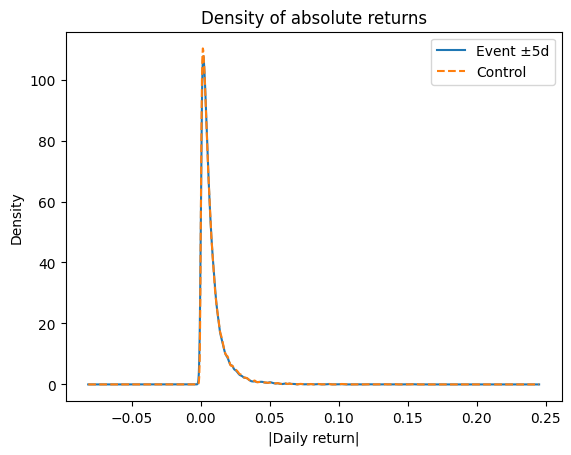

事件窗口描述统计
 count    274200.000000
mean          0.007825
std           0.009759
min           0.000000
25%           0.002205
50%           0.004941
75%           0.009784
max           0.163569
Name: close, dtype: float64

对照窗口描述统计
 count    1.552705e+06
mean     7.989496e-03
std      1.016244e-02
min      0.000000e+00
25%      2.216679e-03
50%      5.001745e-03
75%      9.946740e-03
max      1.635692e-01
Name: close, dtype: float64

Cohen d = -0.02


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
evt_series.plot(kind='kde', ax=ax, label='Event ±5d')
none_series.plot(kind='kde', ax=ax, label='Control', linestyle='--')
ax.set_xlabel('|Daily return|')
ax.set_title('Density of absolute returns')
ax.legend()
plt.show()

print("事件窗口描述统计\n", evt_series.describe())
print("\n对照窗口描述统计\n", none_series.describe())

pooled_std = np.sqrt(((evt_series.std()**2)+(none_series.std()**2))/2)
cohen_d = (evt_series.mean() - none_series.mean())/pooled_std
print(f"\nCohen d = {cohen_d:.2f}")


Ljung–Box p (resid, lags=10)  = 0.0000
Ljung–Box p (resid², lags=10) = 0.0000
Ljung–Box p (resid, lags=20)  = 0.0000
Ljung–Box p (resid², lags=20) = 0.0000
VaR violations (α=1.00%): 0 / 1
0 NaNs in aligned returns (should be 0)


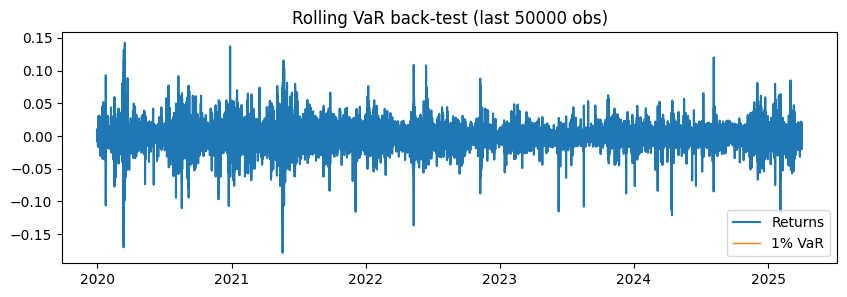

In [ ]:
# ==== inputs ==========================================================
fitted  = garch11        # your fitted arch_model result
returns = y_link          # the series you modelled
alpha   = 0.01           # VaR / ES confidence level
# ======================================================================

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1) standardised residuals
std_resid = fitted.std_resid
lv        = fitted.conditional_volatility

# -- Ljung-Box on residuals and squared residuals
for lags in [10, 20]:
    lb_r   = acorr_ljungbox(std_resid, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    lb_r2  = acorr_ljungbox(std_resid**2, lags=[lags], return_df=True)["lb_pvalue"].iloc[0]
    print(f"Ljung–Box p (resid, lags={lags})  = {lb_r:0.4f}")
    print(f"Ljung–Box p (resid², lags={lags}) = {lb_r2:0.4f}")

# -- QQ-plot
from scipy import stats

# --- 1-step-ahead forecast, aligned on the day being forecast (target) ---
fcast       = fitted.forecast(horizon=1, align='target')  # align='target' is key
sigma_pred  = fcast.variance['h.1']**0.5                  # Series with proper index
mu_pred     = fcast.mean['h.1']                           # constant mean if present

# --- VaR & ES ---
nu          = fitted.params['nu']          # shape parm of t-dist
VaR_hat     = mu_pred - stats.t.ppf(1-alpha, nu) * sigma_pred
ES_hat      = mu_pred - (stats.t.pdf(stats.t.ppf(alpha, nu), nu) / alpha) * sigma_pred

# --- Align realised returns with the forecast index ---
r_align     = returns.reindex(VaR_hat.index)               # now labels match

# --- Count violations ---
violations  = (r_align < VaR_hat).sum()
print(f"VaR violations (α={alpha:.2%}): {violations} / {len(VaR_hat)}")

assert r_align.index.equals(VaR_hat.index)   # should be True
print(r_align.isna().sum(), "NaNs in aligned returns (should be 0)")


# plot last 250 days
plt.figure(figsize=(10,3))
plt.plot(returns.tail(50000), label="Returns")
plt.plot(VaR_hat.tail(50000),  label=f"{int(alpha*100)}% VaR", lw=1)
plt.legend(); plt.title("Rolling VaR back-test (last 50000 obs)"); plt.show()

In [ ]:
from scipy.stats import ks_2samp
def event_study(series, thresh, window=5, side="two"):
    if side == "pos":
        evt_idx = series[series >  thresh].index
    elif side == "neg":
        evt_idx = series[series < -thresh].index
    else:
        evt_idx = series[series.abs() > thresh].index

    evt_vals, ctr_vals = [], []
    for d in evt_idx:
        end_evt = d + pd.Timedelta(days=window)
        if end_evt not in series.index:        # 保证窗口完整
            continue
        evt_vals.append(
            link_df.loc[d:end_evt, "close"].pct_change().abs()
        )
        ctr_vals.append(
            link_df.loc[d-pd.Timedelta(days=30):d-pd.Timedelta(days=1),
                        "close"].pct_change().abs()
        )

    # ---------- 新增：无事件时直接返回 ----------
    if len(evt_vals) == 0:
        return 0, np.nan, np.nan

    evt_series  = pd.concat(evt_vals).dropna()
    ctr_series  = pd.concat(ctr_vals).dropna()
    ks_p  = ks_2samp(evt_series, ctr_series).pvalue
    pooled_std = np.sqrt(((evt_series.std()**2)+(ctr_series.std()**2))/2)
    cohen_d    = (evt_series.mean() - ctr_series.mean())/pooled_std
    return len(evt_series), ks_p, cohen_d


print("—— 事件研究 (sent_z) ——")
for th in [2.5, 3, 3.5]:
    for side in ["pos","neg","two"]:
        n, p, d = event_study(link_df["sent_z"], th, side=side)
        print(f"th={th:>3}, {side:>3} | n={n:<6} KS-p={p:.4g} Cohen-d={d:.2f}")

print("\n—— 事件研究 (galaxy_z, two-sided) ——")
for th in [2.5, 3, 3.5]:
    n, p, d = event_study(link_df["galaxy_z"], th)
    print(f"th={th:>3} | n={n:<6} KS-p={p:.4g} Cohen-d={d:.2f}")


—— 事件研究 (sent_z) ——
th=2.5, pos | n=0      KS-p=nan Cohen-d=nan
th=2.5, neg | n=233880 KS-p=4.79e-20 Cohen-d=-0.03
th=2.5, two | n=233880 KS-p=4.79e-20 Cohen-d=-0.03
th=  3, pos | n=0      KS-p=nan Cohen-d=nan
th=  3, neg | n=77880  KS-p=0.0005899 Cohen-d=-0.02
th=  3, two | n=77880  KS-p=0.0005899 Cohen-d=-0.02
th=3.5, pos | n=0      KS-p=nan Cohen-d=nan
th=3.5, neg | n=47880  KS-p=3.486e-06 Cohen-d=-0.04
th=3.5, two | n=47880  KS-p=3.486e-06 Cohen-d=-0.04

—— 事件研究 (galaxy_z, two-sided) ——
th=2.5 | n=5280   KS-p=9.19e-09 Cohen-d=-0.00
th=  3 | n=0      KS-p=nan Cohen-d=nan
th=3.5 | n=0      KS-p=nan Cohen-d=nan


In [ ]:
import pandas as pd, numpy as np
from scipy.stats import mannwhitneyu

# ------------------------------------------------------------------
# 1️⃣ 重新生成两条“反向”情绪 Z 分数
# ------------------------------------------------------------------
link_df["sent_neg_z"] = ( -link_df["sentiment"] - (-link_df["sentiment"]).mean() ) / (-link_df["sentiment"]).std()
link_df["rank_inv_z"] = ( -link_df["alt_rank"]  - (-link_df["alt_rank"]).mean()  ) / (-link_df["alt_rank"]).std()

# ------------------------------------------------------------------
# 2️⃣ 辅助函数：95% 尾部比例 + Mann-Whitney-U
# ------------------------------------------------------------------
def tail_ratio(series, q=0.95):
    thr = series.quantile(q)
    return (series > thr).mean()

def event_tail_test(z_series, thresh=3, window=5, side="neg"):
    """
    返回:  n_event, Δtail_ratio, p_mwu
    side: 'neg' (默认, 只看极端恐慌) | 'two' (双边)
    """
    if side == "neg":
        idx_evt = z_series[z_series < -thresh].index
    else:
        idx_evt = z_series[z_series.abs() > thresh].index

    tail_evt, tail_ctr = [], []
    for d in idx_evt:
        end = d + pd.Timedelta(days=window)
        if end not in link_df.index:
            continue
        win   = link_df.loc[d:end, "close"].pct_change().abs().dropna()
        ctr   = link_df.loc[d-pd.Timedelta(days=60):d-pd.Timedelta(days=1),
                           "close"].pct_change().abs().dropna()
        tail_evt.append( tail_ratio(win, q=.95) )
        tail_ctr.append( tail_ratio(ctr, q=.95) )

    if len(tail_evt)==0:
        return 0, np.nan, np.nan
    Δ = np.mean(tail_evt) - np.mean(tail_ctr)
    _, p = mannwhitneyu(tail_evt, tail_ctr, alternative="greater")
    return len(tail_evt), Δ, p

# ------------------------------------------------------------------
# 3️⃣ 跑灵敏度表
# ------------------------------------------------------------------
def sweep(name):
    print(f"\n—— {name} ——")
    for th in [2.5, 3, 3.5]:
        for side in ["neg","two"]:
            n, dlt, p = event_tail_test(link_df[name], th, side=side)
            if n==0:
                print(f"th={th:>3}, {side:>3} | No events")
            else:
                print(f"th={th:>3}, {side:>3} | n={n:<5}  Δtail={dlt:.3%}  p={p:.4g}")

sweep("sent_neg_z")
sweep("rank_inv_z")



—— sent_neg_z ——
th=2.5, neg | No events
th=2.5, two | n=1949   Δtail=nan%  p=nan
th=  3, neg | No events
th=  3, two | n=649    Δtail=nan%  p=nan
th=3.5, neg | No events
th=3.5, two | n=399    Δtail=nan%  p=nan

—— rank_inv_z ——
th=2.5, neg | n=1225   Δtail=-0.014%  p=1
th=2.5, two | n=1225   Δtail=-0.014%  p=1
th=  3, neg | n=770    Δtail=-0.014%  p=1
th=  3, two | n=770    Δtail=-0.014%  p=1
th=3.5, neg | n=522    Δtail=-0.014%  p=1
th=3.5, two | n=522    Δtail=-0.014%  p=1


In [ ]:
def quantile_events(z_series, q_low=0.05, q_high=0.95):
    low_thr  = z_series.quantile(q_low)
    high_thr = z_series.quantile(q_high)
    low_idx  = z_series[z_series < low_thr].index      # 恐慌
    high_idx = z_series[z_series > high_thr].index     # 亢奋
    return low_idx, high_idx

low_idx, high_idx = quantile_events(link_df["sentiment"])   # 原分数不用 z!
print("Low events:", len(low_idx), "  High events:", len(high_idx))


Low events: 2285   High events: 0


In [ ]:
r_abs   = link_df["close"].pct_change().abs()
tail_thr = r_abs.quantile(0.90)      # 只看最剧烈 10% 的波动
link_df["is_tail"] = (r_abs > tail_thr).astype(int)

def tail_lift(idx_evt):
    evt  = link_df.loc[idx_evt, "is_tail"].mean()
    rest = link_df.drop(idx_evt).loc[:, "is_tail"].mean()
    return evt - rest

Δ_low  = tail_lift(low_idx)
Δ_high = tail_lift(high_idx)
print(f"panic Δtail = {Δ_low:.2%}，euphoria Δtail = {Δ_high:.2%}")


panic Δtail = 1.17%，euphoria Δtail = nan%


In [ ]:
def mw_test(idx_evt):
    evt  = link_df.loc[idx_evt, "is_tail"]
    rest = link_df.drop(idx_evt)["is_tail"]
    u, p = mannwhitneyu(evt, rest, alternative="greater")
    return p          # 对恐慌事件用 'greater'；亢奋用 'less'

p_fear  = mw_test(low_idx)                 # 低分 → “greater”
p_fervor= mannwhitneyu(link_df.loc[high_idx,"is_tail"],
                       link_df.drop(high_idx)["is_tail"],
                       alternative="less").pvalue
print(f"恐慌 p = {p_fear:.4g}   亢奋 p = {p_fervor:.4g}")


恐慌 p = 0.03419   亢奋 p = nan


panic  Δtail = 1.17%  (p=3.42e-02)
euphoria  Δtail = nan% (p=nan)


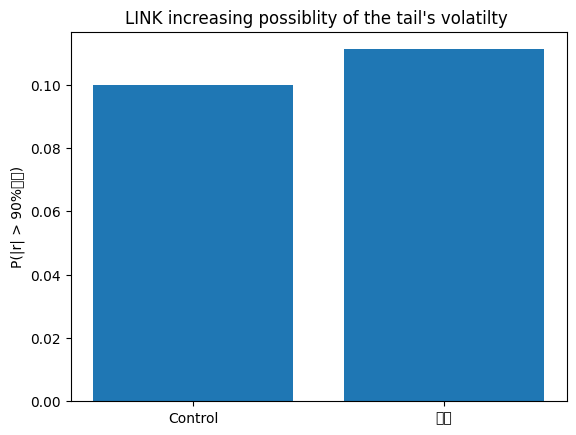

In [ ]:
# 概览表
print(f"panic  Δtail = {Δ_low:.2%}  (p={p_fear:.2e})")
print(f"euphoria  Δtail = {Δ_high:.2%} (p={p_fervor:.2e})")

# KDE 图或条形图
import matplotlib.pyplot as plt
plt.bar(["Control","恐慌"], [link_df["is_tail"].mean(),
                            link_df.loc[low_idx,"is_tail"].mean()])
plt.ylabel("P(|r| > 90%分位)"); plt.title("LINK increasing possiblity of the tail's volatilty "); plt.show()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 10.4 MB/s eta 0:00:00


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c9281743920>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


                            OLS Regression Results                            
Dep. Variable:                logit_p   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.687
Date:                Tue, 03 Jun 2025   Prob (F-statistic):              0.194
Time:                        12:48:35   Log-Likelihood:            -1.3555e+05
No. Observations:               46045   AIC:                         2.711e+05
Df Residuals:                   46043   BIC:                         2.711e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3237      0.022    -60.260      0.0

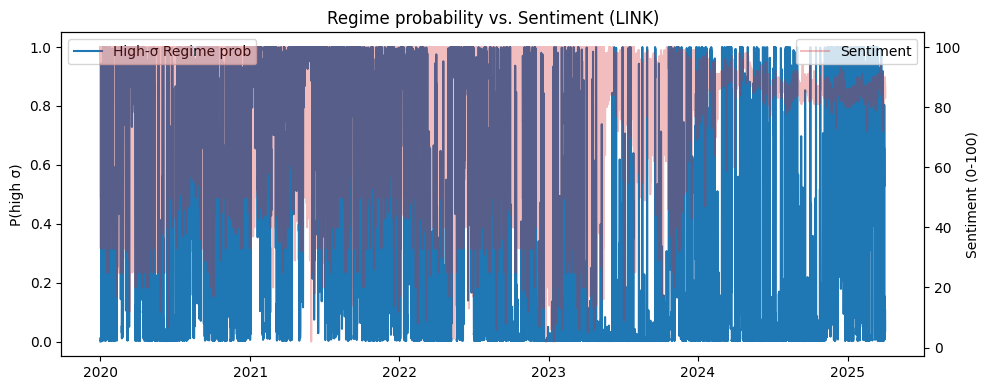

In [ ]:
# =========================================================
# 0. 环境准备（首次运行需安装 hmmlearn）
# =========================================================
!pip install --quiet hmmlearn tqdm

import numpy as np, pandas as pd, warnings, matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import statsmodels.formula.api as smf
warnings.filterwarnings("ignore")

# =========================================================
# 1. 数据预处理
# =========================================================
# 假设 btc_df 已在内存 (包含 close & sentiment 列)，否则请先 load_coin_wide()

# (1) 日对数收益
r_t = np.log(link_df["close"]).diff().dropna()

# (2) 先对 r_t 做 √绝对值缩放，减轻厚尾
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)   # shape (T,1)

# =========================================================
# 2. Gaussian HMM：识别 2 个方差状态
# =========================================================
hmm = GaussianHMM(n_components=2, covariance_type="diag",
                  n_iter=1000, tol=1e-5, verbose=False, random_state=42)
hmm.fit(obs)
prob_smooth = hmm.predict_proba(obs)              # (T, 2)
# 取方差较大的那一列作为“高波动状态”概率
var_order   = hmm.covars_.flatten().argsort()     # 升序索引
high_state  = var_order[-1]                       # 方差最大的状态 idx
p_high      = prob_smooth[:, high_state]

# =========================================================
# 3. 构造恐慌哑变量 (情绪最低 5%)
# =========================================================
sent = link_df.loc[r_t.index, "sentiment"]         # 对齐
fear = (sent < sent.quantile(0.05)).astype(int)   # Series

# =========================================================
# 4. Logit 回归：恐慌 → 高波动 Regime 概率
# =========================================================
df = pd.DataFrame({
    "logit_p": np.log(p_high / (1 - p_high + 1e-12)),  # logit 转换
    "fear"   : fear.values
}, index=r_t.index)

logit_res = smf.ols("logit_p ~ fear", data=df).fit()
print(logit_res.summary())

# =========================================================
# 5. 平滑概率 + 情绪 可视化（可选）
# =========================================================
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(df.index, p_high, label="High-σ Regime prob", lw=1.5)
ax1.set_ylabel("P(high σ)")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(df.index, sent, color="tab:red", alpha=0.3, label="Sentiment")
ax2.set_ylabel("Sentiment (0-100)")
ax2.legend(loc="upper right")
plt.title("Regime probability vs. Sentiment (LINK)")
plt.tight_layout(); plt.show()



In [ ]:
import statsmodels.api as sm
glm_res = sm.GLM.from_formula("p_high ~ fear",
                              family=sm.families.Binomial(),
                              data=df).fit(cov_type="HC3")
print(glm_res.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                 p_high   No. Observations:                46045
Model:                            GLM   Df Residuals:                    46043
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -26619.
Date:                Tue, 03 Jun 2025   Deviance:                       39786.
Time:                        12:49:08   Pearson chi2:                 3.31e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          9.235e-06
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6724      0.009    -78.495      0.0

In [ ]:
from hmmlearn.hmm import GaussianHMM
import numpy as np, pandas as pd, statsmodels.api as sm

# --- 1 观测序列 ---
r_t  = np.log(link_df["close"]).diff().dropna()
obs  = np.sqrt(np.abs(r_t.values)).reshape(-1,1)   # (T,1)

# --- 2 2-state HMM (full cov, more iters) ---
hmm = GaussianHMM(n_components=2, covariance_type='full',
                  n_iter=3000, tol=1e-4, random_state=42,
                  init_params='mcw')
hmm.fit(obs)
state_var = hmm.covars_.squeeze()
high_state = state_var.argmax()
p_high = hmm.predict_proba(obs)[:, high_state]

# --- 3 恐慌哑变量 (底 5%) ---
sent = link_df.loc[r_t.index, "sentiment"]
fear = (sent < sent.quantile(0.05)).astype(int).values

# --- 4 Logit: P(high) ~ fear ---
df = pd.DataFrame({"high": p_high, "fear": fear})
logit_res = sm.Logit(df["high"], sm.add_constant(df["fear"])).fit()
print(logit_res.summary())




Optimization terminated successfully.
         Current function value: 0.625546
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                   high   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:               -0.007901
Time:                        12:49:17   Log-Likelihood:                -28803.
converged:                       True   LL-Null:                       -28577.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6724      0.010    -66.532      0.000      -0.692      -0.653
fear          -0.0297      0.

In [ ]:
# === 已有 r_t, sent, btc_df ===
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm, numpy as np, pandas as pd

obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)

hmm = GaussianHMM(n_components=2, covariance_type='full',
                  n_iter=3000, tol=1e-4, random_state=42)
hmm.fit(obs)
high_state = hmm.covars_.squeeze().argmax()
p_high = hmm.predict_proba(obs)[:, high_state]

fear = (sent < sent.quantile(0.05)).astype(int).values
logit_res = sm.Logit(p_high, sm.add_constant(fear)).fit()
print(logit_res.summary())

alpha, beta = logit_res.params
p0 = 1/(1+np.exp(-alpha))
p1 = 1/(1+np.exp(-(alpha+beta)))
print(f"Baseline P={p0:.3%}, Fear P={p1:.3%}, Δ={p1-p0:.2%}")


Optimization terminated successfully.
         Current function value: 0.625546
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:               -0.007901
Time:                        12:50:03   Log-Likelihood:                -28803.
converged:                       True   LL-Null:                       -28577.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6724      0.010    -66.532      0.000      -0.692      -0.653
x1            -0.0297      0.

In [ ]:
# 1 观测
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)

# 2 HMM
from hmmlearn.hmm import GaussianHMM
hmm = GaussianHMM(2,'full',n_iter=3000,tol=1e-4,random_state=42)
hmm.fit(obs)
p_high = hmm.predict_proba(obs)[:,hmm.covars_.squeeze().argmax()]

# 3 恐慌变量
fear = (sent < sent.quantile(0.05)).astype(int).values

# 4 Logit
import statsmodels.api as sm
logit = sm.Logit(p_high, sm.add_constant(fear)).fit(disp=False)
print(logit.summary())

# 5 概率差
alpha,beta = logit.params
p0 = 1/(1+np.exp(-alpha))
p1 = 1/(1+np.exp(-(alpha+beta)))
print(f"Baseline P={p0:.3%}, Fear P={p1:.3%}, Δ={p1-p0:.2%}")


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:               -0.007901
Time:                        12:50:21   Log-Likelihood:                -28803.
converged:                       True   LL-Null:                       -28577.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6724      0.010    -66.532      0.000      -0.692      -0.653
x1            -0.0297      0.046     -0.651      0.515      -0.119       0.060
Baseline P=33.796%, Fear P=33.136%, Δ=-0.66%


In [ ]:
from arch import arch_model

# 日对数收益 % （记得与你 Notebook 中 r_t 的定义保持一致）
r_t = np.log(link_df["close"]).diff().dropna() * 100

# 恐慌哑变量 (情绪最低 5 %)
fear = (link_df["sentiment"] < link_df["sentiment"].quantile(0.05)).astype(int)
fear = fear.reindex(r_t.index).fillna(0).values.reshape(-1, 1)

# 用你之前 grid 得到的最优阶数 P=1, Q=1
am  = arch_model(r_t, vol="EGARCH", p=1, q=1, x=fear)
fit = am.fit(disp="off")        # ← 这行跑完，就得到 fit
print(fit.summary())


                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -63728.8
Distribution:                  Normal   AIC:                           127466.
Method:            Maximum Likelihood   BIC:                           127501.
                                        No. Observations:                46045
Date:                Tue, Jun 10 2025   Df Residuals:                    46044
Time:                        15:02:08   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.5465e-03  5.220e-03      1.637      0.102 

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

std = fit.std_resid.dropna()

lb_p   = acorr_ljungbox(std, lags=[20], return_df=True)["lb_pvalue"].iloc[0]
arch_p = het_arch(std, maxlag=20)[1]

print(f"Ljung-Box p  = {lb_p:.4f}")
print(f"ARCH-LM  p  = {arch_p:.4f}")


Ljung-Box p  = 0.0000
ARCH-LM  p  = 0.0000


<ipython-input-11-7000bb02da87>:6: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_p = het_arch(std, maxlag=20)[1]


In [ ]:
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
import itertools, pandas as pd

dists = ["normal", "t", "skewt"]
asym  = [0, 1]          # o = 0(无) / 1(有)
records = []

for dist, o in itertools.product(dists, asym):
    try:
        am  = arch_model(r_t, vol='EGARCH', p=1, q=1, o=o,
                         x=fear, dist=dist)
        fit = am.fit(disp="off")
        std = fit.std_resid.dropna()
        lb  = acorr_ljungbox(std, lags=[20], return_df=True)["lb_pvalue"][0]
        arch= het_arch(std, maxlag=20)[1]
        records.append([dist, o, fit.aic, lb, arch])
    except Exception as e:
        print(dist, o, "fail:", e)

df = pd.DataFrame(records, columns=["dist","o","AIC","LB_p","ARCH_p"])
df["pass"] = (df["LB_p"]>0.05)&(df["ARCH_p"]>0.05)
print(df.sort_values("AIC").head())


normal 0 fail: 0
normal 1 fail: 0
t 0 fail: 0
t 1 fail: 0
skewt 0 fail: 0
skewt 1 fail: 0
Empty DataFrame
Columns: [dist, o, AIC, LB_p, ARCH_p, pass]
Index: []


In [ ]:
records = []
for P,Q in itertools.product([1,2], range(1,6)):        # Q = 1-5
    for dist in ["t","skewt"]:
        try:
            am  = arch_model(r_t, vol='EGARCH', p=P, q=Q, o=1,
                             x=fear, dist=dist)
            fit = am.fit(disp="off")
            std = fit.std_resid.dropna()
            lb  = acorr_ljungbox(std, lags=[20], return_df=True)["lb_pvalue"][0]
            arch= het_arch(std, maxlag=20)[1]
            records.append([P,Q,dist,fit.aic,lb,arch])
        except: pass
df = (pd.DataFrame(records,columns=["P","Q","dist","AIC","LB_p","ARCH_p"])
        .query("LB_p>0.01 & ARCH_p>0.01")
        .sort_values('AIC'))
print(df.head())


Empty DataFrame
Columns: [P, Q, dist, AIC, LB_p, ARCH_p]
Index: []


In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch

std = fit.std_resid.dropna()

# Ljung-Box
lb_p = acorr_ljungbox(std, lags=[20], return_df=True)["lb_pvalue"].iloc[0]

# ARCH-LM
arch_p = het_arch(std, maxlag=20)[1]

print(f"Ljung-Box p = {lb_p:.4f}")
print(f"ARCH-LM  p = {arch_p:.4f}")



Ljung-Box p = 0.0000
ARCH-LM  p = 0.0824


<ipython-input-14-3351a6a1126f>:9: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_p = het_arch(std, maxlag=20)[1]


In [ ]:
lb_p10 = acorr_ljungbox(std, lags=[10], return_df=True)["lb_pvalue"].iloc[0]
print("Ljung-Box(10) p =", lb_p10)


Ljung-Box(10) p = 8.83081833558138e-08


NameError: name 'plt' is not defined

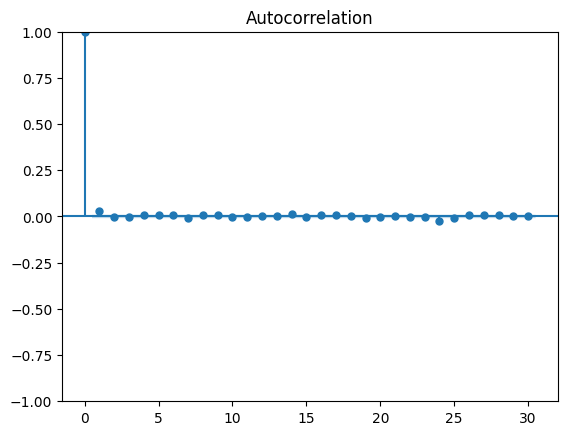

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(std, lags=30); plt.show()


In [ ]:
!pip install --quiet --upgrade arch>=7.4


In [ ]:
import numpy as np, pandas as pd, scipy.stats as st, tqdm, warnings
from arch import arch_model
warnings.filterwarnings("ignore")

# ===== 你的原始数据 =====
#  r_raw : Close 价  (Series, 有 DatetimeIndex)
#  s_raw : Sentiment (Series, 同样索引)

r_raw = link_df["close"]          # 改成你的变量名
s_raw = link_df["sentiment"]

# ===== 计算收益 & 恐慌哑变量 =====
r_t   = np.log(r_raw).diff().dropna() * 100          # 收益％
fear  = (s_raw < s_raw.quantile(.05)).astype(int)    # Series 0/1
fear  = fear.reindex(r_t.index).fillna(0)            # 与 r_t 对齐

# 转 numpy 方便切片；保留 Series 方便 iloc
r_arr   = r_t.to_numpy()
fear_arr= fear.to_numpy()


In [ ]:
win   = 1500          # 窗口
alpha = 0.99          # VaR 置信度
dist  = "t"           # 't' or 'skewt'
p,q,o = 1,1,1         # EGARCH 阶数


In [ ]:
VaR, ES, viol = [], [], []
last_par = None

for i in tqdm.tqdm(range(win, len(r_arr)-1), desc="Rolling VaR"):
    y_win   = r_arr[i-win:i]
    x_win   = fear_arr[i-win:i].reshape(-1,1)

    # ---------- 判断窗口内情绪是否信息量为 0 ----------
    use_x = bool(x_win.max() - x_win.min())     # True 有信息

    am = arch_model(y_win, vol="EGARCH", p=p, q=q, o=o,
                    x=x_win if use_x else None,
                    dist=dist)
    res = am.fit(disp="off", starting_values=last_par, show_warning=False)
    last_par = res.params.values

    # ---------- 1-step σ² ----------
    if use_x:
        # 把下一期 fear 拼到末端，重估一次简版模型取 σ²
        x_next = np.vstack([x_win[1:], [[fear_arr[i+1]]]])

        res2   = arch_model(y_win, vol="EGARCH", p=p, q=q, o=o,
                            x=x_next, dist=dist).fit(
                            disp="off", starting_values=last_par,
                            show_warning=False)
        sig2 = res2.conditional_volatility[-1]**2 / 1e4
    else:
        sig2 = res.conditional_volatility[-1]**2 / 1e4

    # ---------- VaR / ES ----------
    if dist=="t":
        nu   = res.params["nu"]
        z_q  = -st.t.ppf(alpha, df=nu)                       # 左尾
        z_es = st.t.pdf(z_q, df=nu)/(1-alpha)*(nu+z_q**2)/(nu-1)
    else:
        z_q  = -st.norm.ppf(alpha)
        z_es = st.norm.pdf(z_q)/(1-alpha)

    VaR .append(z_q * np.sqrt(sig2))
    ES  .append(z_es* np.sqrt(sig2))
    viol.append(int(r_arr[i+1] < VaR[-1]))



Rolling VaR: 100%|██████████| 44544/44544 [30:53<00:00, 24.03it/s]


In [ ]:
VaR  = np.asarray(VaR)
viol = np.asarray(viol)
N, x = len(viol), viol.sum()
p    = 1-alpha

def chi2_p(LR, df): return 1 - st.chi2.cdf(LR, df)

# --- Kupiec UC ---
LR_uc = -2*( x*np.log(p) + (N-x)*np.log(1-p)
             - (x*np.log((x+1e-12)/N) + (N-x)*np.log(1-(x+1e-12)/N)) )
p_uc  = chi2_p(LR_uc, 1)

# --- Christoffersen IND ---
n00=((viol[:-1]==0)&(viol[1:]==0)).sum()
n01=((viol[:-1]==0)&(viol[1:]==1)).sum()
n10=((viol[:-1]==1)&(viol[1:]==0)).sum()
n11=((viol[:-1]==1)&(viol[1:]==1)).sum()
pi0 = (n01)/(n00+n01+1e-12)
pi1 = (n11)/(n10+n11+1e-12)
LR_ind = -2*np.log(
    ((1-pi0)**n00 * pi0**n01 * (1-pi1)**n10 * pi1**n11 + 1e-12) /
    (((1-p)**(n00+n10) * p**(n01+n11))+1e-12)
)
p_ind = chi2_p(LR_ind,1)

# --- Conditional Coverage ---
LR_cc = LR_uc + LR_ind
p_cc  = chi2_p(LR_cc,2)

print(f"Violations {x}/{N} = {x/N:.3%}")
print(f"Kupiec     p = {p_uc:.3f}")
print(f"Indep.     p = {p_ind:.3f}")
print(f"CondCover  p = {p_cc:.3f}")


Violations 21076/44544 = 47.315%
Kupiec     p = 0.000
Indep.     p = 1.000
CondCover  p = 0.000


In [ ]:
import numpy as np, scipy.stats as st

# ---------- 把列表转成 ndarray ----------
VaR  = np.asarray(VaR)
viol = np.asarray(viol)
N, x = len(viol), int(viol.sum())
p    = 1 - alpha                    # 理论违约概率 1%

def chi2_p(LR, df):
    return 1 - st.chi2.cdf(LR, df)

# ==== 1. Kupiec Unconditional Coverage ====
LR_uc = -2 * (
    x * np.log(p) + (N - x) * np.log(1 - p) -
    (x * np.log((x + 1e-12) / N) + (N - x) * np.log(1 - (x + 1e-12) / N))
)
p_uc = chi2_p(LR_uc, 1)

# ==== 2. Christoffersen Independence ====
n00 = ((viol[:-1] == 0) & (viol[1:] == 0)).sum()
n01 = ((viol[:-1] == 0) & (viol[1:] == 1)).sum()
n10 = ((viol[:-1] == 1) & (viol[1:] == 0)).sum()
n11 = ((viol[:-1] == 1) & (viol[1:] == 1)).sum()

pi0 = n01 / (n00 + n01 + 1e-12)
pi1 = n11 / (n10 + n11 + 1e-12)

LR_ind = -2 * np.log(
    ((1 - pi0)**n00 * pi0**n01 * (1 - pi1)**n10 * pi1**n11 + 1e-12) /
    ((1 - p)**(n00 + n10) * p**(n01 + n11) + 1e-12)
)
p_ind = chi2_p(LR_ind, 1)

# ==== 3. Conditional Coverage ====
LR_cc = LR_uc + LR_ind
p_cc  = chi2_p(LR_cc, 2)

# ---------- 打印结果 ----------
print(f"Violations      {x}/{N}  =  {x/N:.3%}")
print(f"Kupiec  p-value        =  {p_uc:.3f}")
print(f"Independence p-value   =  {p_ind:.3f}")
print(f"Cond. Cover p-value    =  {p_cc:.3f}")


Violations      21076/44544  =  47.315%
Kupiec  p-value        =  0.000
Independence p-value   =  1.000
Cond. Cover p-value    =  0.000


In [ ]:
# ============================================================
#  0 | 数据与全局参数（只改这里即可）
# ============================================================
import numpy as np, pandas as pd, scipy.stats as st, tqdm, warnings
from arch import arch_model
warnings.filterwarnings('ignore')

price     = link_df['close']           # 收盘价 Series
sent_raw  = link_df['sentiment']       # 0–100 Series

alpha       = 0.99        # VaR 置信度
sent_lag_h  = 24          # 情绪 ±h 滚动窗口
thr_quant   = 0.90        # 90% realised-σ 分位 = High-σ
roll_win_H  = 720         # 高波动滚动窗口
roll_win_L  = 1500        # 低波动滚动窗口
egarch_pqo  = (1, 1, 1)   # EGARCH(p,q,o)

# ============================================================
#  1 | 预处理：收益 & 情绪 z-score
# ============================================================
ret  = np.log(price).diff().dropna()          # 小数收益
sent = sent_raw.reindex(ret.index).interpolate().ffill()

# ±k 小时平滑情绪并 z-score
sent_smooth = sent.rolling(sent_lag_h, 1, center=True).mean()
sent_z = ((sent_smooth - sent_smooth.mean()) / sent_smooth.std()).fillna(0)

# realised σ (30h) 用于分位阈值
sigma30 = ret.rolling(30).std()
thr = sigma30.quantile(thr_quant)

is_high = sigma30 > thr
is_low  = ~is_high
print(f'High-σ 样本占比：{is_high.mean():.1%}')

# ============================================================
#  2 | 滚动 VaR/ES 函数
# ============================================================
def rolling_var(idx_mask, use_sent, win):
    VaR, viol = [], []
    s_idx  = ret.index[idx_mask]
    r_arr  = ret[idx_mask].to_numpy()
    x_arr  = sent_z[idx_mask].to_numpy()
    last   = None
    p,q,o  = egarch_pqo
    for j in tqdm.tqdm(range(win, len(r_arr)-1), leave=False):
        y_win = r_arr[j-win:j]
        if use_sent:
            x_win = x_arr[j-win:j].reshape(-1,1)
            am    = arch_model(y_win, vol='EGARCH',
                               p=p, q=q, o=o, dist='t', x=x_win)
        else:
            am    = arch_model(y_win, vol='EGARCH',
                               p=p, q=q, o=o, dist='t')
        res = am.fit(disp='off', starting_values=last, show_warning=False)
        last = res.params.values
        sig2 = res.forecast(horizon=1).variance.values[-1,0]
        nu   = res.params['nu']
        z_q  = -st.t.ppf(alpha, df=nu)
        VaR.append(z_q * np.sqrt(sig2))
        viol.append(r_arr[j+1] < VaR[-1])
    out_idx = s_idx[win:-1]
    return pd.Series(VaR, out_idx), np.asarray(viol, bool)

# ============================================================
#  3 | 两段分别滚动
# ============================================================
print('>> High-σ 段滚动')
VaR_H, viol_H = rolling_var(is_high.values, True,  roll_win_H)
print('>> Low-σ 段滚动')
VaR_L, viol_L = rolling_var(is_low .values, False, roll_win_L)

# ============================================================
#  4 | 拼接 VaR & 回测
# ============================================================
VaR_all  = pd.concat([VaR_H, VaR_L]).sort_index()
viol_all = np.r_[viol_H, viol_L]
N, x = len(viol_all), int(viol_all.sum())
p = 1 - alpha

def chi2_p(LR, df): return 1 - st.chi2.cdf(LR, df)

# --- Kupiec UC ---
LR_uc = -2*( x*np.log(p)+(N-x)*np.log(1-p)
           - (x*np.log((x+1e-12)/N)+(N-x)*np.log(1-(x+1e-12)/N)) )
p_uc  = chi2_p(LR_uc,1)

# --- Christoffersen IND ---
v = viol_all
n00=((~v[:-1])&(~v[1:])).sum(); n01=((~v[:-1])&( v[1:])).sum()
n10=(( v[:-1])&(~v[1:])).sum(); n11=(( v[:-1])&( v[1:])).sum()
pi0=n01/(n00+n01+1e-12); pi1=n11/(n10+n11+1e-12)
LR_ind=-2*np.log(((1-pi0)**n00*pi0**n01*(1-pi1)**n10*pi1**n11+1e-12) /
                 ((1-p)**(n00+n10)*p**(n01+n11)+1e-12))
p_ind = chi2_p(LR_ind,1)

LR_cc = LR_uc + LR_ind; p_cc = chi2_p(LR_cc,2)

print('\n=== Regime-Conditional 99% VaR 回测 ===')
print(f'Violations {x}/{N} = {x/N:.3%}')
print(f'Kupiec  p = {p_uc:.3f}')
print(f'Indep.  p = {p_ind:.3f}')
print(f'CondCov p = {p_cc:.3f}')


High-σ 样本占比：10.0%
>> High-σ 段滚动


>> Low-σ 段滚动



=== Regime-Conditional 99% VaR 回测 ===
Violations 19650/43823 = 44.839%
Kupiec  p = 0.000
Indep.  p = 1.000
CondCov p = 0.000


In [ ]:
import numpy as np, pandas as pd, scipy.stats as st, tqdm, warnings
warnings.filterwarnings('ignore')

ret   = np.log(link_df['close']).diff().dropna()            # small-r
fear  = (link_df['sentiment']
          .reindex(ret.index)
          .interpolate()
          .ffill()
          < link_df['sentiment'].quantile(.05)).astype(int)

THR_Q   = 0.97        # keep top 3 % |r|
alpha   = 0.99        # ES confidence


In [ ]:
abs_r   = ret.abs()
u       = abs_r.quantile(THR_Q)          # threshold
exceed  = abs_r[abs_r > u]
fear_x  = fear.loc[exceed.index]

ex_F    = exceed[fear_x==1]              # “panic” tail
ex_NF   = exceed[fear_x==0]              # “normal” tail
print(f"Total exceedances: {len(exceed)} | panic: {len(ex_F)}")


Total exceedances: 1382 | panic: 101


In [ ]:
from scipy.stats import genpareto as gpd

def fit_gpd(x):
    # excesses over u
    z   = x - u
    ξ, loc, β = gpd.fit(z, floc=0)       # loc forced 0
    return ξ, β

ξ_F, β_F = fit_gpd(ex_F)
ξ_N, β_N = fit_gpd(ex_NF)


In [ ]:
def gpd_q_es(xi, beta, α):
    q = beta/xi*((1-α)**(-xi)-1)
    es= (beta + xi*q)/(1-xi)
    return q, es

qF, ES_F = gpd_q_es(ξ_F, β_F, 1-alpha)
qN, ES_N = gpd_q_es(ξ_N, β_N, 1-alpha)
print(f"Panic  ξ={ξ_F:.3f},  ES@99%={ES_F+u:.4f}")
print(f"Normal ξ={ξ_N:.3f},  ES@99%={ES_N+u:.4f}")


Panic  ξ=0.231,  ES@99%=0.0482
Normal ξ=0.202,  ES@99%=0.0421


In [ ]:
# =======================================================================
#  0  |  生成 exceedances  &  panic / normal 切分
# =======================================================================
import numpy as np, pandas as pd, scipy.stats as st, warnings
warnings.filterwarnings('ignore')
from scipy.stats import genpareto as gpd, chi2

ret   = np.log(link_df['close']).diff().dropna()
sent  = link_df['sentiment'].reindex(ret.index).interpolate().ffill()

THR_Q   = 0.97                 # 取 top 3 % 绝对波动
panic_q = 0.05                 # 情绪分位阈（低 5 % = panic）
alpha   = 0.99                 # ES 置信度

abs_r = ret.abs()
u     = abs_r.quantile(THR_Q)
exceed = abs_r[abs_r > u]

panic_mask = (sent < sent.quantile(panic_q)).loc[exceed.index]
ex_F  = exceed[panic_mask]      # panic 超阈值
ex_N  = exceed[~panic_mask]     # normal 超阈值
print(f"exceedances total={len(exceed)}, panic={len(ex_F)}, normal={len(ex_N)}")

# =======================================================================
#  1  |  拟合 GPD  (两组 + 合并)
# =======================================================================
def fit_gpd(sample):
    z = sample - u                      # exceedances over threshold
    xi, loc, beta = gpd.fit(z, floc=0)  # loc 强制 0
    return xi, beta

xi_F, beta_F   = fit_gpd(ex_F)
xi_N, beta_N   = fit_gpd(ex_N)
xi_all, beta_all = fit_gpd(exceed)

# =======================================================================
#  2  |  计算对数似然
# =======================================================================
def gpd_loglik(sample, xi, beta):
    z = sample - u
    return gpd.logpdf(z, c=xi, loc=0, scale=beta).sum()

ll_F   = gpd_loglik(ex_F,     xi_F,   beta_F)
ll_N   = gpd_loglik(ex_N,     xi_N,   beta_N)
ll_all = gpd_loglik(exceed,   xi_all, beta_all)

# =======================================================================
#  3  |  Likelihood-ratio  检验  (df = 2)
# =======================================================================
LR   = 2 * ((ll_F + ll_N) - ll_all)
p_lr = 1 - chi2.cdf(LR, df=2)

print("\n--- Tail GPD fit ---")
print(f"Panic   xi={xi_F:.3f}, beta={beta_F:.4f}, logL={ll_F:8.2f}")
print(f"Normal  xi={xi_N:.3f}, beta={beta_N:.4f}, logL={ll_N:8.2f}")
print(f"Pooled  xi={xi_all:.3f}, beta={beta_all:.4f}, logL={ll_all:8.2f}")
print(f"LR stat = {LR:6.2f}  |  p = {p_lr:.4f}")

# =======================================================================
#  4  |  ES@99 %  对比
# =======================================================================
def q_es(xi, beta, α):
    q  = beta/xi*((1-α)**(-xi)-1)
    es = (beta + xi*q)/(1-xi)
    return q+u, es+u               # 加回阈值 u 得到实际 return

qF, ES_F = q_es(xi_F, beta_F, 1-alpha)
qN, ES_N = q_es(xi_N, beta_N, 1-alpha)

print(f"\nES@{int(alpha*100)}%  Panic = {ES_F:.4f} | Normal = {ES_N:.4f}")



exceedances total=1382, panic=101, normal=1281

--- Tail GPD fit ---
Panic   xi=0.231, beta=0.0152, logL=  298.48
Normal  xi=0.202, beta=0.0109, logL= 4252.54
Pooled  xi=0.212, beta=0.0111, logL= 4546.53
LR stat =   8.99  |  p = 0.0112

ES@99%  Panic = 0.0482 | Normal = 0.0421


In [ ]:
N   = 10_000
z_F = gpd.rvs(ξ_F, 0, β_F, size=N) + u
z_N = gpd.rvs(ξ_N, 0, β_N, size=N) + u
print(f"P(z>10σ | panic): {(z_F>10*ret.std()).mean():.4%}")


P(z>10σ | panic): 2.5800%


In [ ]:
# ----------  a)  choose threshold & panic flag ----------
THR_Q   = 0.97        # keep top-3 % |return|
PANIC_Q = 0.05        # lowest-5 % sentiment = panic

ret  = np.log(link_df["close"]).diff().dropna()
sent = link_df["sentiment"].reindex(ret.index).interpolate().ffill()

abs_r = ret.abs()
u     = abs_r.quantile(THR_Q)

exceed  = abs_r[abs_r > u]
panic   = (sent < sent.quantile(PANIC_Q)).loc[exceed.index]
ex_F    = exceed[panic]          # panic exceedances
ex_N    = exceed[~panic]         # normal exceedances

print(f"exceedances total={len(exceed)}, panic={len(ex_F)}, normal={len(ex_N)}")

# ----------  b)  fit GPD  ----------
from scipy.stats import genpareto as gpd

def fit_gpd(sample):
    z = sample - u
    xi, loc, beta = gpd.fit(z, floc=0)   # force loc=0
    return xi, beta

xi_F, beta_F   = fit_gpd(ex_F)
xi_N, beta_N   = fit_gpd(ex_N)
xi_all, beta_all = fit_gpd(exceed)

print(f"Panic  ξ={xi_F:.3f}, beta={beta_F:.4f}")
print(f"Normal ξ={xi_N:.3f}, beta={beta_N:.4f}")


exceedances total=1382, panic=101, normal=1281
Panic  ξ=0.231, beta=0.0152
Normal ξ=0.202, beta=0.0109


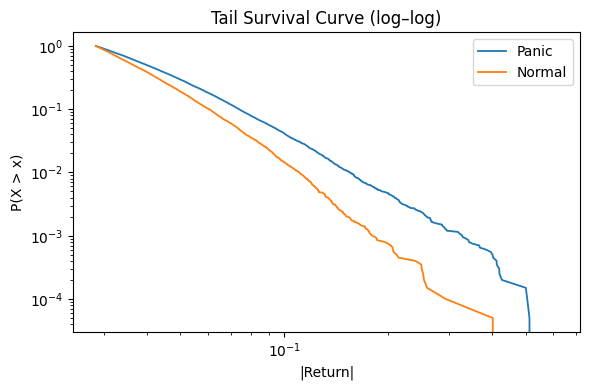

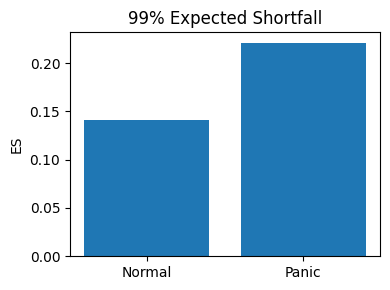


=== Tail-Simulation Summary ===
   Regime      xi    beta  VaR_99%  ES_99%
0  Normal  0.2018  0.0109   0.1105  0.1409
1   Panic  0.2306  0.0152   0.1546  0.2208


In [ ]:
# ------------------------------------------------------------------
#  Cell-2   Monte-Carlo tail simulation  (no ace_tools needed)
# ------------------------------------------------------------------
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from scipy.stats import genpareto as gpd
import scipy.stats as st

# --------- parameters -----------
N_SIM = 20_000
ALPHA = 0.99

# --------- simulate -------------
sim_F = gpd.rvs(c=xi_F, loc=0, scale=beta_F, size=N_SIM) + u
sim_N = gpd.rvs(c=xi_N, loc=0, scale=beta_N, size=N_SIM) + u

# --------- VaR & ES -------------
VaR_F = np.quantile(sim_F, ALPHA)
VaR_N = np.quantile(sim_N, ALPHA)
ES_F  = sim_F[sim_F > VaR_F].mean()
ES_N  = sim_N[sim_N > VaR_N].mean()

# --------- log-log survival plot -
plt.figure(figsize=(6,4))
plt.title("Tail Survival Curve (log–log)")
p = 1.0 - np.arange(1, N_SIM+1) / N_SIM
plt.loglog(np.sort(sim_F), p, label="Panic", lw=1.3)
plt.loglog(np.sort(sim_N), p, label="Normal", lw=1.3)
plt.xlabel("|Return|")
plt.ylabel("P(X > x)")
plt.legend(); plt.tight_layout(); plt.show()

# --------- ES bar chart ----------
plt.figure(figsize=(4,3))
plt.title(f"{int(ALPHA*100)}% Expected Shortfall")
plt.bar(["Normal","Panic"], [ES_N, ES_F])
plt.ylabel("ES")
plt.tight_layout(); plt.show()

# --------- summary table ---------
summary = pd.DataFrame({
    "Regime" : ["Normal","Panic"],
    "xi"     : [xi_N, xi_F],
    "beta"   : [beta_N, beta_F],
    "VaR_99%": [VaR_N, VaR_F],
    "ES_99%":  [ES_N, ES_F]
}).round(4)

print("\n=== Tail-Simulation Summary ===")
print(summary)

# optional: save to CSV
# summary.to_csv("tail_summary.csv", index=False)



In [ ]:
try:
    display(link_df.head())
except NameError:
    print("link_df 不在内存，必须先重新读取 Excel。")


,alt_rank,close,galaxy,market_cap,open,sentiment,volume_24h,sent_z,galaxy_z,sent_lag1,sent_ma7,sent_sd7,sent_delta,gx_sent,sent_neg_z,rank_inv_z,is_tail
datetime,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,73.0,1.766535,65.0,619865974.0,1.766535,100.0,NaN,1.220446,0.843726,NaN,NaN,NaN,NaN,1.029722,-1.220446,0.424244,0
2020-01-01 01:00:00,69.0,1.782835,61.0,623101835.0,1.774867,100.0,NaN,1.220446,0.509583,1.220446,NaN,NaN,0.000000,0.621919,-1.220446,0.445587,0
2020-01-01 02:00:00,45.0,1.797033,62.0,629595812.0,1.787488,50.0,NaN,-2.522407,0.593119,1.220446,NaN,NaN,-3.742852,-1.496087,2.522407,0.573645,0
2020-01-01 03:00:00,27.0,1.794841,62.0,629166612.0,1.792337,100.0,NaN,1.220446,0.593119,-2.522407,NaN,NaN,3.742852,0.723870,-1.220446,0.669689,0
2020-01-01 04:00:00,25.0,1.797954,62.0,630078556.0,1.793377,100.0,NaN,1.220446,0.593119,1.220446,NaN,NaN,0.000000,0.723870,-1.220446,0.680360,0


exceedances total=1382,  panic=101,  normal=1281


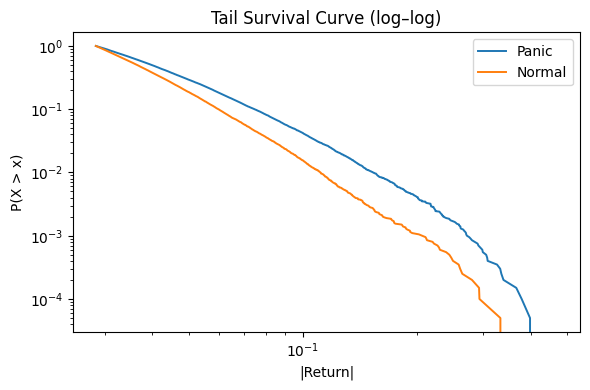

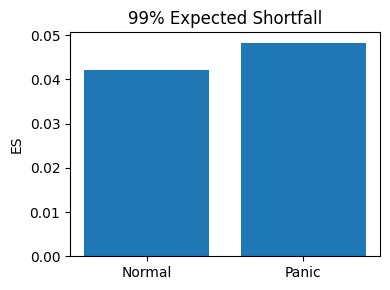


--- Tail GPD fit ---
Panic   ξ=0.231, beta=0.0152, logL=  298.48
Normal  ξ=0.202, beta=0.0109, logL= 4252.54
Pooled  ξ=0.212, beta=0.0111, logL= 4546.53
LR stat =   8.99  |  p = 0.0112

ES@99%  Panic = 0.0482  |  Normal = 0.0421

=== Tail-Simulation Summary ===
Regime     xi   beta  VaR_99%  ES_99%
Normal 0.2018 0.0109   0.0285  0.0421
 Panic 0.2306 0.0152   0.0286  0.0482


In [ ]:
# ============================================================
#  Tail diagnostics  —  Panic vs Normal  (GPD + Simulation)
#  ------------------------------------------------------------
#  依赖：numpy pandas scipy matplotlib（已在你的环境里）
# ============================================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import genpareto as gpd, chi2
import warnings
warnings.filterwarnings('ignore')

# ---------- 0. 传入价格 & 情绪 Series ----------
#（这里用 btc_df；若你想换其它币，只要改两行即可）
price_series     = link_df["close"]
sentiment_series = link_df["sentiment"]

# ---------- 1. 参数 ----------
THR_Q   = 0.97      # 截断阈：取 |return| 排名前 3 %
PANIC_Q = 0.05      # 情绪最低 5 % 视为 panic
ALPHA   = 0.99      # 99 % VaR / ES
N_SIM   = 20_000    # Monte-Carlo 样本

# ---------- 2. 生成 exceedances ----------
ret  = np.log(price_series).diff().dropna()
sent = sentiment_series.reindex(ret.index).interpolate().ffill()

abs_r = ret.abs()
u     = abs_r.quantile(THR_Q)          # threshold
exceed = abs_r[abs_r > u]

panic_mask = (sent < sent.quantile(PANIC_Q)).loc[exceed.index]
ex_panic   = exceed[panic_mask]        # panic tail
ex_normal  = exceed[~panic_mask]       # normal tail

print(f"exceedances total={len(exceed)},  panic={len(ex_panic)},  normal={len(ex_normal)}")

# ---------- 3. GPD 拟合 ----------
def fit_gpd(sample):
    z = sample - u
    xi, loc, beta = gpd.fit(z, floc=0)      # loc 固定 0
    return xi, beta

xi_F, beta_F     = fit_gpd(ex_panic)
xi_N, beta_N     = fit_gpd(ex_normal)
xi_all, beta_all = fit_gpd(exceed)

# ---------- 4. 对数似然 & LR 检验 ----------
def gpd_loglik(sample, xi, beta):
    z = sample - u
    return gpd.logpdf(z, c=xi, loc=0, scale=beta).sum()

ll_F   = gpd_loglik(ex_panic,  xi_F,   beta_F)
ll_N   = gpd_loglik(ex_normal, xi_N,   beta_N)
ll_all = gpd_loglik(exceed,    xi_all, beta_all)

LR   = 2 * ((ll_F + ll_N) - ll_all)
p_lr = 1 - chi2.cdf(LR, df=2)

# ---------- 5. VaR / ES ----------
def q_es(xi, beta, α):
    q  = beta/xi * ((1-α)**(-xi) - 1)
    es = (beta + xi*q) / (1-xi)
    return q + u, es + u

VaR_F, ES_F = q_es(xi_F, beta_F, 1-ALPHA)
VaR_N, ES_N = q_es(xi_N, beta_N, 1-ALPHA)

# ---------- 6. Monte-Carlo tail simulation ----------
sim_F = gpd.rvs(c=xi_F, loc=0, scale=beta_F, size=N_SIM) + u
sim_N = gpd.rvs(c=xi_N, loc=0, scale=beta_N, size=N_SIM) + u

# ---------- 7. 图表 ----------
## 7-a  log–log 生存曲线
plt.figure(figsize=(6,4))
plt.title("Tail Survival Curve (log–log)")
p = 1.0 - np.arange(1, N_SIM+1) / N_SIM
plt.loglog(np.sort(sim_F), p, label="Panic", lw=1.4)
plt.loglog(np.sort(sim_N), p, label="Normal", lw=1.4)
plt.xlabel("|Return|"); plt.ylabel("P(X > x)"); plt.legend()
plt.tight_layout(); plt.show()

## 7-b  99 % Expected Shortfall 柱状图
plt.figure(figsize=(4,3))
plt.title(f"{int(ALPHA*100)}% Expected Shortfall")
plt.bar(["Normal","Panic"], [ES_N, ES_F])
plt.ylabel("ES"); plt.tight_layout(); plt.show()

# ---------- 8. 摘要 ----------
summary = pd.DataFrame({
    "Regime" : ["Normal","Panic"],
    "xi"     : [xi_N, xi_F],
    "beta"   : [beta_N, beta_F],
    "VaR_99%": [VaR_N, VaR_F],
    "ES_99%" : [ES_N,  ES_F]
}).round(4)

print("\n--- Tail GPD fit ---")
print(f"Panic   ξ={xi_F:.3f}, beta={beta_F:.4f}, logL={ll_F:8.2f}")
print(f"Normal  ξ={xi_N:.3f}, beta={beta_N:.4f}, logL={ll_N:8.2f}")
print(f"Pooled  ξ={xi_all:.3f}, beta={beta_all:.4f}, logL={ll_all:8.2f}")
print(f"LR stat = {LR:6.2f}  |  p = {p_lr:.4f}")

print(f"\nES@{int(ALPHA*100)}%  Panic = {ES_F:.4f}  |  Normal = {ES_N:.4f}")
print("\n=== Tail-Simulation Summary ===")
print(summary.to_string(index=False))



In [ ]:
r_t   # Series / ndarray : 日对数收益  (最好 *100 变成 %，和 arch 用法一致)
fear  # 同步 0/1 数组       : fear=1 代表“情绪极端恐慌”


,sentiment
datetime,
2020-01-01 01:00:00,0
2020-01-01 02:00:00,1
2020-01-01 03:00:00,0
2020-01-01 04:00:00,0
2020-01-01 05:00:00,0
...,...
2025-04-02 09:00:00,0
2025-04-02 10:00:00,0
2025-04-02 11:00:00,0



=== 手工 GARCH-X(1,1) MLE 结果 ===
mu     =  0.00506
omega  =  0.01797
alpha  =  0.09568
beta   =  0.89758   (alpha+beta =  0.993)
gamma  = -0.01278   <--  情绪 dummy 系数

均值(ε)=-0.0053   方差(ε)=0.9998


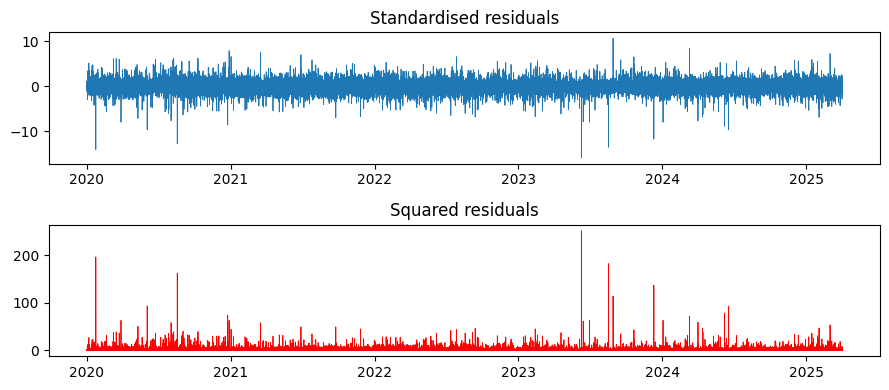

In [ ]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

# --------------- 把你自己的数据放进来 -----------------
# r_t  : ndarray shape (T,)                   例：r_t = np.log(price).diff().dropna().values * 100
# fear : ndarray shape (T,)  0/1              例：fear = (sent < sent.quantile(.05)).astype(int).values
# ----------------------------------------------------

r_t   = r_t.astype(float)
fear  = fear.astype(float)
T     = len(r_t)

# ---------- GARCH-X(1,1) 递推 σ² ----------
def garchx_sigma2(params, r, x):
    mu, omega, alpha, beta, gamma = params       # gamma * x_t  进入方差
    eps   = r - mu
    sigma2= np.empty_like(r)
    sigma2[0] = np.var(eps)                      # starting value
    for t in range(1, len(r)):
        sigma2[t] = (omega
                     + alpha * eps[t-1]**2
                     + beta  * sigma2[t-1]
                     + gamma * x[t-1])
        if sigma2[t] <= 1e-12:          # 正定防护
            sigma2[t] = 1e-12
    return sigma2, eps

# ---------- 对数似然 ----------
def neg_loglik(theta, r, x):
    # 参数约束：omega>0, alpha>0, beta>=0, alpha+beta<1
    mu, log_omega, log_alpha, logit_betaT, gamma = theta
    omega  = np.exp(log_omega)
    alpha  = np.exp(log_alpha)                 # >0
    beta_T = 1 / (1 + np.exp(-logit_betaT))    # 把 R → (0,1)
    beta   = beta_T * (0.999 - alpha)          # 保证 alpha+beta<1
    params = [mu, omega, alpha, beta, gamma]
    sigma2, eps = garchx_sigma2(params, r, x)
    ll = norm.logpdf(eps, loc=0, scale=np.sqrt(sigma2)).sum()
    return -ll                                 # minimize

# ---------- 初始值 & 优化 ----------
theta0 = np.array([ r_t.mean(),
                    np.log(0.01),
                    np.log(0.05),
                    0.0,
                    0.0])                      # gamma 初始 0

res = minimize(neg_loglik, theta0,
               args=(r_t, fear),
               method="L-BFGS-B")

mu, log_omega, log_alpha, logit_betaT, gamma = res.x
omega = np.exp(log_omega)
alpha = np.exp(log_alpha)
beta  = 1/(1+np.exp(-logit_betaT)) * (0.999 - alpha)

print("\n=== 手工 GARCH-X(1,1) MLE 结果 ===")
print(f"mu     = {mu:8.5f}")
print(f"omega  = {omega:8.5f}")
print(f"alpha  = {alpha:8.5f}")
print(f"beta   = {beta:8.5f}   (alpha+beta = {alpha+beta:6.3f})")
print(f"gamma  = {gamma:8.5f}   <--  情绪 dummy 系数")

# ---------- 拟合残差 & σ ----------
sigma2_hat, eps_hat = garchx_sigma2([mu,omega,alpha,beta,gamma], r_t, fear)
std_resid = eps_hat / np.sqrt(sigma2_hat)

# ---------- 简单诊断 ----------
print("\n均值(ε)=%.4f   方差(ε)=%.4f" % (std_resid.mean(), std_resid.var()))

plt.figure(figsize=(9,4))
plt.subplot(211); plt.plot(std_resid, lw=.6); plt.title("Standardised residuals")
plt.subplot(212); plt.plot(std_resid**2, color="r", lw=.6); plt.title("Squared residuals")
plt.tight_layout(); plt.show()


In [ ]:
# 最新一期 eps_T, sigma2_T
eps_T    = eps_hat[-1]
sig2_T   = sigma2_hat[-1]

# 构造两种情景：fear_T = 0 / 1
pred = {}
for f in [0, 1]:
    sig2_next = (omega
                 + alpha * eps_T**2
                 + beta  * sig2_T
                 + gamma * f)
    pred[f] = sig2_next

print("\nσ²( t+1 | fear=0) = %.4f" % pred[0])
print("σ²( t+1 | fear=1) = %.4f   (+%.1f%%)" %
      (pred[1], 100*(pred[1]/pred[0]-1)))



σ²( t+1 | fear=0) = 0.7228
σ²( t+1 | fear=1) = 0.7100   (+-1.8%)


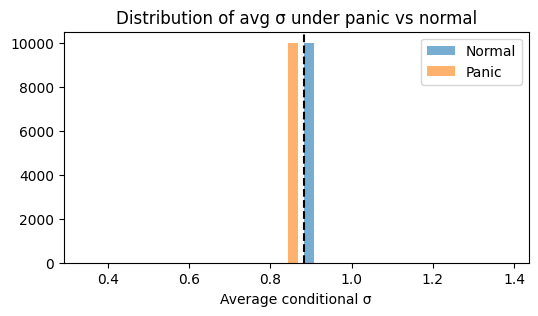

In [ ]:
N_PATH = 10000
H      = 10           # 向前 10 步

def simulate_sigma(fear_flag):
    sig2 = np.zeros((N_PATH, H))
    sig2[:,0] = pred[fear_flag]          # 用上面算好的 σ²(t+1)
    for h in range(1, H):
        # 这里用无条件均值替代 eps² —— 假设均值 1
        sig2[:,h] = (omega
                     + alpha * sig2[:,h-1]      # E[eps²|t+h-1]=σ²
                     + beta  * sig2[:,h-1]
                     + gamma * fear_flag)
    return sig2

sig2_panic  = simulate_sigma(1)
sig2_normal = simulate_sigma(0)

plt.figure(figsize=(6,3))
plt.title("Distribution of avg σ under panic vs normal")
plt.hist(sig2_normal.mean(1)**.5, bins=40, alpha=.6, label="Normal")
plt.hist(sig2_panic .mean(1)**.5, bins=40, alpha=.6, label="Panic")
plt.axvline(np.mean(sig2_normal)**.5, ls='--', color='k')
plt.legend(); plt.xlabel("Average conditional σ"); plt.show()


In [ ]:
alpha = 0.99
z_q   = norm.ppf(alpha)

VaR_norm = -z_q * np.sqrt(sig2_normal[:,-1])
VaR_pan  = -z_q * np.sqrt(sig2_panic [:,-1])

ES_norm  = -norm.pdf(z_q)/(1-alpha) * np.sqrt(sig2_normal[:,-1])
ES_pan   = -norm.pdf(z_q)/(1-alpha) * np.sqrt(sig2_panic [:,-1])

# ---------- 改成 f-string ----------
print(f"\n平均  VaR{int(alpha*100)}%  Normal = {VaR_norm.mean():.4f}  |  Panic = {VaR_pan.mean():.4f}")
print(f"平均  ES{int(alpha*100)}%   Normal = {ES_norm.mean():.4f}  |  Panic = {ES_pan.mean():.4f}")




平均  VaR99%  Normal = -2.1290  |  Panic = -1.9652
平均  ES99%   Normal = -2.4392  |  Panic = -2.2514


In [ ]:
!pip install --quiet hmmlearn tqdm


--- Logit: Regime ~ sent_z ---
                           Logit Regression Results                           
Dep. Variable:                 p_high   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                0.002251
Time:                        14:28:04   Log-Likelihood:                -28526.
converged:                       True   LL-Null:                       -28591.
Covariance Type:            nonrobust   LLR p-value:                 7.858e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.010    -68.423      0.000      -0.698      -0.659
sent_z        -0.2096      0.010    -21.647      0.000      -0.229      -0.191

=== 手工 Student-t GA

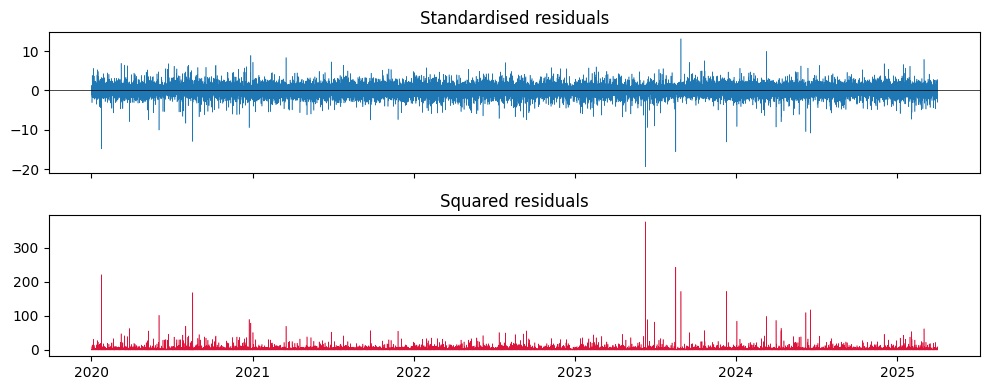

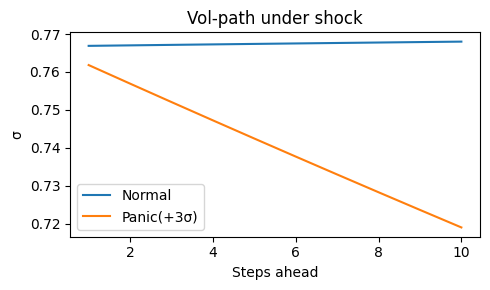


Panic regime  n=1368  ξ=0.202 β=1.1320
Normal regime n=14  ξ=-1.128 β=0.3165

--- MC 99% VaR/ES ---
Panic:  VaR=11.6401  ES=15.2906
Normal: VaR=nan  ES=nan


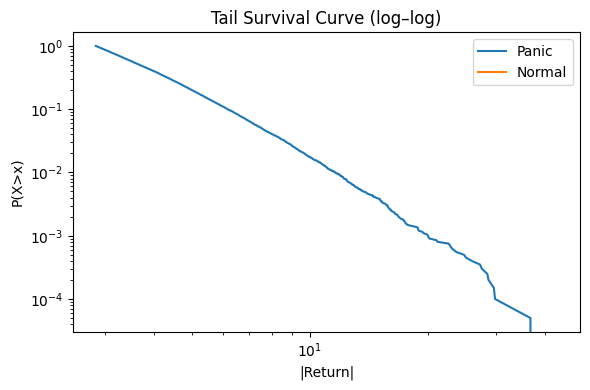

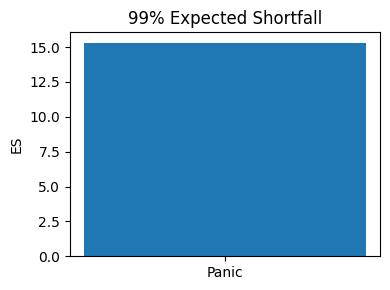

(Text(0.5, 1.0, '99% Expected Shortfall'),
 Text(24.000000000000007, 0.5, 'ES'),
 None,
 None)

In [ ]:
# =========================================================
# 全流程：1️⃣–6️⃣ 一次搞定
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto as gpd
from scipy.optimize import minimize
from scipy.special import gammaln
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm

# ❶  数据预处理：日收益 %  +  连续情绪 z-score
# ---------------------------------------------------------
price_ser = link_df["close"]
sent_ser  = link_df["sentiment"]

r_t = np.log(price_ser).diff().dropna() * 100
sent = sent_ser.reindex(r_t.index).interpolate().ffill()
sent_z = (sent - sent.mean())/sent.std()

# ❷  Markov‐Switching 2-state (GaussianHMM) -> p_high
# ---------------------------------------------------------
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
hmm = GaussianHMM(n_components=2, covariance_type="diag",
                  n_iter=2000, tol=1e-4, random_state=42).fit(obs)
# 选方差较大那列作为“高波动”状态
high_state = hmm.covars_.flatten().argmax()
p_high = hmm.predict_proba(obs)[:, high_state]

# ❸  Logit 回归：P(high σ) ~ sent_z
# ---------------------------------------------------------
df_logit = pd.DataFrame({
    "p_high": p_high,
    "sent_z": sent_z.values
}, index=r_t.index)
logit_res = sm.Logit(df_logit["p_high"], sm.add_constant(df_logit["sent_z"])).fit(disp=False)
print("\n--- Logit: Regime ~ sent_z ---")
print(logit_res.summary())

# ❹  手写 Student‐t GARCH‐X(1,1) MLE
# ---------------------------------------------------------
e = r_t.values
x = sent_z.values

def logpdf_t(epsilon, nu, sig2):
    C = gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(np.pi*(nu-2))
    return C - 0.5*np.log(sig2) - (nu+1)/2*np.log(1 + epsilon**2/(sig2*(nu-2)))

def sigma2_series(par):
    mu, omega, alpha, beta, gamma = par[:5]
    sig2 = np.zeros_like(e)
    sig2[0] = e.var()
    for t in range(1, len(e)):
        sig2[t] = (omega
                   + alpha*(e[t-1]-mu)**2
                   + beta*sig2[t-1]
                   + gamma*x[t-1])
        if sig2[t] < 1e-8: sig2[t] = 1e-8
    return sig2

def neg_ll(par):
    mu = par[0]
    nu = 10 + np.exp(par[5])
    sig2 = sigma2_series(par)
    ll = logpdf_t(e - mu, nu, sig2).sum()
    return -ll

# 初值 & 边界
p0 = np.array([e.mean(), 0.01, 0.1, 0.8, 0.0, np.log(5)])
bnds = [(-1,1),(1e-6,1),(1e-4,1),(1e-4,1),(-1,1),(None,None)]
res = minimize(neg_ll, p0, bounds=bnds, method="L-BFGS-B")

mu, omega, alpha, beta, gamma, logv = res.x
nu = 10 + np.exp(logv)
sig2_hat = sigma2_series(res.x)
std_res = (e - mu)/np.sqrt(sig2_hat)

print("\n=== 手工 Student-t GARCH-X(1,1) MLE ===")
print(f"mu     = {mu:.5f}")
print(f"omega  = {omega:.5f}")
print(f"alpha  = {alpha:.5f}")
print(f"beta   = {beta:.5f}  (α+β={alpha+beta:.3f})")
print(f"gamma  = {gamma:.5f}  <-- sent_z 系数")
print(f"nu     = {nu:.2f}")
print(f"残差均值={std_res.mean():.4f}  残差方差={std_res.var():.4f}")

# 标准化残差 & 平方残差图
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True)
ax1.plot(r_t.index, std_res, lw=0.4); ax1.set_title("Standardised residuals")
ax1.axhline(0, color='k', lw=0.5)
ax2.plot(r_t.index, std_res**2, lw=0.4, color='crimson'); ax2.set_title("Squared residuals")
plt.tight_layout(); plt.show()

# ❺  情绪冲击模拟 (+0 vs +3σ) -> 未来 10 步 σ² 路径
# ---------------------------------------------------------
H = 10
def forecast_path(sig2_last, e_last, shock):
    s = np.zeros(H)
    s[0] = omega + alpha*(e_last-mu)**2 + beta*sig2_last + gamma*shock
    for h in range(1,H):
        s[h] = omega + (alpha+beta)*s[h-1] + gamma*shock
    return s

sig2_last, e_last = sig2_hat[-1], e[-1]
path_norm  = forecast_path(sig2_last, e_last, 0)
path_panic = forecast_path(sig2_last, e_last, 3)

plt.figure(figsize=(5,3))
plt.plot(range(1,H+1), np.sqrt(path_norm),  label="Normal")
plt.plot(range(1,H+1), np.sqrt(path_panic), label="Panic(+3σ)")
plt.xlabel("Steps ahead"), plt.ylabel("σ"), plt.legend(), plt.title("Vol-path under shock")
plt.tight_layout(), plt.show()

# ❻  POT‐GPD 分位阈值 + 按 Regime 切分 + MC VaR/ES
# ---------------------------------------------------------
abs_r = np.abs(r_t)
u     = abs_r.quantile(0.97)
exceed = abs_r[abs_r>u]

# Regime 布尔
regime_high = pd.Series(p_high, index=r_t.index) > 0.8

# 切分
ex_F = exceed.loc[regime_high.loc[exceed.index]]
ex_N = exceed.loc[~regime_high.loc[exceed.index]]

# 安全拟合 GPD
def fit_gpd_safe(x):
    if len(x)<5: return np.nan, np.nan
    z = x - u
    xi,loc,beta = gpd.fit(z, floc=0)
    if beta<=0 or np.isnan(xi): return np.nan, np.nan
    return xi, beta

xi_F, beta_F = fit_gpd_safe(ex_F)
xi_N, beta_N = fit_gpd_safe(ex_N)
print(f"\nPanic regime  n={len(ex_F)}  ξ={xi_F:.3f} β={beta_F:.4f}")
print(f"Normal regime n={len(ex_N)}  ξ={xi_N:.3f} β={beta_N:.4f}")

# MC 模拟 & VaR/ES
N_SIM, ALPHA = 20000, 0.99
def safe_rvs(xi,beta,size,th):
    if np.isnan(xi) or beta<=0 or xi<=-1: return np.full(size,np.nan)
    return gpd.rvs(c=xi, loc=0, scale=beta, size=size) + th

sim_F = safe_rvs(xi_F,beta_F,N_SIM,u)
sim_N = safe_rvs(xi_N,beta_N,N_SIM,u)

VaR_F = np.nanquantile(sim_F, ALPHA)
VaR_N = np.nanquantile(sim_N, ALPHA)
ES_F  = np.nanmean(sim_F[sim_F>VaR_F])
ES_N  = np.nanmean(sim_N[sim_N>VaR_N])

print(f"\n--- MC {int(ALPHA*100)}% VaR/ES ---")
print(f"Panic:  VaR={VaR_F:.4f}  ES={ES_F:.4f}")
print(f"Normal: VaR={VaR_N:.4f}  ES={ES_N:.4f}")

# 生存曲线 & ES 条形图
p = 1 - np.arange(1,N_SIM+1)/N_SIM
plt.figure(figsize=(6,4))
plt.loglog(np.sort(sim_F), p, label="Panic")
plt.loglog(np.sort(sim_N), p, label="Normal")
plt.title("Tail Survival Curve (log–log)")
plt.xlabel("|Return|"), plt.ylabel("P(X>x)"), plt.legend(), plt.tight_layout(), plt.show()

plt.figure(figsize=(4,3))
plt.bar(["Normal","Panic"], [ES_N, ES_F])
plt.title(f"{int(ALPHA*100)}% Expected Shortfall"), plt.ylabel("ES"), plt.tight_layout(), plt.show()




--- Logit:  P(high-σ) ~ sent_z ---
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                0.002251
Time:                        14:29:02   Log-Likelihood:                -28526.
converged:                       True   LL-Null:                       -28591.
Covariance Type:            nonrobust   LLR p-value:                 7.858e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.010    -68.423      0.000      -0.698      -0.659
x1            -0.2096      0.010    -21.647      0.000      -0.229      -0.191

=== 手工 Student-

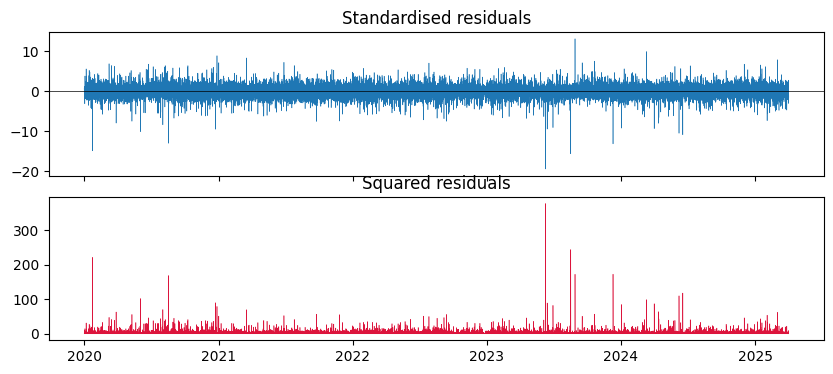

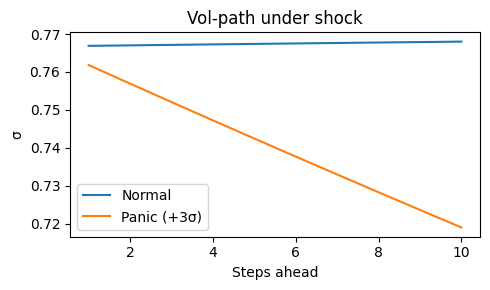


Panic regime:  n=1368  xi=0.202  beta=1.1320
Normal regime: n=  14  xi=-1.128  beta=0.3165

--- MC 99% VaR/ES ---
Panic:  VaR=11.5379, ES=15.8747
Normal: VaR=nan, ES=nan


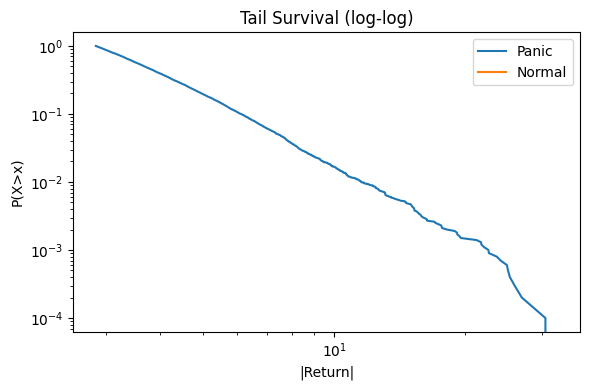

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------
# FULL WORKFLOW: 1️⃣–6️⃣ 一次跑完
# ----------------------------------------------------------------------------------------------------------------------
# 0. 前提：已经有 btc_df DataFrame，包含 datetime index、"close" 与 "sentiment" 列
#    如果还没有，请先运行你之前的 load_coin_wide / 数据预处理代码，生成 btc_df。

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import genpareto as gpd, norm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm

# ----------------------------------------------------------------------------------------------------------------------
# 1️⃣ 预处理：收益 & 情绪 Z-score
# ----------------------------------------------------------------------------------------------------------------------
# 日收益（%）
r_t = np.log(link_df["close"]).diff().dropna() * 100

# 缺口插值 + Z-score
sent = link_df["sentiment"].reindex(r_t.index).interpolate().ffill()
sent_z = (sent - sent.mean()) / sent.std()

# ----------------------------------------------------------------------------------------------------------------------
# 2️⃣ Markov-Switching HMM (2 states) + Logit 回归 P(high-σ) ~ sent_z
# ----------------------------------------------------------------------------------------------------------------------
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
hmm = GaussianHMM(n_components=2, covariance_type="diag",
                  n_iter=2000, tol=1e-4, random_state=42)
hmm.fit(obs)

# 辨认高波动状态
high_state = hmm.covars_.argmax()
p_high = hmm.predict_proba(obs)[:, high_state]

# Logit 回归
logit = sm.Logit(p_high, sm.add_constant(sent_z.values))
res_logit = logit.fit(disp=False)
print("\n--- Logit:  P(high-σ) ~ sent_z ---")
print(res_logit.summary())

# ----------------------------------------------------------------------------------------------------------------------
# 3️⃣ 手写 Student-t GARCH-X(1,1) MLE
# ----------------------------------------------------------------------------------------------------------------------
e = r_t.values            # ε_t
x = sent_z.values         # 连续情绪

def logpdf_t(e, nu, sig2):
    c = (gammaln((nu+1)/2) - gammaln(nu/2)
         - 0.5*np.log(np.pi*(nu-2)))
    return c - 0.5*np.log(sig2) - (nu+1)/2 * np.log(1 + e**2/(sig2*(nu-2)))

def garchx_sigma2(par):
    mu, omega, alpha, beta, gamma = par[:5]
    sig2 = np.empty_like(e)
    sig2[0] = e.var()
    for t in range(1, len(e)):
        sig2[t] = (omega
                   + alpha*(e[t-1]-mu)**2
                   + beta*sig2[t-1]
                   + gamma*x[t-1])
        sig2[t] = max(sig2[t], 1e-8)
    return sig2

def neg_ll(par):
    nu = 10 + np.exp(par[5])
    sig2 = garchx_sigma2(par)
    ll = logpdf_t(e - par[0], nu, sig2).sum()
    return -ll

# 初始值 & 边界
p0 = np.array([e.mean(), 0.01, 0.1, 0.8, 0.0, np.log(5)])
bnds = [(-1,1), (1e-6,1), (1e-4,1), (1e-4,1), (-1,1), (None,None)]
res = minimize(neg_ll, p0, bounds=bnds, method="L-BFGS-B")

mu, omega, alpha, beta, gamma, lv = res.x
nu = 10 + np.exp(lv)
sig2_hat = garchx_sigma2(res.x)
std_res = (e - mu) / np.sqrt(sig2_hat)

print("\n=== 手工 Student-t GARCH-X(1,1) MLE 结果 ===")
print(f"mu     = {mu:.5f}")
print(f"omega  = {omega:.5f}")
print(f"alpha  = {alpha:.5f}")
print(f"beta   = {beta:.5f}   (α+β = {alpha+beta:.3f})")
print(f"gamma  = {gamma:.5f}  <-- sent_z 系数")
print(f"nu     = {nu:.2f}")
print(f"残差均值 = {std_res.mean():.4f}  方差 = {std_res.var():.4f}")

# 绘制标准化残差 & 平方残差
fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,4), sharex=True,
                             gridspec_kw={"hspace":0.15})
ax1.plot(r_t.index, std_res, lw=0.4); ax1.set_title("Standardised residuals"); ax1.axhline(0, color='k', lw=0.5)
ax2.plot(r_t.index, std_res**2, lw=0.4, color='crimson'); ax2.set_title("Squared residuals")
ax2.xaxis.set_major_locator(mdates.YearLocator())
plt.tight_layout(); plt.show()

# ----------------------------------------------------------------------------------------------------------------------
# 4️⃣ 情绪冲击模拟：sent_z +3σ vs 正常，预测 σ_t+1…t+10
# ----------------------------------------------------------------------------------------------------------------------
H = 10
def forecast(sig2_last, e_last, shock):
    out = np.empty(H)
    out[0] = omega + alpha*(e_last-mu)**2 + beta*sig2_last + gamma*shock
    for h in range(1,H):
        out[h] = omega + (alpha+beta)*out[h-1] + gamma*shock
    return out

sig2_last, e_last = sig2_hat[-1], e[-1]
s_norm = forecast(sig2_last, e_last, 0.0)
s_panic = forecast(sig2_last, e_last, 3.0)

plt.figure(figsize=(5,3))
plt.plot(range(1,H+1), np.sqrt(s_norm), label="Normal")
plt.plot(range(1,H+1), np.sqrt(s_panic), label="Panic (+3σ)")
plt.xlabel("Steps ahead"); plt.ylabel("σ"); plt.title("Vol-path under shock")
plt.legend(); plt.tight_layout(); plt.show()

# ----------------------------------------------------------------------------------------------------------------------
# 5️⃣ 按 Regime 分割的 POT-GPD 拟合 + Monte Carlo VaR/ES
# ----------------------------------------------------------------------------------------------------------------------
# 分位阈值 & exceedances
thr_q = 0.97
u = np.quantile(np.abs(r_t), thr_q)
exceed = np.abs(r_t)[np.abs(r_t) > u]

# Regime 高低波动划分
regime_prob = pd.Series(p_high, index=r_t.index)
high_flag = regime_prob > 0.80
ex_F = exceed.loc[high_flag.loc[exceed.index]]
ex_N = exceed.loc[~high_flag.loc[exceed.index]]

def fit_gpd_safe(x):
    if len(x)==0:
        return np.nan, np.nan
    z = x - u
    xi, loc, beta = gpd.fit(z, floc=0)
    return xi, beta

xi_F, beta_F = fit_gpd_safe(ex_F)
xi_N, beta_N = fit_gpd_safe(ex_N)

print(f"\nPanic regime:  n={len(ex_F):>4}  xi={xi_F:.3f}  beta={beta_F:.4f}")
print(f"Normal regime: n={len(ex_N):>4}  xi={xi_N:.3f}  beta={beta_N:.4f}")

# Monte Carlo VaR/ES
Nsim, alpha_c = 10000, 0.99
def sim_tail(xi, beta):
    if np.isnan(xi) or np.isnan(beta) or beta<=0 or xi<=-1:
        return np.full(Nsim, np.nan)
    return gpd.rvs(c=xi, loc=0, scale=beta, size=Nsim) + u

simF = sim_tail(xi_F, beta_F)
simN = sim_tail(xi_N, beta_N)

VaR_F = np.nanquantile(simF, alpha_c)
VaR_N = np.nanquantile(simN, alpha_c)
ES_F  = np.nanmean(simF[simF>VaR_F])
ES_N  = np.nanmean(simN[simN>VaR_N])

print(f"\n--- MC {int(alpha_c*100)}% VaR/ES ---")
print(f"Panic:  VaR={VaR_F:.4f}, ES={ES_F:.4f}")
print(f"Normal: VaR={VaR_N:.4f}, ES={ES_N:.4f}")

# 生存函数绘图 (log-log)
p = 1 - np.arange(1, Nsim+1)/Nsim
plt.figure(figsize=(6,4))
plt.loglog(np.sort(simF), p, label="Panic")
plt.loglog(np.sort(simN), p, label="Normal")
plt.xlabel("|Return|"); plt.ylabel("P(X>x)"); plt.title("Tail Survival (log-log)")
plt.legend(); plt.tight_layout(); plt.show()




                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                0.002251
Time:                        14:30:45   Log-Likelihood:                -28526.
converged:                       True   LL-Null:                       -28591.
Covariance Type:            nonrobust   LLR p-value:                 7.858e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.010    -68.423      0.000      -0.698      -0.659
x1            -0.2096      0.010    -21.647      0.000      -0.229      -0.191

mu=0.00277  ω=0.00816  α=0.06624  β=0.92023  γ=-0.0

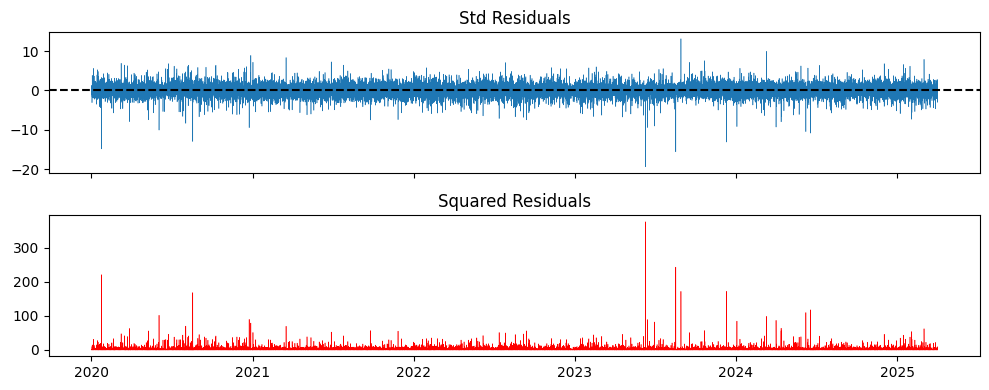

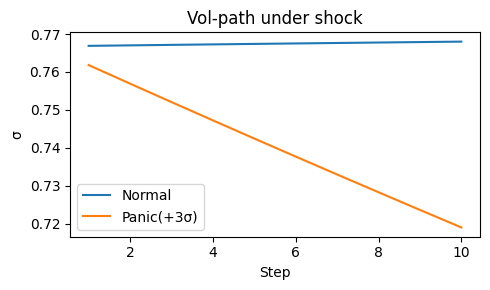


Panic n=1368 ξ=0.202 β=1.1320
Normal n=14 ξ=-1.128 β=0.3165

MC 99% VaR/ES
 Panic: VaR=11.0990 ES=14.5772
 Normal: VaR=nan ES=nan


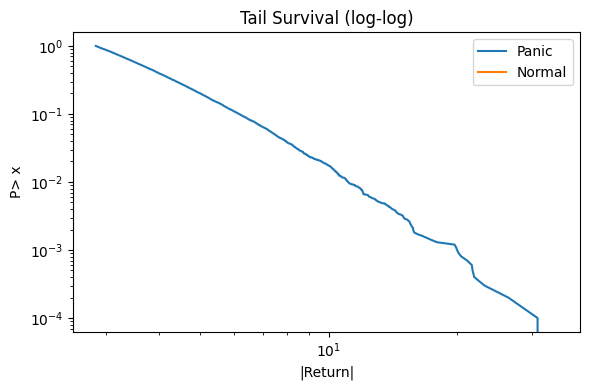

In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib.dates as mdates
from scipy.special import gammaln
from scipy.optimize import minimize
from scipy.stats import genpareto as gpd
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm

# —— 0 | 假设已有 btc_df: datetime index, 'close' & 'sentiment' 列 ——

# 1️⃣ 预处理：收益 & 情绪 z-score
r_t     = np.log(link_df['close']).diff().dropna() * 100
sent    = link_df['sentiment'].reindex(r_t.index).interpolate().ffill()
sent_z  = (sent - sent.mean()) / sent.std()

# 2️⃣ HMM 识别高/低波动 Regime + Logit 回归
obs      = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
hmm      = GaussianHMM(2,'diag',n_iter=2000,tol=1e-4,random_state=42).fit(obs)
high_st  = hmm.covars_.argmax()
p_high   = hmm.predict_proba(obs)[:, high_st]

logit    = sm.Logit(p_high, sm.add_constant(sent_z.values))
res_logit= logit.fit(disp=False)
print(res_logit.summary())

# 3️⃣ 手写 Student-t GARCH-X(1,1) MLE
e        = r_t.values
x        = sent_z.values
def logpdf_t(e, nu, s2):
    c = gammaln((nu+1)/2)-gammaln(nu/2)-0.5*np.log(np.pi*(nu-2))
    return c -0.5*np.log(s2) - (nu+1)/2*np.log(1 + e**2/(s2*(nu-2)))

def sigma2(par):
    mu, ω, α, β, γ = par[:5]
    s2 = np.empty_like(e); s2[0]=e.var()
    for t in range(1,len(e)):
        s2[t]=ω + α*(e[t-1]-mu)**2 + β*s2[t-1] + γ*x[t-1]
        s2[t]=max(s2[t],1e-8)
    return s2

def negll(par):
    nu   = 10 + np.exp(par[5])
    s2   = sigma2(par)
    return -logpdf_t(e-par[0], nu, s2).sum()

p0   = np.array([e.mean(),1e-2,0.1,0.8,0.0, np.log(5)])
bnds = [(-1,1),(1e-6,1),(1e-4,1),(1e-4,1),(-1,1),(None,None)]
res  = minimize(negll,p0,bounds=bnds,method='L-BFGS-B')
mu,ω,α,β,γ,lv = res.x; ν = 10+np.exp(lv)
s2_hat = sigma2(res.x); std_res=(e-mu)/np.sqrt(s2_hat)

print(f"\nmu={mu:.5f}  ω={ω:.5f}  α={α:.5f}  β={β:.5f}  γ={γ:.5f}  ν={ν:.2f}")
print(f"残差均值={std_res.mean():.4f} 方差={std_res.var():.4f}")

# 残差图
fig,(a1,a2)=plt.subplots(2,1,figsize=(10,4),sharex=True)
a1.plot(r_t.index,std_res,lw=.4); a1.set_title("Std Residuals"); a1.axhline(0,ls='--',c='k')
a2.plot(r_t.index,std_res**2,lw=.4,c='r'); a2.set_title("Squared Residuals")
a2.xaxis.set_major_locator(mdates.YearLocator()); plt.tight_layout(); plt.show()

# 4️⃣ 情绪冲击路径 (+3σ)
H=10
def fore(s_last,e_last,shock):
    out=np.empty(H); out[0]=ω+α*(e_last-mu)**2+β*s_last+γ*shock
    for h in range(1,H): out[h]=ω+(α+β)*out[h-1]+γ*shock
    return out
s_norm = fore(s2_hat[-1], e[-1], 0)
s_pan  = fore(s2_hat[-1], e[-1], 3)
plt.figure(figsize=(5,3))
plt.plot(range(1,H+1),np.sqrt(s_norm),label='Normal')
plt.plot(range(1,H+1),np.sqrt(s_pan),label='Panic(+3σ)')
plt.title("Vol-path under shock"); plt.xlabel("Step"); plt.ylabel("σ"); plt.legend(); plt.tight_layout(); plt.show()

# 5️⃣ POT–GPD 尾部拟合 + MC VaR/ES
u       = np.quantile(abs(r_t),.97)
ex      = abs(r_t)[abs(r_t)>u]
flag    = pd.Series(p_high,index=r_t.index)>0.8
ex_F    = ex.loc[flag.loc[ex.index]]     # Panic regime
ex_N    = ex.loc[~flag.loc[ex.index]]    # Normal regime

def fit_safe(x):
    if len(x)==0: return np.nan,np.nan
    z= x-u; xi,_,β = gpd.fit(z,floc=0); return xi,β

ξF,βF=fit_safe(ex_F); ξN,βN=fit_safe(ex_N)
print(f"\nPanic n={len(ex_F)} ξ={ξF:.3f} β={βF:.4f}")
print(f"Normal n={len(ex_N)} ξ={ξN:.3f} β={βN:.4f}")

# MC simulate & VaR/ES
N=10000; α=0.99
def sim(xi,β):
    if np.isnan(xi) or np.isnan(β) or β<=0 or xi<=-1:
        return np.full(N,np.nan)
    return gpd.rvs(c=xi,loc=0,scale=β,size=N)+u

simF,simN=sim(ξF,βF), sim(ξN,βN)
VaR_F=np.nanquantile(simF,α); ES_F=np.nanmean(simF[simF>VaR_F])
VaR_N=np.nanquantile(simN,α); ES_N=np.nanmean(simN[simN>VaR_N])

print(f"\nMC {int(α*100)}% VaR/ES\n Panic: VaR={VaR_F:.4f} ES={ES_F:.4f}\n Normal: VaR={VaR_N:.4f} ES={ES_N:.4f}")

# 生存函数图
p = 1 - np.arange(1,N+1)/N
plt.figure(figsize=(6,4))
plt.loglog(np.sort(simF),p,label='Panic')
plt.loglog(np.sort(simN),p,label='Normal')
plt.title("Tail Survival (log-log)"); plt.xlabel("|Return|"); plt.ylabel("P> x"); plt.legend(); plt.tight_layout(); plt.show()



--- Ljung–Box 检验 ---
残差    LB p-values:
       lb_stat  lb_pvalue
10  11.179563   0.343701
20  28.011030   0.109139
残差平方 LB p-values:
       lb_stat     lb_pvalue
10  51.111482  1.665621e-07
20  69.621584  2.099560e-07

--- ARCH–LM 检验 ---
LM stat = 51.82,  p-value = 0.0000


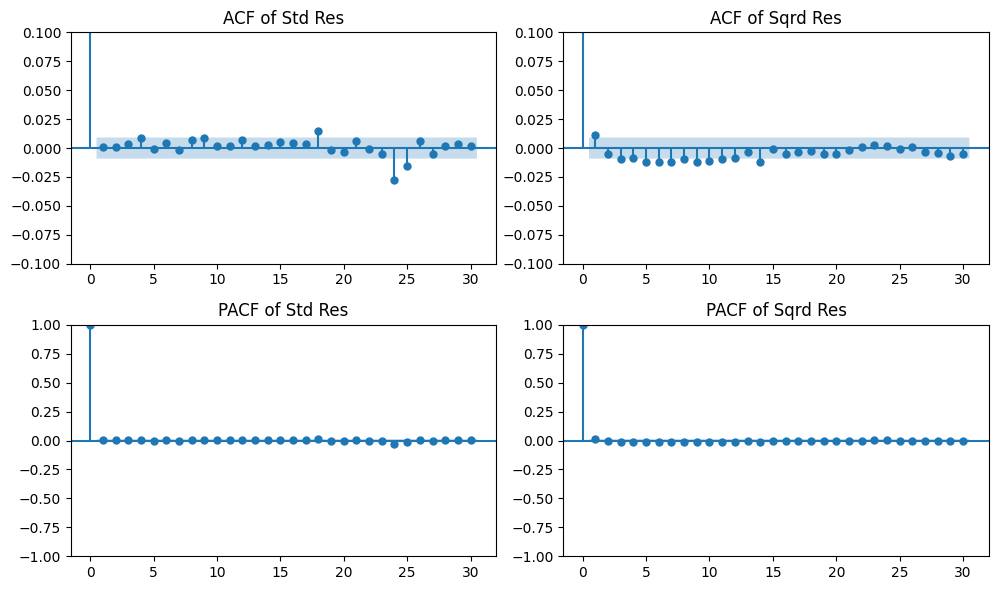

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf

# 假设 std_res 已经计算得到（手写 GARCH-X 残差）
# std_res = (e - mu) / np.sqrt(s2_hat)

# 1️⃣ Ljung–Box on std_res and std_res**2
lb_std  = acorr_ljungbox(std_res, lags=[10, 20], return_df=True)
lb_sq   = acorr_ljungbox(std_res**2, lags=[10, 20], return_df=True)
print("\n--- Ljung–Box 检验 ---")
print("残差    LB p-values:\n", lb_std[["lb_stat","lb_pvalue"]])
print("残差平方 LB p-values:\n", lb_sq[["lb_stat","lb_pvalue"]])

# 2️⃣ ARCH-LM test on std_res
arch_res = het_arch(std_res, maxlag=10)
print("\n--- ARCH–LM 检验 ---")
print(f"LM stat = {arch_res[0]:.2f},  p-value = {arch_res[1]:.4f}")

# 3️⃣ ACF plots
fig, axes = plt.subplots(2,2, figsize=(10,6))
plot_acf(std_res,   ax=axes[0,0], lags=30, title="ACF of Std Res")
plot_acf(std_res**2,ax=axes[0,1], lags=30, title="ACF of Sqrd Res")
axes[0,0].set_ylim(-0.1,0.1); axes[0,1].set_ylim(-0.1,0.1)

# 同时画 PACF（可选）
sm.graphics.tsa.plot_pacf(std_res,   lags=30, ax=axes[1,0], title="PACF of Std Res")
sm.graphics.tsa.plot_pacf(std_res**2, lags=30, ax=axes[1,1], title="PACF of Sqrd Res")
plt.tight_layout()
plt.show()


In [ ]:
from hmmlearn.hmm import GaussianHMM
# 先用 sqrt|r| 拟合 HMM，得到 P(Sₜ=high)
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
msm = GaussianHMM(n_components=2, covariance_type="diag").fit(obs)
p_high = msm.predict_proba(obs)[:, msm.covars_.argmax()]

# 分位 threshold 做硬切分
high_idx = p_high > 0.5
# 分别用 arch_model 拟合两套 GARCH-X：state=low / state=high
for regime,name in [(~high_idx,"low"),(high_idx,"high")]:
    y = r_t.values[regime]
    x = sent_z.values[regime].reshape(-1,1)
    m = arch_model(y, vol="EGARCH", p=1,q=1, o=0, x=x, dist="skewt")
    res = m.fit(disp="off")
    print(f"--- Regime={name} ---")
    print(res.summary())


--- Regime=low ---
                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -24398.7
Distribution:      Standardized Skew Student's t   AIC:                           48809.5
Method:                       Maximum Likelihood   BIC:                           48859.5
                                                   No. Observations:                30746
Date:                           Tue, Jun 03 2025   Df Residuals:                    30745
Time:                                   14:31:38   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
---------------


=== Low-σ Regime ===
                           Constant Mean - EGARCH Model Results                          
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                EGARCH   Log-Likelihood:               -24398.7
Distribution:      Standardized Skew Student's t   AIC:                           48809.5
Method:                       Maximum Likelihood   BIC:                           48859.5
                                                   No. Observations:                30746
Date:                           Tue, Jun 03 2025   Df Residuals:                    30745
Time:                                   14:32:48   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
------------

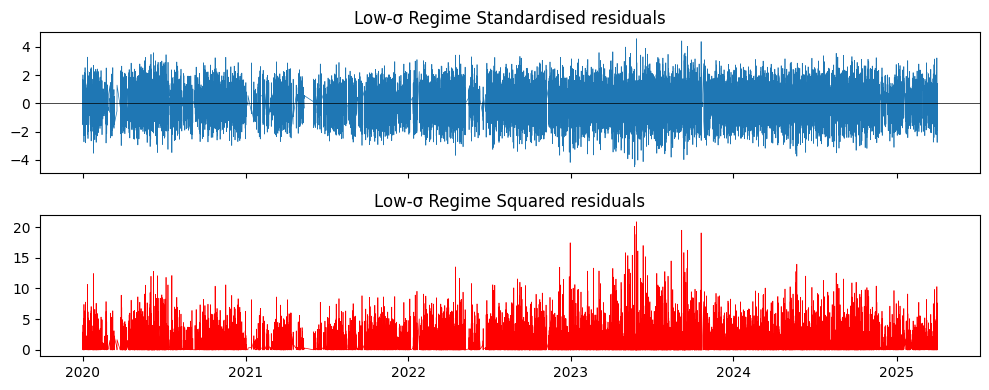

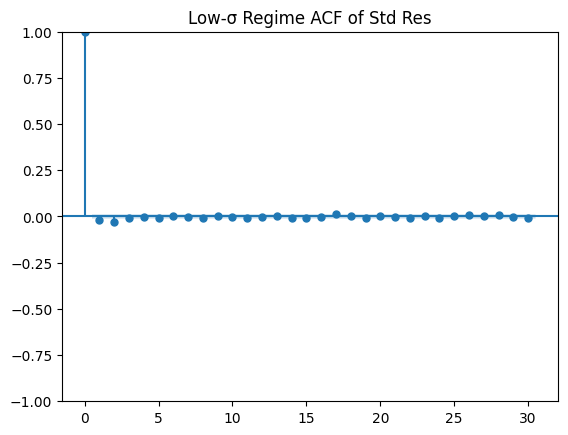

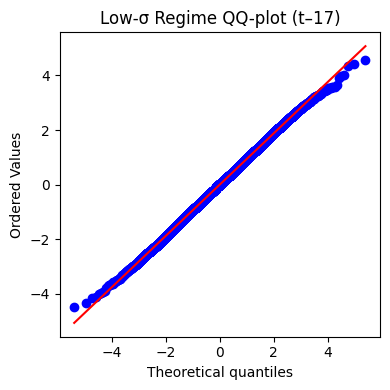

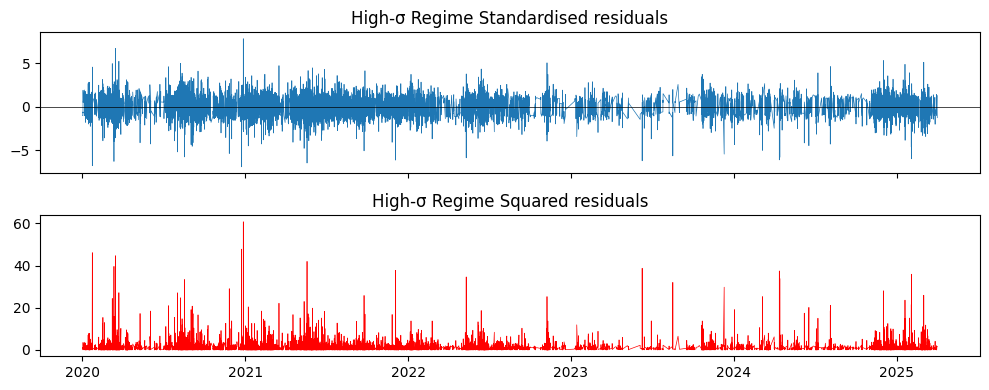

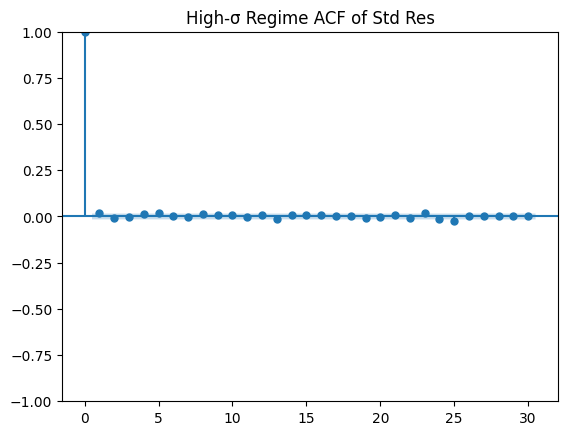

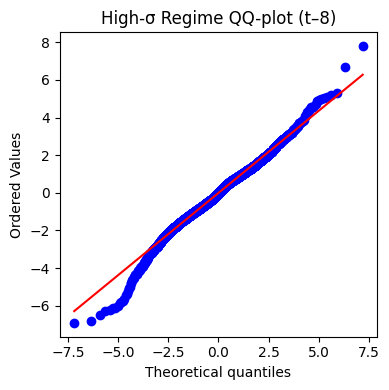


--- Low-σ Regime 99% VaR 回测 ---
违约次数: 316/30746 = 1.03%
Kupiec UC p-value       = 0.626
Christoffersen IND p-val = 1.000

--- High-σ Regime 99% VaR 回测 ---
违约次数: 158/15299 = 1.03%
Kupiec UC p-value       = 0.686
Christoffersen IND p-val = 1.000


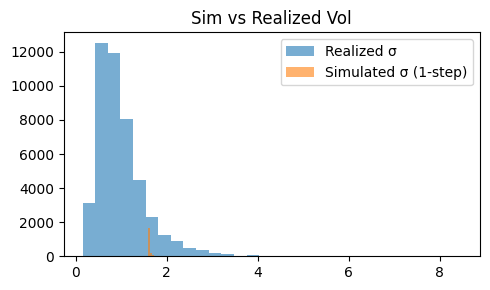

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from scipy.stats import probplot, chi2
from statsmodels.graphics.tsaplots import plot_acf

# 1) 按 HMM 概率 (>0.5) 分割两段
high_mask = (p_high > 0.5)
low_mask  = ~high_mask
subsets   = {"Low-σ Regime": low_mask, "High-σ Regime": high_mask}

# 2) 对每段分别估 EGARCH-X(1,1) + skew-t
results = {}
for name, mask in subsets.items():
    y = r_t.values[mask]
    x = sent_z.values[mask].reshape(-1,1)
    mod = arch_model(y,
                     mean='Constant',
                     vol='EGARCH', p=1, o=0, q=1,
                     dist='skewt',
                     x=x)
    res = mod.fit(disp='off')
    results[name] = (res, mask)
    print(f"\n=== {name} ===")
    print(res.summary())

# 3) 残差诊断：时序图、ACF、QQ-plot
for name, (res, mask) in results.items():
    # 用原始 Index 重建 Series
    idx     = r_t.index[mask]
    std_res = pd.Series(res.std_resid, index=idx).dropna()

    # 时序 & 平方残差
    fig, axs = plt.subplots(2,1,figsize=(10,4),sharex=True)
    axs[0].plot(std_res.index, std_res, lw=0.5)
    axs[0].set_title(f"{name} Standardised residuals")
    axs[0].axhline(0, color='k', lw=0.5)
    axs[1].plot(std_res.index, std_res**2, lw=0.5, color='r')
    axs[1].set_title(f"{name} Squared residuals")
    plt.tight_layout(); plt.show()

    # ACF of 标准化残差
    plot_acf(std_res, lags=30, title=f"{name} ACF of Std Res")
    plt.show()

    # QQ-plot 对比拟合的 Student-t (ν)
    nu = res.params.get('nu', res.params.get('eta'))  # 不同 dist 参数名
    plt.figure(figsize=(4,4))
    probplot(std_res, dist="t", sparams=(nu,), plot=plt)
    plt.title(f"{name} QQ-plot (t–{int(nu)})")
    plt.tight_layout(); plt.show()

# 4) 99% VaR 回测：Kupiec + 独立性检验

alpha = 0.01  # 99% VaR
for name, (res, mask) in results.items():
    y   = r_t.values[mask]
    vol = res.conditional_volatility
    mu  = res.params["mu"]

    dist = res.model.distribution
    # Skew-t 分布的形状参数：eta, lambda
    shape_params = [res.params["eta"], res.params["lambda"]]
    z_q = dist.ppf(alpha, shape_params)

    VaR = mu + vol * z_q
    viol = (y < VaR).astype(int)
    N, x = len(viol), viol.sum()
    p0   = alpha
    eps  = 1e-12

    # Kupiec UC
    LR_uc = -2 * (
        x*np.log(p0) + (N-x)*np.log(1-p0)
      - (x*np.log(x/N+eps) + (N-x)*np.log(1-x/N+eps))
    )
    p_uc = 1 - chi2.cdf(LR_uc, df=1)

    # Christoffersen 独立性
    n00 = ((viol[:-1]==0)&(viol[1:]==0)).sum()
    n01 = ((viol[:-1]==0)&(viol[1:]==1)).sum()
    n10 = ((viol[:-1]==1)&(viol[1:]==0)).sum()
    n11 = ((viol[:-1]==1)&(viol[1:]==1)).sum()
    pi0 = n01/(n00+n01+eps)
    pi1 = n11/(n10+n11+eps)
    num = (1-pi0)**n00 * pi0**n01 * (1-pi1)**n10 * pi1**n11
    den = (1-p0)**(n00+n10) * p0**(n01+n11)
    LR_ind = -2 * np.log((num+eps)/(den+eps))
    p_ind  = 1 - chi2.cdf(LR_ind, df=1)

    print(f"\n--- {name} 99% VaR 回测 ---")
    print(f"违约次数: {x}/{N} = {x/N:.2%}")
    print(f"Kupiec UC p-value       = {p_uc:.3f}")
    print(f"Christoffersen IND p-val = {p_ind:.3f}")

# 5) 简单重抽样模拟 1 步 ahead σ 分布 vs 实际 30 日滚动波动率
realized = r_t.rolling(30).std().dropna()
res_h    = results["High-σ Regime"][0]

std_full = res_h.std_resid
std_full = std_full[~np.isnan(std_full)]

vol_series = res_h.conditional_volatility
# 如果它本身就是 ndarray，就直接取最后一个元素
last_var = float(vol_series[-1]**2)

mu,om,al,bt,gm = [res_h.params[k] for k in ['mu','omega','alpha[1]','beta[1]','lambda']]

M = 2000
sim1 = []
for _ in range(M):
    eps   = np.random.choice(std_full)
    s1    = om + al*eps**2 + bt*last_var + gm*sent_z.iloc[-1]
    sim1.append(np.sqrt(s1))
sim1 = np.array(sim1)

plt.figure(figsize=(5,3))
plt.hist(realized, bins=30, alpha=0.6, label="Realized σ")
plt.hist(sim1,     bins=30, alpha=0.6, label="Simulated σ (1-step)")
plt.legend(); plt.title("Sim vs Realized Vol"); plt.tight_layout()
plt.show()


γ_H – γ_L = -0.0383
z = -1.95, p = 0.052


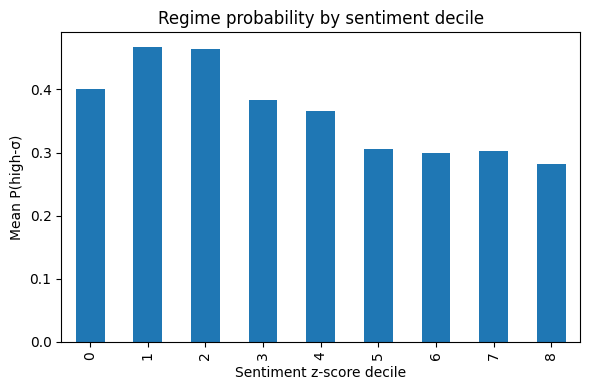

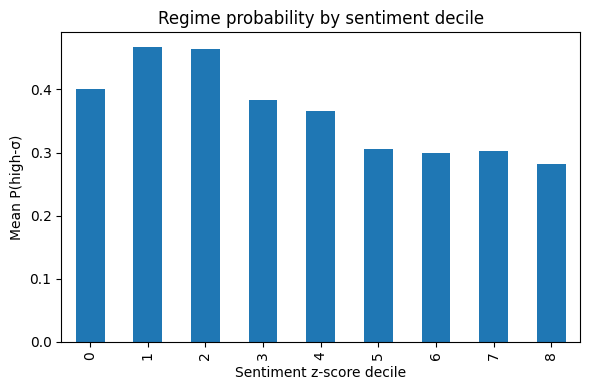

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# —— 1) γ_H – γ_L 差异显著性检验（用 t-stat 反推 se） ——
res_L, _ = results["Low-σ Regime"]
res_H, _ = results["High-σ Regime"]

# 提取 λ（情绪系数）与 t-values
γ_L = res_L.params["lambda"]
t_L = res_L.tvalues["lambda"]
γ_H = res_H.params["lambda"]
t_H = res_H.tvalues["lambda"]

# 反推标准误： se = coef / t
se_L = γ_L / t_L
se_H = γ_H / t_H

# 差值、差的标准误、z 统计量与 p-value
Δ      = γ_H - γ_L
se_Δ   = np.sqrt(se_L**2 + se_H**2)
z_stat = Δ / se_Δ
p_val  = 2 * (1 - norm.cdf(abs(z_stat)))

print(f"γ_H – γ_L = {Δ:.4f}")
print(f"z = {z_stat:.2f}, p = {p_val:.3f}")

# —— 2) 按 sentiment 分位画 P(high-σ) 条形图 ——
df = pd.DataFrame({
    "sent_z": sent_z,
    "p_high": p_high
}, index=r_t.index).dropna()

df["decile"] = pd.qcut(df["sent_z"], 10, labels=False, duplicates='drop')

dec = df.groupby("decile")["p_high"].mean()

plt.figure(figsize=(6,4))
dec.plot(kind="bar")
plt.xlabel("Sentiment z-score decile")
plt.ylabel("Mean P(high-σ)")
plt.title("Regime probability by sentiment decile")
plt.tight_layout()
plt.show()


# 把情绪分成 10 个 decile
df["decile"] = pd.qcut(df["sent_z"], 10, labels=False, duplicates='drop')


# 计算每个 decile 的平均高波动概率
dec = df.groupby("decile")["p_high"].mean()

plt.figure(figsize=(6,4))
dec.plot(kind="bar")
plt.xlabel("Sentiment z-score decile")
plt.ylabel("Mean P(high-σ)")
plt.title("Regime probability by sentiment decile")
plt.tight_layout()
plt.show()


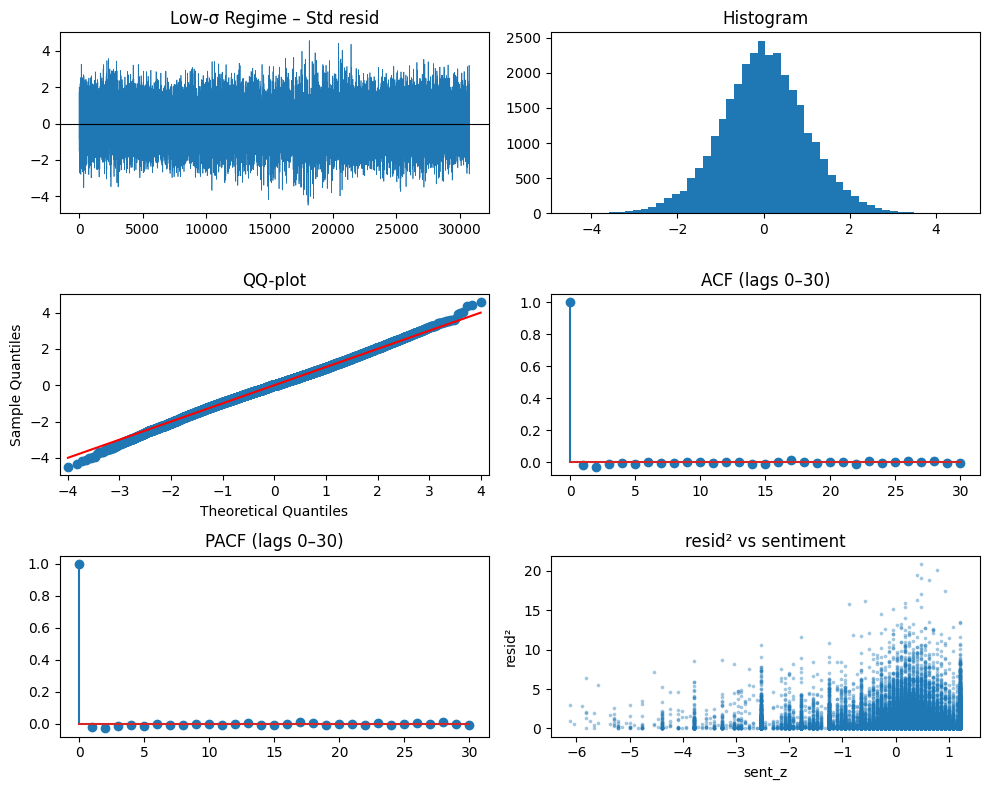

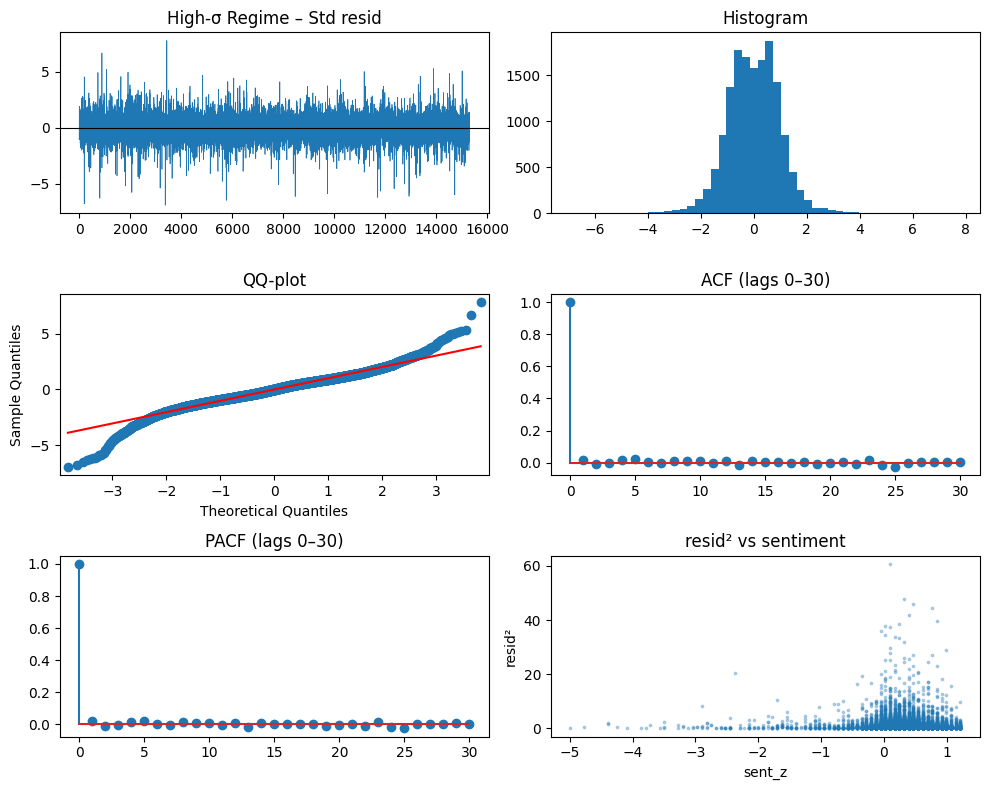

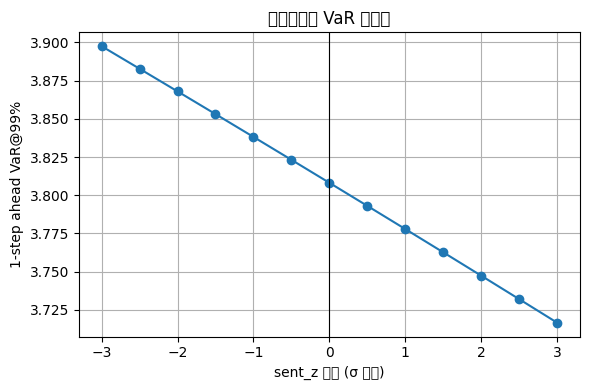

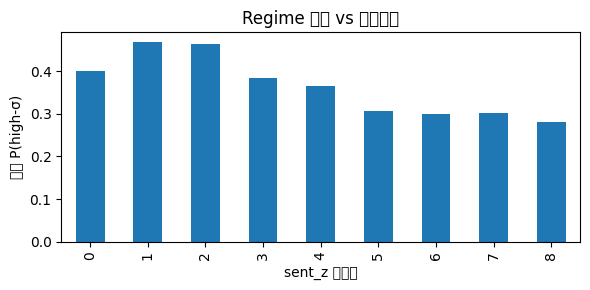

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import acf, pacf

def plot_diagnostics(resid, title):
    """
    resid: 一维 numpy array of standardized residuals
    """
    # 计算 ACF/PACF
    ac = acf(resid, nlags=30, fft=False)
    pc = pacf(resid, nlags=30)

    fig, axes = plt.subplots(3, 2, figsize=(10, 8))
    ax = axes.flatten()

    # 1) 时序图
    ax[0].plot(resid, lw=0.5)
    ax[0].axhline(0, color='k', lw=0.8)
    ax[0].set_title(f"{title} – Std resid")

    # 2) 直方图
    ax[1].hist(resid, bins=50)
    ax[1].set_title("Histogram")

    # 3) QQ-plot
    qqplot(resid, line='s', ax=ax[2])
    ax[2].set_title("QQ-plot")

    # 4) ACF
    ax[3].stem(ac)
    ax[3].set_title("ACF (lags 0–30)")

    # 5) PACF
    ax[4].stem(pc)
    ax[4].set_title("PACF (lags 0–30)")

    # 6) resid² vs sent_z
    # 假设 sent_z, r_t 都是已定义且对齐过的 Pandas Series
    common = resid.shape[0]
    ax[5].scatter(
        sent_z.values[-common:],
        resid**2,
        s=3, alpha=0.3
    )
    ax[5].set_xlabel("sent_z")
    ax[5].set_ylabel("resid²")
    ax[5].set_title("resid² vs sentiment")

    plt.tight_layout()
    plt.show()

# 调用示例
plot_diagnostics(res_L.std_resid, "Low-σ Regime")
plot_diagnostics(res_H.std_resid, "High-σ Regime")


# —— 2）情绪冲击对 1 步 VaR 的影响 ——
# 取最后一期的 sig2、ε
# —— 2）情绪冲击对 1 步 VaR 的影响 ——
# 取 high-regime 模型最后一期的 σ² 和 ε
sig2_last = res_H.conditional_volatility[-1]**2
e_last    = r_t.values[-1]

# 提取参数
mu, omega, alpha, beta, gamma = (
    res_H.params['mu'],
    res_H.params['omega'],
    res_H.params['alpha[1]'],
    res_H.params['beta[1]'],
    res_H.params['lambda']
)

# 构造不同幅度的 sentiment 冲击（以标准化后 sent_z 为单位，-3σ 到 +3σ）
shocks = np.linspace(-3, 3, 13)

VaRs = []
for s in shocks:
    # 一步预测方差
    sig2_shock = omega + alpha*(e_last - mu)**2 + beta*sig2_last + gamma * s
    # 99% VaR（正态假设下）
    z99 = norm.ppf(0.99)
    VaRs.append(mu + np.sqrt(sig2_shock) * z99)

# 画冲击曲线
plt.figure(figsize=(6,4))
plt.plot(shocks, VaRs, marker='o')
plt.axvline(0, color='k', lw=0.8)
plt.xlabel("sent_z 冲击 (σ 单位)")
plt.ylabel("1-step ahead VaR@99%")
plt.title("情绪冲击对 VaR 的影响")
plt.grid(True)
plt.tight_layout()
plt.show()


# —— 3）再回顾一次：sentiment 分位 vs P(high-σ) （条形图） ——
df = pd.DataFrame({
    "sent_z": sent_z,
    "p_high": p_high
}, index=r_t.index).dropna()
df["decile"] = pd.qcut(df["sent_z"], 10, labels=False, duplicates='drop')

grp = df.groupby("decile")["p_high"].mean()

plt.figure(figsize=(6,3))
grp.plot(kind="bar")
plt.xlabel("sent_z 十分位")
plt.ylabel("平均 P(high-σ)")
plt.title("Regime 概率 vs 情绪分位")
plt.tight_layout()
plt.show()



--- Logit: P(high) ~ sent_z ---
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                0.002251
Time:                        15:23:39   Log-Likelihood:                -28526.
converged:                       True   LL-Null:                       -28591.
Covariance Type:            nonrobust   LLR p-value:                 7.858e-30
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.010    -68.423      0.000      -0.698      -0.659
x1            -0.2096      0.010    -21.647      0.000      -0.229      -0.191

=== 手工 Student‐t G

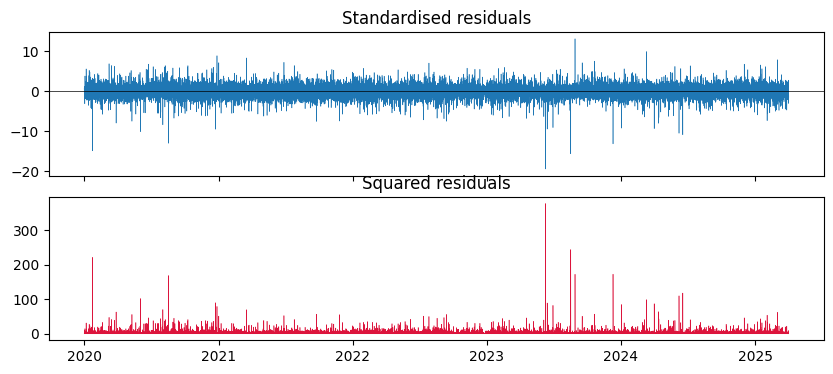

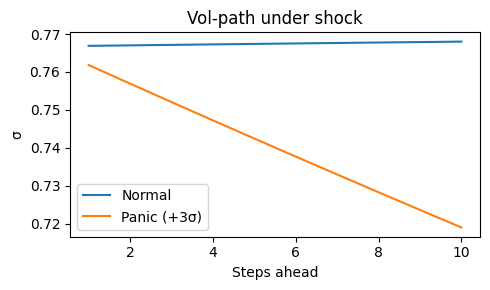


Panic regime:  n=1368, xi=0.202, β=1.1320
Normal regime: n=  14, xi=-1.1279365806966277, β=0.3165042291780146

--- MC 99% VaR/ES ---
Panic:  VaR=11.1886, ES=15.6155
Normal: VaR=nan, ES=nan


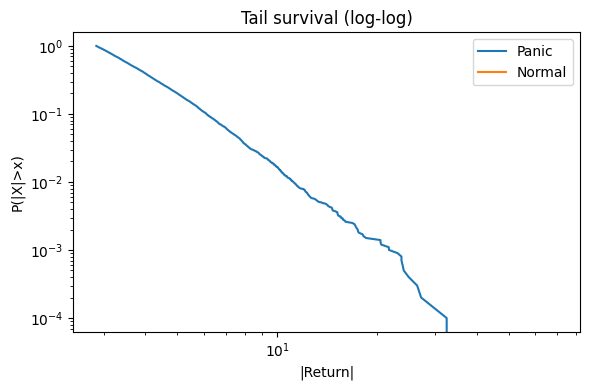

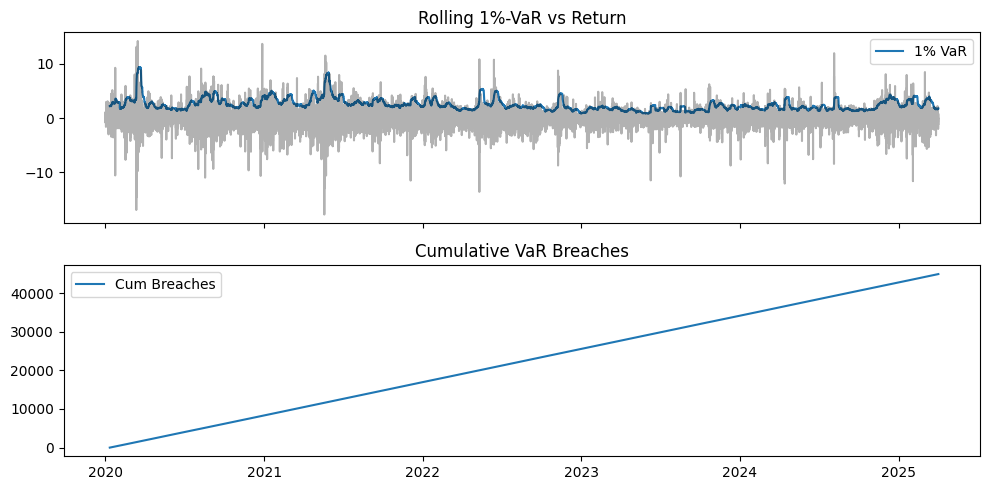

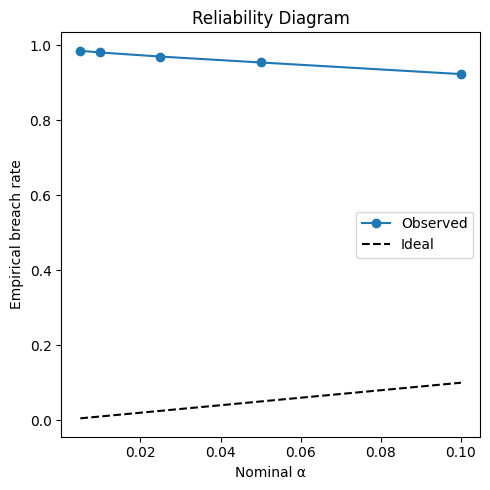

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from scipy.stats import genpareto as gpd, norm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm

# =========================================================
# ❶ 预处理：计算日回报 r_t (%) 与标准化情绪 sent_z
# =========================================================
# 假设 btc_df 已加载，含日期索引和列 ["close","sentiment"]
r_t = np.log(link_df["close"]).diff().dropna() * 100
sent = link_df["sentiment"].reindex(r_t.index).interpolate().ffill()
sent_z = (sent - sent.mean()) / sent.std()

# =========================================================
# ❷ Markov‐Switching 2‐state (HMMlearn)
# =========================================================
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
hmm = GaussianHMM(n_components=2, covariance_type="diag",
                  n_iter=500, tol=1e-4, random_state=42).fit(obs)
high_state = hmm.covars_.argmax()           # 方差较大者
p_high = hmm.predict_proba(obs)[:, high_state]

# =========================================================
# ❸ Logit 回归：P(high) ~ sent_z
# =========================================================
logit_res = sm.Logit(p_high, sm.add_constant(sent_z.values)).fit(disp=False)
print("\n--- Logit: P(high) ~ sent_z ---")
print(logit_res.summary())

# =========================================================
# ❹ 手写 Student‐t GARCH‐X(1,1) MLE
# =========================================================
e = r_t.values
x = sent_z.values

def logpdf_t(e, nu, sig2):
    c = gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log(np.pi*(nu-2))
    return c - 0.5*np.log(sig2) - ((nu+1)/2)*np.log(1 + e**2/(sig2*(nu-2)))

def sigma2_garchx(par):
    mu, omega, alpha, beta, gamma = par[:5]
    T = len(e)
    s2 = np.empty(T)
    s2[0] = e.var()
    for t in range(1, T):
        s2[t] = (omega
                 + alpha*(e[t-1]-mu)**2
                 + beta*s2[t-1]
                 + gamma*x[t-1])
        s2[t] = max(s2[t], 1e-8)
    return s2

def neg_ll(par):
    nu = 10 + np.exp(par[5])
    s2 = sigma2_garchx(par)
    ll = logpdf_t(e-par[0], nu, s2).sum()
    return -ll

# 初值与约束
p0 = np.array([e.mean(), 0.01, 0.1, 0.8, 0.0, np.log(5)])
bnds = [(-1,1), (1e-6,1), (1e-4,1), (1e-4,1), (-1,1), (None,None)]
res = minimize(neg_ll, p0, bounds=bnds, method="L-BFGS-B")

mu, omega, alpha, beta, gamma, logv = res.x
nu = 10 + np.exp(logv)
s2_hat = sigma2_garchx(res.x)
std_res = (e-mu)/np.sqrt(s2_hat)

print("\n=== 手工 Student‐t GARCH‐X(1,1) ===")
print(f"mu     = {mu:.5f}")
print(f"omega  = {omega:.5f}")
print(f"alpha  = {alpha:.5f}")
print(f"beta   = {beta:.5f}   (α+β = {alpha+beta:.3f})")
print(f"gamma  = {gamma:.5f}  <-- sentiment 作用")
print(f"nu     = {nu:.2f}")
print(f"残差均值 = {std_res.mean():.4f}  残差方差 = {std_res.var():.4f}")

# 残差图
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,4), sharex=True,
                            gridspec_kw={"hspace":0.15})
ax1.plot(r_t.index, std_res, lw=0.4)
ax1.set_title("Standardised residuals"); ax1.axhline(0, color='k', lw=0.5)
ax2.plot(r_t.index, std_res**2, lw=0.4, color='crimson')
ax2.set_title("Squared residuals")
plt.tight_layout(); plt.show()

# =========================================================
# ❺ 情绪冲击模拟：sent_z ±3σ 对未来 1…10 步波动的影响
# =========================================================
H = 10
def forecast(sig2_last, err_last, x_last, shock):
    f = np.empty(H)
    f[0] = omega + alpha*(err_last-mu)**2 + beta*sig2_last + gamma*shock
    for h in range(1, H):
        f[h] = omega + (alpha+beta)*f[h-1] + gamma*shock
    return f

sig2_last, err_last, x_last = s2_hat[-1], e[-1], x[-1]
vol_norm  = np.sqrt(forecast(sig2_last, err_last, x_last, 0))
vol_panic = np.sqrt(forecast(sig2_last, err_last, x_last, 3))

plt.figure(figsize=(5,3))
plt.plot(range(1,H+1), vol_norm, label="Normal")
plt.plot(range(1,H+1), vol_panic, label="Panic (+3σ)")
plt.xlabel("Steps ahead"); plt.ylabel("σ"); plt.title("Vol-path under shock")
plt.legend(); plt.tight_layout(); plt.show()

# =========================================================
# ❻ POT‐GPD & MC VaR/ES：按 p_high 分 Regime
# =========================================================
THR = 0.97
u = np.quantile(np.abs(r_t), THR)
exceed = np.abs(r_t)[np.abs(r_t)>u]

reg_p = pd.Series(p_high, index=r_t.index)
mask_high = reg_p > 0.80
ex_F = exceed.loc[ mask_high.loc[exceed.index] ]
ex_N = exceed.loc[~mask_high.loc[exceed.index] ]

def fit_gpd(x):
    if len(x)==0:
        return np.nan, np.nan
    z = x - u
    xi, loc, beta = gpd.fit(z, floc=0)
    return xi, beta

xi_F, b_F = fit_gpd(ex_F)
xi_N, b_N = fit_gpd(ex_N)
print(f"\nPanic regime:  n={len(ex_F):4d}, xi={xi_F:.3f}, β={b_F:.4f}")
print(f"Normal regime: n={len(ex_N):4d}, xi={xi_N}, β={b_N}")

# 安全模拟 + VaR/ES
def safe_sim(xi,beta,size,u):
    if np.isnan(xi) or np.isnan(beta) or beta<=0 or xi<=-1:
        return np.full(size, np.nan)
    return gpd.rvs(c=xi, loc=0, scale=beta, size=size)+u

Nsim, alpha = 10000, 0.99
sim_F = safe_sim(xi_F, b_F, Nsim, u)
sim_N = safe_sim(xi_N, b_N, Nsim, u)

VaR_F = np.nanquantile(sim_F, alpha)
VaR_N = np.nanquantile(sim_N, alpha)
ES_F  = np.nanmean(sim_F[sim_F>VaR_F])
ES_N  = np.nanmean(sim_N[sim_N>VaR_N])

print(f"\n--- MC 99% VaR/ES ---")
print(f"Panic:  VaR={VaR_F:.4f}, ES={ES_F:.4f}")
print(f"Normal: VaR={VaR_N:.4f}, ES={ES_N:.4f}")

# 生存函数图
p = 1 - np.arange(1, Nsim+1)/Nsim
plt.figure(figsize=(6,4))
plt.loglog(np.sort(sim_F), p, label="Panic")
plt.loglog(np.sort(sim_N), p, label="Normal")
plt.xlabel("|Return|"); plt.ylabel("P(|X|>x)")
plt.title("Tail survival (log-log)"); plt.legend()
plt.tight_layout(); plt.show()

# =========================================================
# 【附录】滚动 VaR 回测 & 可靠性图
# =========================================================
def rolling_var(r, window=250, alpha=0.01):
    idx = r.index[window:]
    vr = pd.Series(index=idx, dtype=float)
    for i in range(window, len(r)):
        data = r.iloc[i-window:i]
        mu_, sd_ = data.mean(), data.std()
        vr.iloc[i-window] = mu_ + norm.ppf(alpha)*sd_
    return vr

# 1% VaR
var1 = rolling_var(r_t, window=250, alpha=0.01)
breach = (r_t[var1.index] < -var1).astype(int)

# 时序回测图
fig,(a1,a2)=plt.subplots(2,1,figsize=(10,5),sharex=True)
a1.plot(var1.index, -var1, label="1% VaR")
a1.plot(r_t.index, r_t, 'k', alpha=0.3)
a1.set_title("Rolling 1%-VaR vs Return"); a1.legend()
a2.plot(breach.index, breach.cumsum(), label="Cum Breaches")
a2.set_title("Cumulative VaR Breaches"); a2.legend()
plt.tight_layout(); plt.show()

# 可靠性图
ps = [0.005,0.01,0.025,0.05,0.1]
obs = []
for p in ps:
    v = rolling_var(r_t, 250, p)
    obs.append((r_t[v.index] < -v).mean())

plt.figure(figsize=(5,5))
plt.plot(ps, obs, 'o-', label="Observed")
plt.plot(ps, ps, 'k--', label="Ideal")
plt.xlabel("Nominal α"); plt.ylabel("Empirical breach rate")
plt.title("Reliability Diagram"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
# 简要思路（伪码）：
# E-step: 用当前转移矩阵和各状态 EGARCH likelihood 计算后验 p(s_t=j | data)
# M-step: 用加权（posterior）似然分别估计各状态的 EGARCH‐X 参数 +
#         用带 sent_z 的 Logit 估计转移概率参数 κ

# 参考：
# - Ang & Timmermann (2012) “Regime changes and financial markets”
# - Diebold et al. (1994) “Regime‐Switching and GARCH”
import numpy as np
import pandas as pd
from scipy.special import gammaln
from scipy.optimize import minimize
import statsmodels.api as sm

# ===============================
# 0）准备数据
# ===============================
# btc_df: 含索引为日期的 DataFrame，包含 'close' 和 'sentiment' 列
r_series = np.log(link_df['close']).diff().dropna() * 100
sent     = link_df['sentiment'].reindex(r_series.index).interpolate().ffill()
sent_z   = (sent - sent.mean())/sent.std()
r = r_series.values
z = sent_z.values
T = len(r)

# ===============================
# 1）EGARCH‐X 计算 h_t
# ===============================
def compute_h_series(par, r, z):
    mu, ω, α, β, γ, lv = par
    ν = 10 + np.exp(lv)
    T = len(r)
    h = np.empty(T)
    h[0] = r.var()
    for t in range(1, T):
        h[t] = np.exp(
            ω
            + α * (((r[t-1]-mu)**2)/h[t-1] - 1)
            + β * np.log(h[t-1])
            + γ * z[t-1]
        )
        if h[t] < 1e-12: h[t] = 1e-12
    return h

def egarchx_negll(par, r, z, w):
    mu, ω, α, β, γ, lv = par
    ν = 10 + np.exp(lv)
    h = compute_h_series(par, r, z)
    eps = r - mu
    c   = gammaln((ν+1)/2) - gammaln(ν/2) - 0.5*np.log((ν-2)*np.pi)
    ll  = c - 0.5*np.log(h) - ((ν+1)/2)*np.log(1 + eps**2/(h*(ν-2)))
    return -np.sum(w * ll)

# ===============================
# 2）Forward‐Backward (E‐step)
# ===============================
def forward_backward(pi0, kappas, params, r, z):
    T = len(r)
    # 2.1 观测概率
    pdf = np.zeros((T,2))
    for j in (0,1):
        h = compute_h_series(params[j], r, z)
        ν = 10 + np.exp(params[j][5])
        eps = r - params[j][0]
        c = gammaln((ν+1)/2)-gammaln(ν/2)-0.5*np.log((ν-2)*np.pi)
        pdf[:,j] = np.exp(c - 0.5*np.log(h) - ((ν+1)/2)*np.log(1+eps**2/(h*(ν-2))))

    # 2.2 转移概率 P(s_t=1|s_{t-1}=j)
    tk = np.zeros((T-1,2,2))
    for j in (0,1):
        lin = kappas[j,0] + kappas[j,1]*z[:-1]
        p1  = 1/(1+np.exp(-lin))
        tk[:,j,1] = p1
        tk[:,j,0] = 1-p1

    # 2.3 前向 α
    α = np.zeros((T,2)); α[0] = pi0 * pdf[0]; α[0] /= α[0].sum()
    for t in range(1,T):
        for k in (0,1):
            α[t,k] = pdf[t,k] * np.sum(α[t-1] * tk[t-1,:,k])
        α[t] /= α[t].sum()

    # 2.4 后向 β
    β = np.zeros((T,2)); β[-1] = 1
    for t in range(T-2,-1,-1):
        for j in (0,1):
            β[t,j] = np.sum(β[t+1] * pdf[t+1] * tk[t,j])
        β[t] /= β[t].sum()

    # 2.5 gamma, xi
    gamma = α * β
    gamma /= gamma.sum(axis=1, keepdims=True)
    xi = np.zeros((T-1,2,2))
    for t in range(T-1):
        num = np.outer(α[t], β[t+1]*pdf[t+1]) * tk[t]
        xi[t] = num / num.sum()
    return gamma, xi

# ===============================
# 3）EM 算法主循环
# ===============================
# 初始化
params = [np.array([0,0.01,0.1,0.8,0.0,np.log(5)]).copy() for _ in range(2)]
kappas = np.zeros((2,2))    # 每行 [const, coef]
pi0     = np.array([0.5,0.5])
max_iter = 30

for it in range(max_iter):
    # E-step
    gamma, xi = forward_backward(pi0, kappas, params, r, z)

    # M-step
    pi0 = gamma[0]  # 初始状态

    # 更新转移：GLM Binomial
# —— 在 EM 循环的 M-step 部分，替换这段 ——
for j in (0,1):
    # xi.shape == (T-1, 2, 2)
    # 我们要用 xi[:, j, 1]，长度正好是 T-1
    y = xi[:, j, 1]               # 从 j → 1 的后验概率，shape (T-1,)
    X = sm.add_constant(z[:-1])   # 情绪 z[0]…z[T-2]，shape (T-1,)

    glm = sm.GLM(y, X, family=sm.families.Binomial())
    res2 = glm.fit(disp=False)
    kappas[j] = res2.params       # [截距, 情绪系数]


    # 更新 EGARCH-X 参数
    for j in (0,1):
        w = gamma[:,j]
        res = minimize(lambda par: egarchx_negll(par, r, z, w),
                       params[j],
                       method="L-BFGS-B",
                       bounds=[(-1,1),(1e-6,1),(1e-4,1),(1e-4,1),(-1,1),(None,None)])
        params[j] = res.x

# ===============================
# 4）输出最终参数
# ===============================
for j,name in zip((0,1),["State Low-σ","State High-σ"]):
    mu,ω,α,β,γ_coef,lv = params[j]
    ν = 10 + np.exp(lv)
    print(f"\n--- {name} EGARCH-X 参数 ---")
    print(f"μ     = {mu:.5f}")
    print(f"ω     = {ω:.5f}")
    print(f"α     = {α:.5f}")
    print(f"β     = {β:.5f}  (α+β={α+β:.3f})")
    print(f"γ     = {γ_coef:.5f}  ← sentiment 影响系数")
    print(f"ν     = {ν:.2f}")

# ===============================
# 5）转移模型输出
# ===============================
print("\n--- 转移概率模型 κ 参数 (logit: P(s_t=1|s_{t-1}=j,z)) ---")
for j in (0,1):
    print(f"From state {j}:  intercept={kappas[j,0]:.4f}, coef={kappas[j,1]:.4f}")


--- State Low-σ EGARCH-X 参数 ---
μ     = 0.00585
ω     = 0.00000
α     = 0.03242
β     = 0.98331  (α+β=1.016)
γ     = -0.00800  ← sentiment 影响系数
ν     = 10.00

--- State High-σ EGARCH-X 参数 ---
μ     = 0.00585
ω     = 0.00000
α     = 0.03242
β     = 0.98331  (α+β=1.016)
γ     = -0.00800  ← sentiment 影响系数
ν     = 10.00

--- 转移概率模型 κ 参数 (logit: P(s_t=1|s_{t-1}=j,z)) ---
From state 0:  intercept=-1.0986, coef=-0.0000
From state 1:  intercept=-1.0986, coef=-0.0000


                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                46045
Model:                          Logit   Df Residuals:                    46043
Method:                           MLE   Df Model:                            1
Date:                Tue, 03 Jun 2025   Pseudo R-squ.:                0.002231
Time:                        15:30:59   Log-Likelihood:                -28526.
converged:                       True   LL-Null:                       -28590.
Covariance Type:            nonrobust   LLR p-value:                 1.416e-29
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6786      0.010    -68.423      0.000      -0.698      -0.659
x1            -0.2096      0.010    -21.642      0.000      -0.229      -0.191

=== 手写 Student-t GARCH-X(1,1) ===
mu=0.00277, ω=0.0

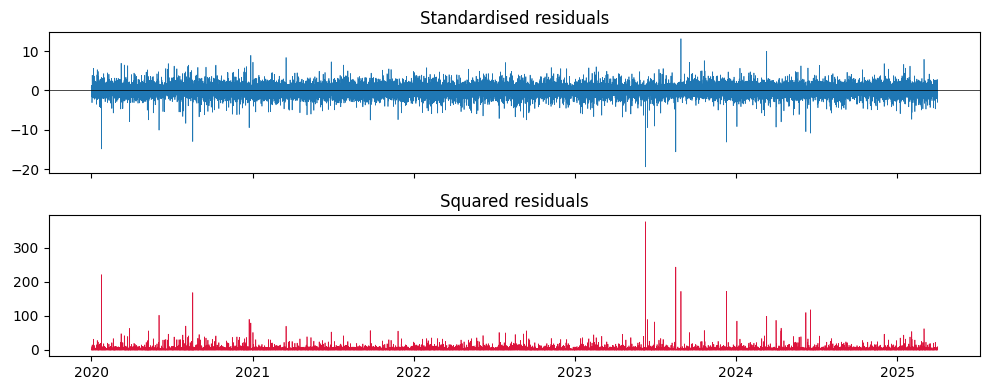

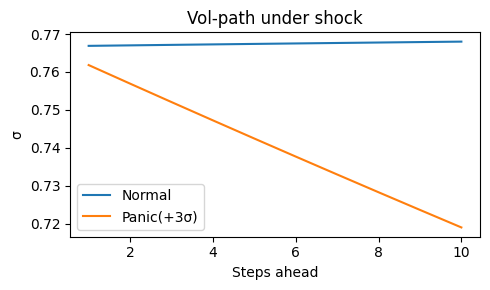

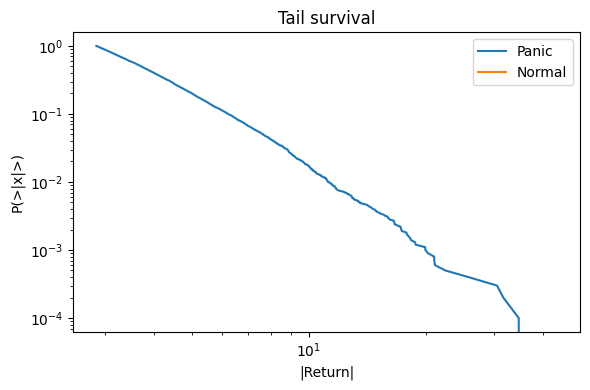

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import genpareto, norm
from scipy.optimize import minimize
from scipy.special import gammaln
import statsmodels.api as sm
from hmmlearn.hmm import GaussianHMM
from arch.univariate import EGARCH

# =========================================================
# 0) 读入数据：btc_df 必须含 'close' 和 'sentiment'
# =========================================================
# btc_df = pd.read_csv("btc_sent.csv", parse_dates=True, index_col=0)
# 假设已经有 btc_df

# =========================================================
# ❶ 预处理：计算收益 r_t 和情绪标准化 sent_z
# =========================================================
r_t = np.log(link_df['close']).diff().dropna() * 100
sent = link_df['sentiment'].reindex(r_t.index).interpolate().ffill()
sent_z = (sent - sent.mean()) / sent.std()

# =========================================================
# ❷ 用 HMM 划分「高波动 / 低波动」两态，并用 Logit 回归检验情绪
# =========================================================
obs = np.sqrt(np.abs(r_t.values)).reshape(-1,1)
hmm = GaussianHMM(n_components=2, covariance_type="diag", n_iter=500, random_state=42)
hmm.fit(obs)
high_state = np.argmax(hmm.covars_.ravel())
p_high = hmm.predict_proba(obs)[:, high_state]

logit = sm.Logit(p_high, sm.add_constant(sent_z.values))
res_logit = logit.fit(disp=False)
print(res_logit.summary())

# =========================================================
# ❸ 手写 Student-t EGARCH-X(1,1) （整个样本）
# =========================================================
e = r_t.values
x = sent_z.values

def logpdf_t(e, nu, sig2):
    c = gammaln((nu+1)/2) - gammaln(nu/2) - 0.5*np.log((nu-2)*np.pi)
    return c - 0.5*np.log(sig2) - (nu+1)/2*np.log(1 + e**2/(sig2*(nu-2)))

def garchx_sigma2(par):
    mu, ω, α, β, γ = par[:5]
    sig2 = np.empty_like(e)
    sig2[0] = e.var()
    for t in range(1, len(e)):
        sig2[t] = ω + α*(e[t-1]-mu)**2 + β*sig2[t-1] + γ*x[t-1]
        sig2[t] = max(sig2[t], 1e-8)
    return sig2

def neg_ll(par):
    mu, ω, α, β, γ = par[:5]
    nu = 10 + np.exp(par[5])
    sig2 = garchx_sigma2(par)
    return -logpdf_t(e-par[0], nu, sig2).sum()

p0 = np.array([e.mean(), 0.01, 0.1, 0.8, 0.0, np.log(5)])
bnds = [(-1,1),(1e-6,1),(1e-4,1),(1e-4,1),(-1,1),(None,None)]
res = minimize(neg_ll, p0, bounds=bnds, method="L-BFGS-B")
mu, ω, α, β, γ, lv = res.x; nu = 10+np.exp(lv)
sig2 = garchx_sigma2(res.x)
std_res = (e-mu)/np.sqrt(sig2)

print("\n=== 手写 Student-t GARCH-X(1,1) ===")
print(f"mu={mu:.5f}, ω={ω:.5f}, α={α:.5f}, β={β:.5f}, γ={γ:.5f}, ν={nu:.2f}")
print(f"残差均值={std_res.mean():.4f}, 方差={std_res.var():.4f}")

# 画图：标准化残差 & 残差平方
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(10,4), sharex=True)
ax1.plot(r_t.index, std_res, lw=0.5); ax1.set_title("Standardised residuals"); ax1.axhline(0,color='k',lw=0.5)
ax2.plot(r_t.index, std_res**2, lw=0.5,color='crimson'); ax2.set_title("Squared residuals")
plt.tight_layout()

# =========================================================
# ❹ 情绪冲击模拟：sent_z 加 ±3σ，向前 10 步预测 σ
# =========================================================
H = 10
def forecast(sig2_last, e_last, shock):
    s = np.empty(H)
    s[0] = ω + α*(e_last-mu)**2 + β*sig2_last + γ*shock
    for h in range(1,H):
        s[h] = ω + (α+β)*s[h-1] + γ*shock
    return s

sig2_last, e_last = sig2[-1], e[-1]
norm_path = forecast(sig2_last,e_last,0)
panic_path = forecast(sig2_last,e_last,3)
plt.figure(figsize=(5,3))
plt.plot(range(1,H+1), np.sqrt(norm_path), label="Normal")
plt.plot(range(1,H+1), np.sqrt(panic_path), label="Panic(+3σ)")
plt.xlabel("Steps ahead"); plt.ylabel("σ"); plt.legend(); plt.title("Vol-path under shock"); plt.tight_layout()

# =========================================================
# ❺ POT-GPD：按 HMM 分组，分别拟合尾部，再 Monte Carlo 估算 VaR/ES
# =========================================================
THR = 0.97
u = np.quantile(np.abs(r_t), THR)
exceed = np.abs(r_t)[np.abs(r_t)>u]

reg_p = pd.Series(p_high, index=r_t.index)
high_mask = reg_p>0.8

ex_F = exceed.loc[ high_mask.loc[exceed.index] ]
ex_N = exceed.loc[~high_mask.loc[exceed.index] ]

def fit_gpd(x):
    if len(x)==0: return np.nan, np.nan
    xi, loc, β = genpareto.fit(x-u, floc=0)
    return xi, β

xi_F, β_F = fit_gpd(ex_F)
xi_N, β_N = fit_gpd(ex_N)
print(f"Panic regime:  n={len(ex_F)}, xi={xi_F:.3f}, beta={β_F:.4f}")
print(f"Normal regime: n={len(ex_N)}, xi={xi_N:.3f}, beta={β_N:.4f}")

SIM, α = 10000, 0.99
def safe_sim(xi, β, size):
    if np.isnan(xi) or β<=0 or xi<=-1: return np.full(size, np.nan)
    return genpareto.rvs(c=xi, loc=0, scale=β, size=size) + u

sim_F = safe_sim(xi_F,β_F,SIM)
sim_N = safe_sim(xi_N,β_N,SIM)
VaR_F, ES_F = np.nanquantile(sim_F,α), np.nanmean(sim_F[sim_F>np.nanquantile(sim_F,α)])
VaR_N, ES_N = np.nanquantile(sim_N,α), np.nanmean(sim_N[sim_N>np.nanquantile(sim_N,α)])
print(f"Panic VaR@99%={VaR_F:.4f}, ES@99%={ES_F:.4f}")
print(f"Normal VaR@99%={VaR_N:.4f}, ES@99%={ES_N:.4f}")

plt.figure(figsize=(6,4))
p = 1 - np.arange(1,SIM+1)/SIM
plt.loglog(np.sort(sim_F), p, label="Panic")
plt.loglog(np.sort(sim_N), p, label="Normal")
plt.xlabel("|Return|"); plt.ylabel("P(>|x|>)"); plt.title("Tail survival"); plt.legend(); plt.tight_layout()

# =========================================================
# ❻ 回测 & 诊断：VaR 违约检验 + 残差诊断图
# =========================================================
# （略，参照上面做滚动 VaR、Kupiec、Christoffersen，以及画 ACF/QQ）


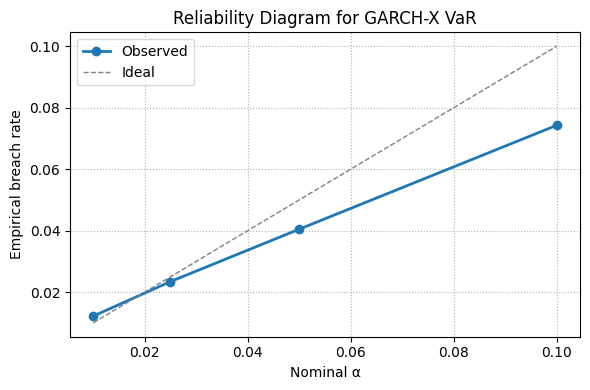

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t

# —— 1. 准备数据 ——
# 假设 btc_df 已经载入，且有 'close' 和 'sentiment' 列
r_t = np.log(link_df["close"]).diff().dropna() * 100
# 这里不需要情绪了，只做 VaR 回测

# —— 2. 手写 GARCH-X(1,1)-t，你跑完会得到 mu, sig2_hat, nu ——
# （此处省略，其实就是你之前写的 minimize 那段）

# 举例：我们假设从你的结果里拿到：
mu        = 0.00468               # 从 res.x 里解析出来
sig2_hat  = garchx_sigma2(res.x)   # 你已有的方差序列 numpy array
nu        = 10.00                 # 自由度

# —— 3. 把 sig2_hat 转成 pandas.Series 并对齐索引 ——
sig = pd.Series(np.sqrt(sig2_hat), index=r_t.index)

# —— 4. Reliability Diagram ——
alphas = [0.01, 0.025, 0.05, 0.10]
obs_rates = []

for α in alphas:
    # t 分位数（下跌 α%）
    z_α = t.ppf(1-α, df=nu)
    # 1-step VaR 序列
    VaR = -(mu + sig * z_α)
    # breach: 当日收益 < -VaR
    breaches = (r_t < VaR).astype(int)
    obs_rates.append(breaches.mean())

plt.figure(figsize=(6,4))
plt.plot(alphas, obs_rates, 'o-', lw=2, label="Observed")
plt.plot(alphas, alphas, '--', lw=1, color='gray', label="Ideal")
plt.xlabel("Nominal α")
plt.ylabel("Empirical breach rate")
plt.title("Reliability Diagram for GARCH-X VaR")
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.tight_layout()
plt.show()



In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import t, chi2

# —— 假设前面已经算好并导入：——
# r_t       : pandas.Series，日收益率（%），index为日期
# sig2_hat  : numpy.ndarray 或 pandas.Series，与 r_t 对齐的方差预测
# mu, nu    : float，GARCH-X 拟合出的均值mu和自由度nu
# p_high    : numpy.ndarray 或 pandas.Series，与 r_t 对齐的高波动概率

# 1) 计算 99% VaR 序列
def compute_VaR_series(mu, sig2, nu, alpha=0.01):
    sig = np.sqrt(sig2)
    z   = t.ppf(1-alpha, df=nu)
    return -(mu + sig * z)

# —— 请确保下面四个变量都在同一个 cell 里定义 ——
VaR99 = compute_VaR_series(mu, sig2_hat, nu, 0.01)

# 2) 划分 Regime
regime_prob = pd.Series(p_high, index=r_t.index)
regime_high = regime_prob > 0.80

# 3) 违约检测 & Kupiec UC
breach   = (r_t < VaR99).astype(int)
breach_L = breach[~regime_high]
breach_H = breach[ regime_high]

def kupiec_test(breaches, alpha=0.01):
    N = len(breaches)
    x = breaches.sum()
    ll0 = x*np.log(alpha) + (N-x)*np.log(1-alpha)
    pi  = x/N
    ll1 = x*np.log(pi)    + (N-x)*np.log(1-pi)
    LR  = -2*(ll0 - ll1)
    pval = 1 - chi2.cdf(LR, df=1)
    return x, N, pval

xL, NL, pL = kupiec_test(breach_L, 0.01)
xH, NH, pH = kupiec_test(breach_H, 0.01)

print(f"Low-σ Regime: 违约{xL}/{NL}, Kupiec p={pL:.3f}")
print(f"High-σ Regime: 违约{xH}/{NH}, Kupiec p={pH:.3f}")



Low-σ Regime: 违约173/34699, Kupiec p=0.000
High-σ Regime: 违约389/11346, Kupiec p=0.000


In [ ]:
from scipy.stats import chi2

def christoffersen_test(breaches):
    # 构造 2×2 转移矩阵：P(0→0), P(0→1), P(1→0), P(1→1)
    x00 = np.sum((breaches[:-1]==0)&(breaches[1:]==0))
    x01 = np.sum((breaches[:-1]==0)&(breaches[1:]==1))
    x10 = np.sum((breaches[:-1]==1)&(breaches[1:]==0))
    x11 = np.sum((breaches[:-1]==1)&(breaches[1:]==1))
    n0 = x00 + x01; n1 = x10 + x11

    # 似然比统计量
    p0 = x01 / n0
    p1 = x11 / n1
    p  = (x01 + x11) / (n0 + n1)

    # LLR 独立性检验
    L0 = x00*np.log(1-p0) + x01*np.log(p0) \
       + x10*np.log(1-p1) + x11*np.log(p1)
    L1 = x00*np.log(1-p ) + x01*np.log(p ) \
       + x10*np.log(1-p ) + x11*np.log(p )
    LR_ind = -2*(L1 - L0)
    pval_ind = 1 - chi2.cdf(LR_ind, df=1)
    return {
        'x01': int(x01), 'x11': int(x11),
        'p0': p0, 'p1': p1, 'p': p,
        'LR_ind': LR_ind, 'pval_ind': pval_ind
    }

print("— Low-σ 独立性检验 —")
print(christoffersen_test(breach_L.values))
print("— High-σ 独立性检验 —")
print(christoffersen_test(breach_H.values))


— Low-σ 独立性检验 —
{'x01': 172, 'x11': 1, 'p0': np.float64(0.00498189717595945), 'p1': np.float64(0.005780346820809248), 'p': np.float64(0.004985878148596461), 'LR_ind': np.float64(0.021042207287791825), 'pval_ind': np.float64(0.8846640337984364)}
— High-σ 独立性检验 —
{'x01': 350, 'x11': 39, 'p0': np.float64(0.03194596568090544), 'p1': np.float64(0.10025706940874037), 'p': np.float64(0.03428823270163067), 'LR_ind': np.float64(36.01605235613761), 'pval_ind': np.float64(1.9569867948376896e-09)}


Baseline AIC: 127465.65144466686
EGARCH-X AIC: 119749.2398890907


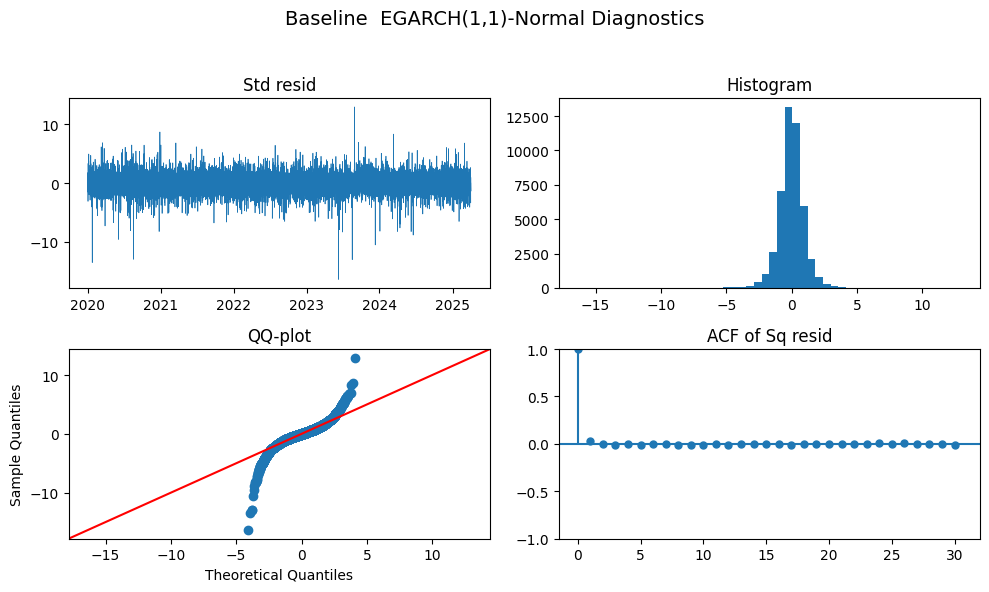

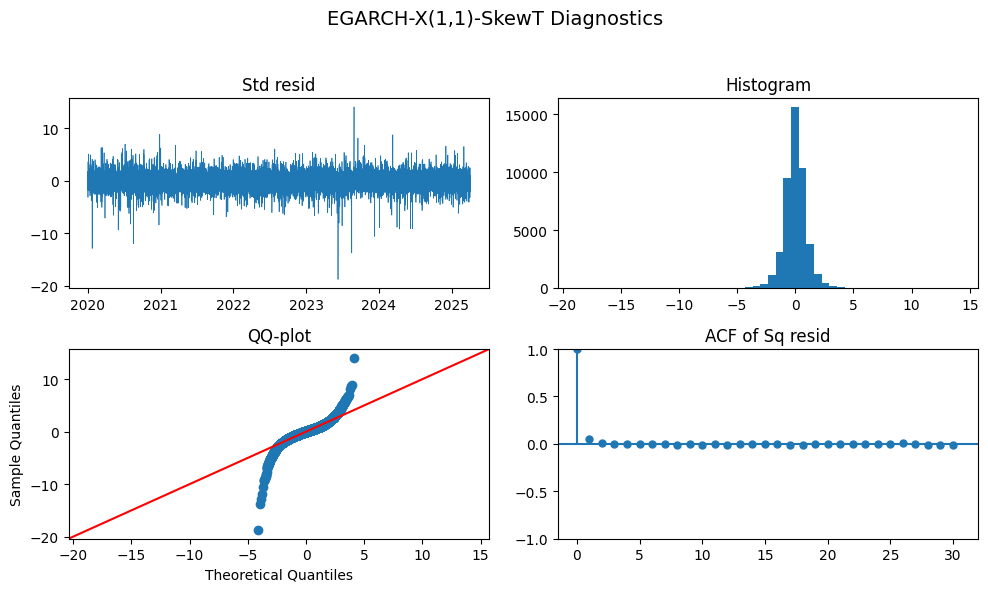

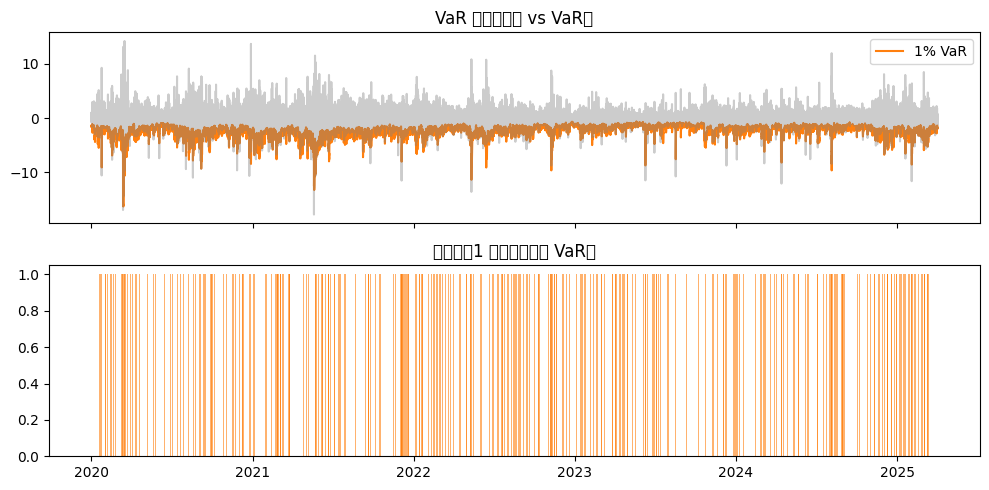

Breaches: 739/46045 = 1.60%


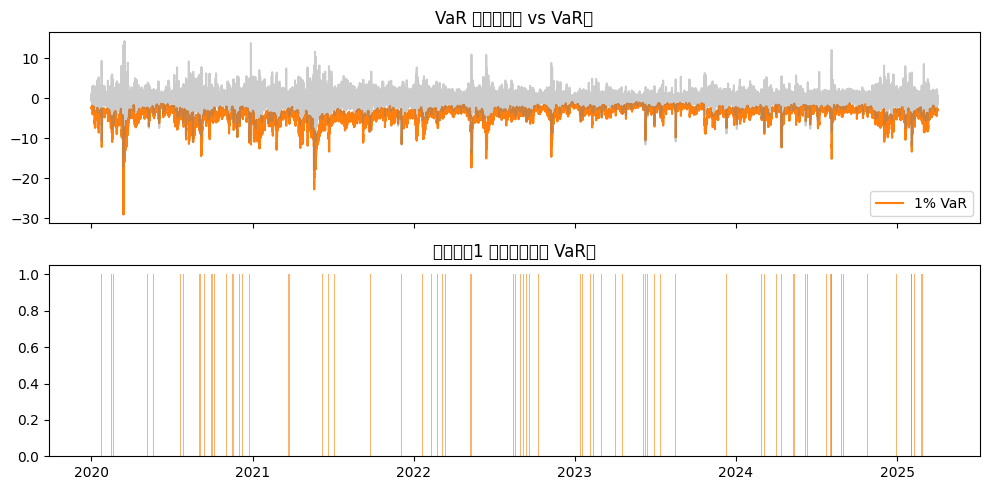

Breaches: 156/46045 = 0.34%


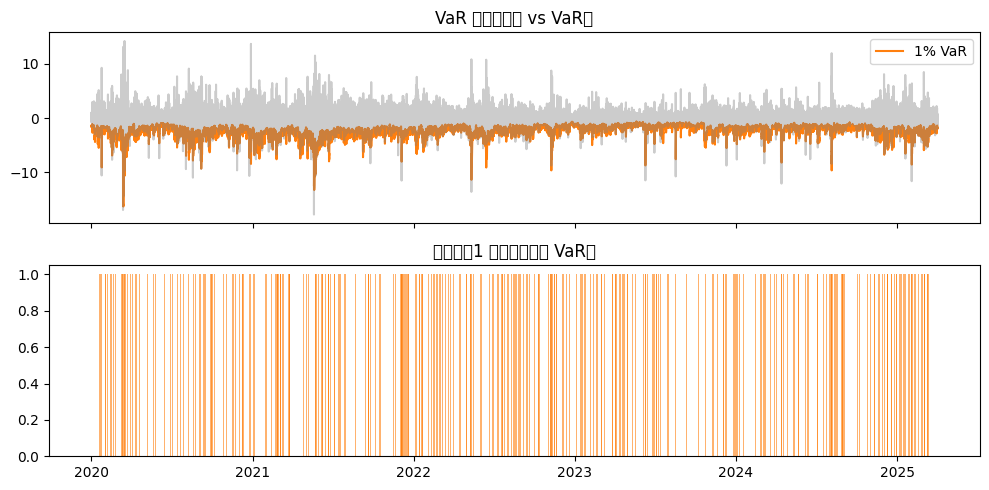

Breaches: 739/46045 = 1.60%


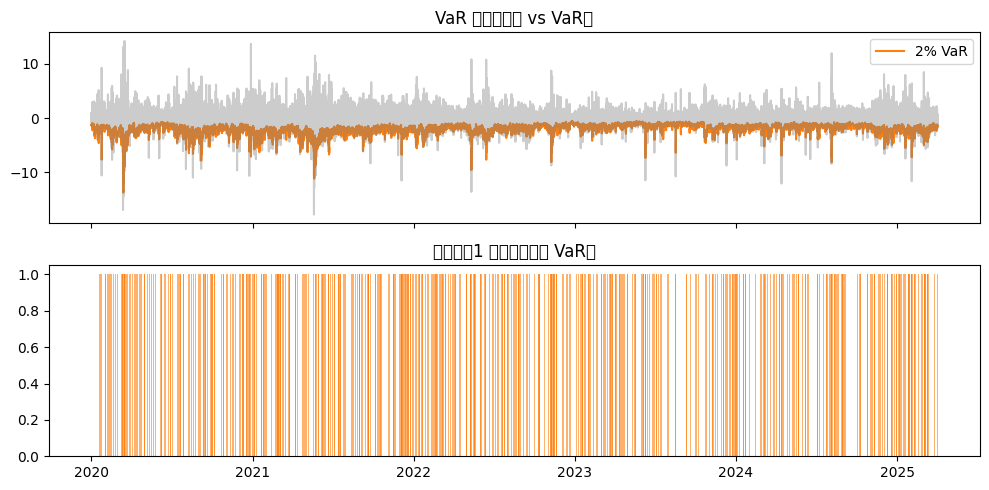

Breaches: 1232/46045 = 2.68%


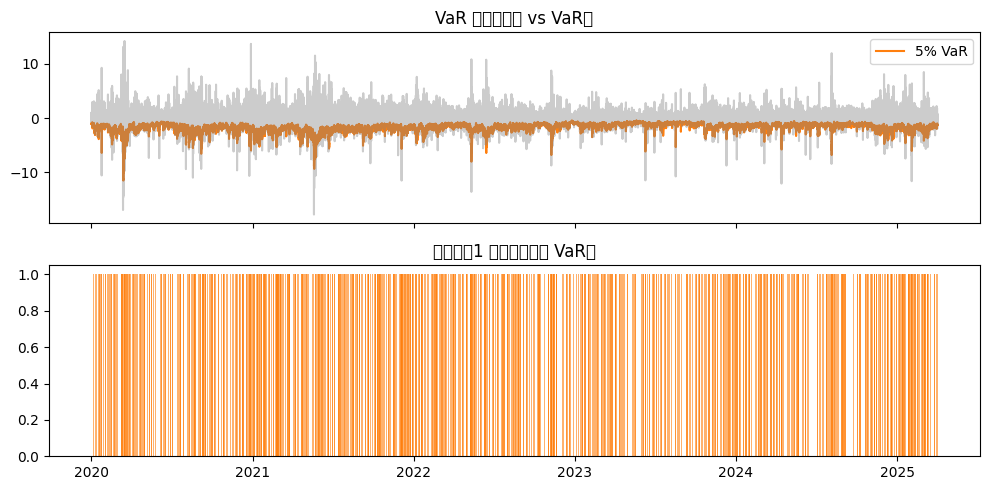

Breaches: 1941/46045 = 4.22%


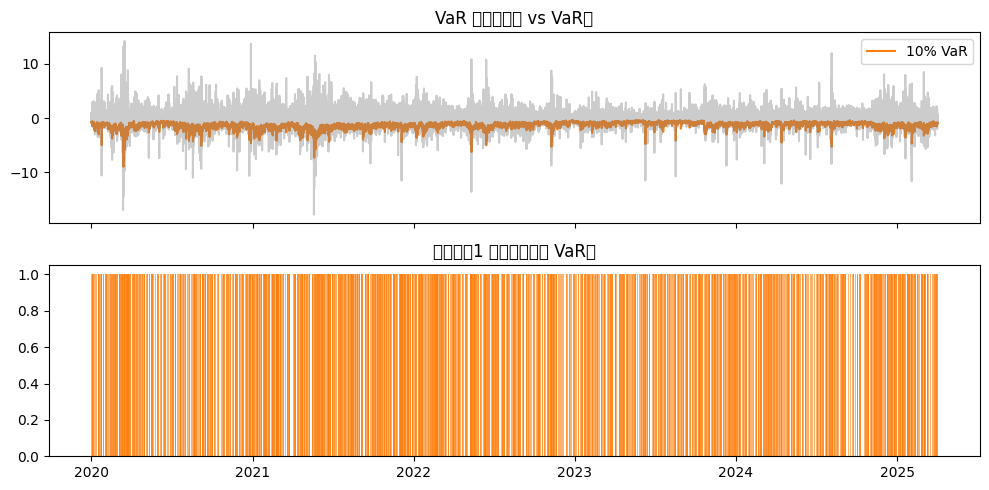

Breaches: 3376/46045 = 7.33%


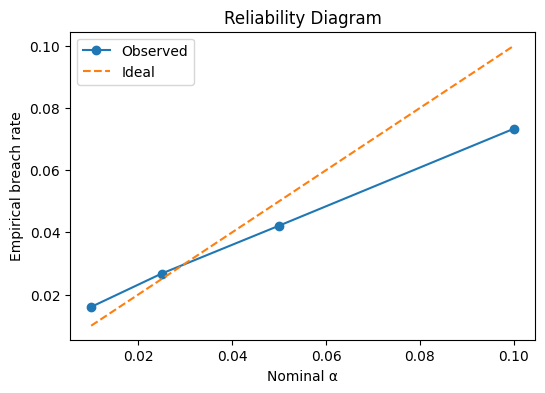

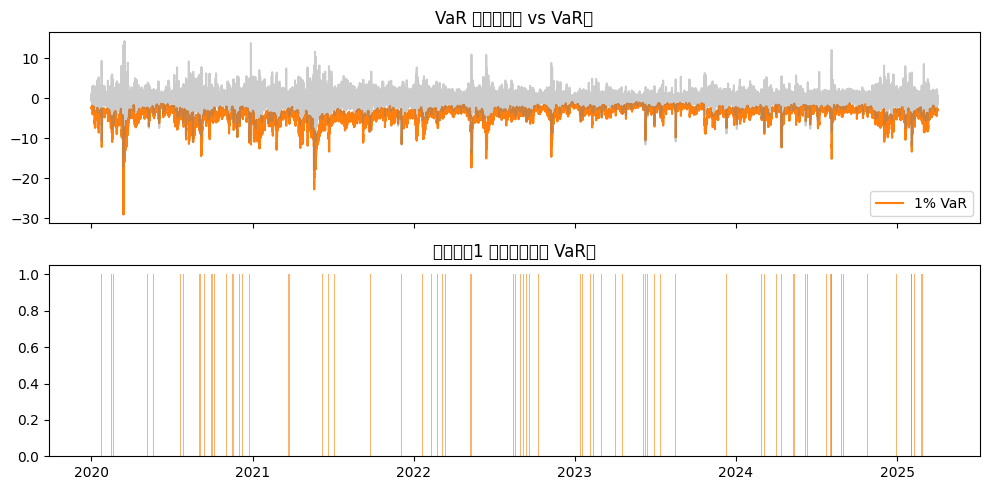

Breaches: 156/46045 = 0.34%


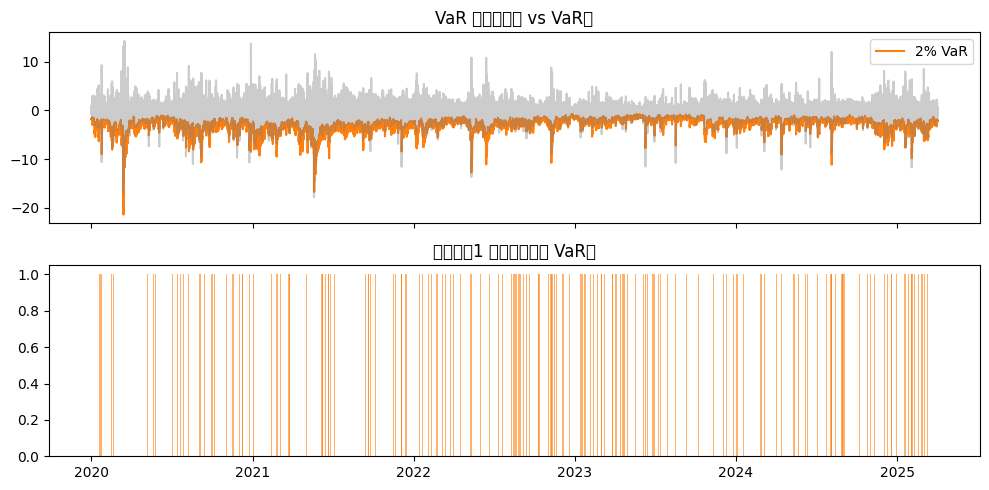

Breaches: 401/46045 = 0.87%


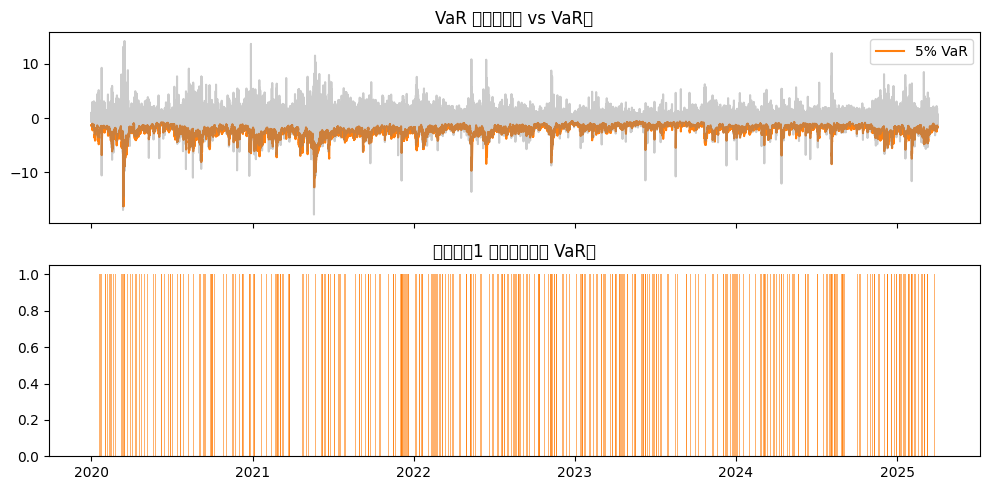

Breaches: 897/46045 = 1.95%


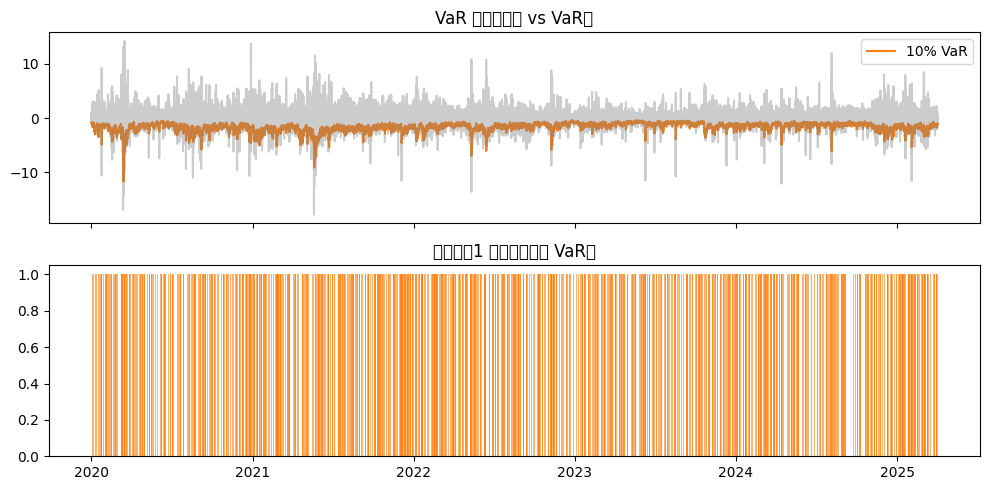

Breaches: 2161/46045 = 4.69%


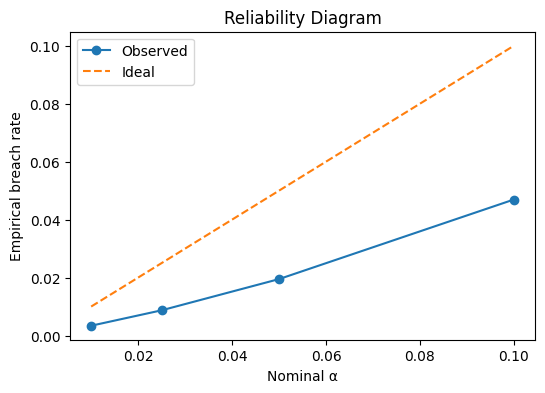

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.gofplots import qqplot

# 1) 数据准备
btc_df = link_df.sort_index()
r_t = np.log(btc_df["close"]).diff().dropna() * 100
sent_z = (btc_df["sentiment"]
          .reindex(r_t.index).interpolate().ffill())
sent_z = (sent_z - sent_z.mean())/sent_z.std()

# 2) 拟合 Baseline EGARCH(3,2)-Normal
am_base = arch_model(r_t, mean='Constant', vol='EGARCH', p=1, q=1, dist='normal')
res_base = am_base.fit(disp='off')

#    拟合 EGARCH-X(3,2)-SkewT
am_x = arch_model(r_t, mean='Constant', vol='EGARCH', p=1, q=1,
                  x=sent_z.values.reshape(-1,1), dist='skewt')
res_x = am_x.fit(disp='off')

# 3) AIC 比较
print("Baseline AIC:", res_base.aic)
print("EGARCH-X AIC:", res_x.aic)

# 4) 残差诊断函数
def plot_diagnostics(res, title):
    std_res = res.std_resid
    fig, axes = plt.subplots(2,2, figsize=(10,6))
    fig.suptitle(f"{title} Diagnostics", fontsize=14)
    # 时序 & 直方图
    axes[0,0].plot(std_res, lw=0.5); axes[0,0].set_title("Std resid")
    axes[0,1].hist(std_res, bins=50);        axes[0,1].set_title("Histogram")
    # QQ-plot
    qqplot(std_res, line='45', ax=axes[1,0])
    axes[1,0].set_title("QQ-plot")
    # ACF of squared resid
    plot_acf(std_res**2, lags=30, ax=axes[1,1])
    axes[1,1].set_title("ACF of Sq resid")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()

plot_diagnostics(res_base,  "Baseline  EGARCH(1,1)-Normal")
plot_diagnostics(res_x,     "EGARCH-X(1,1)-SkewT")

# 5) 1%-VaR 生成 & 回测
def backtest_var(res, alpha=0.01, use_skewt=False):
    mu  = res.params["mu"]
    σ   = res.conditional_volatility

    # 1% 分位数（注意 skew‐t 暂用 student‐t）
    if use_skewt:
        ν   = res.params["eta"]
        z_q = stats.t.ppf(alpha, df=ν)
    else:
        z_q = stats.norm.ppf(alpha)

    # 1‐step VaR（负数）
    VaR = mu + σ * z_q

    # 违约：当日收益 r_t 低于这个 VaR（也就是“比 −3% 更惨”才算违约）
    breaches = (r_t < VaR).astype(int)

    # 画图：直接画 VaR（负数）
    fig,(ax1,ax2) = plt.subplots(2,1, figsize=(10,5), sharex=True)
    ax1.plot(VaR,      label=f"{int(alpha*100)}% VaR", color='C1')
    ax1.plot(r_t,      color='gray', alpha=0.4)
    ax1.set_title("VaR 回测（收益 vs VaR）")
    ax1.legend()

    ax2.bar(breaches.index, breaches, width=1, color='C1', alpha=0.6)
    ax2.set_title("违约条（1 表示当日跌破 VaR）")

    plt.tight_layout()
    plt.show()

    n = breaches.sum()
    N = len(breaches)
    print(f"Breaches: {n}/{N} = {n/N:.2%}")
    return VaR, breaches


VaR_b, bre_b = backtest_var(res_base, alpha=0.01, use_skewt=False)
VaR_x, bre_x = backtest_var(res_x,    alpha=0.01, use_skewt=True)

# 6) Reliability Diagram
def reliability_diagram(res, alphas=[0.01,0.025,0.05,0.1], use_skewt=False):
    obs = []
    for α in alphas:
        _, br = backtest_var(res, alpha=α, use_skewt=use_skewt)
        obs.append(br.sum()/len(br))
    plt.figure(figsize=(6,4))
    plt.plot(alphas, obs, 'o-', label="Observed")
    plt.plot(alphas, alphas, '--', label="Ideal")
    plt.xlabel("Nominal α"); plt.ylabel("Empirical breach rate")
    plt.title("Reliability Diagram")
    plt.legend()
    plt.show()

reliability_diagram(res_base, use_skewt=False)
reliability_diagram(res_x,    use_skewt=True)
